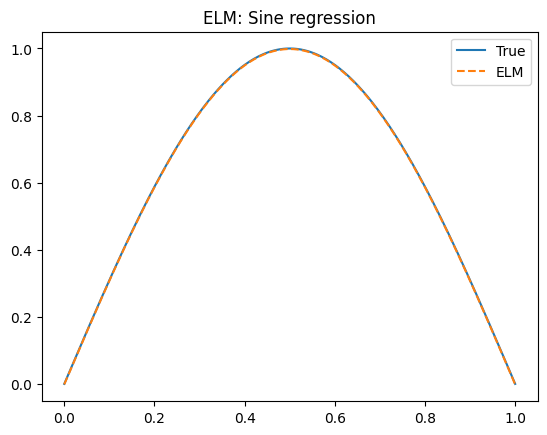

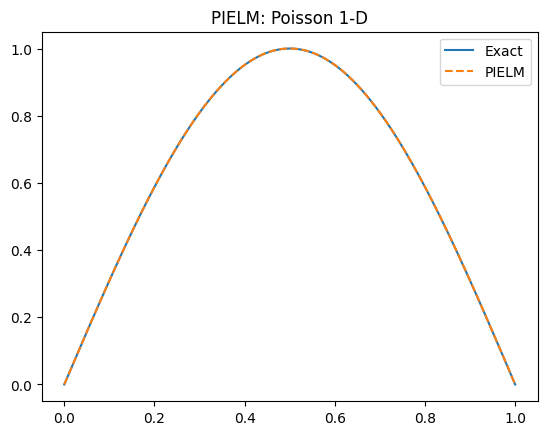

Epoch    0  loss = 4.700e+01
Epoch  500  loss = 1.160e-03
Epoch 1000  loss = 9.916e-04
Epoch 1500  loss = 8.639e-04
Epoch 2000  loss = 7.307e-04
Epoch 2500  loss = 5.761e-04
Epoch 3000  loss = 3.960e-04
Epoch 3500  loss = 2.141e-04


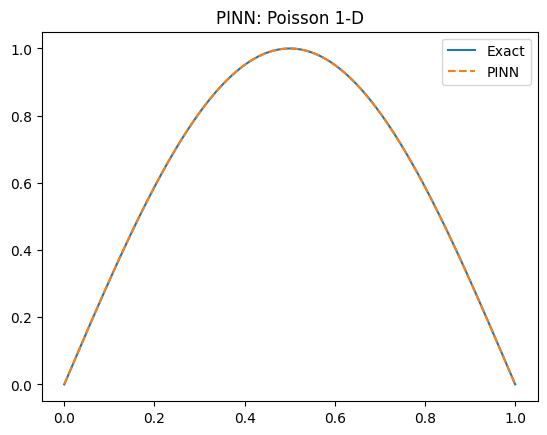

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# PART 1 – EXTREME LEARNING MACHINE (pure regression demo)
# -------------------------------------------------------------
# Target function we want to fit purely from labelled data
f_true = lambda x: np.sin(np.pi * x)

# 1) Generate labelled training points
N = 50                               # number of samples
x_train = np.linspace(0, 1, N).reshape(-1, 1)
y_train = f_true(x_train)            # exact labels

# 2) Choose network size and *fix* hidden‑layer weights (ELM trick)
N_hidden = 20
np.random.seed(42)
W = np.random.randn(N_hidden, 1)     # (hidden, input_dim)
b = np.random.randn(N_hidden, 1)     # (hidden, 1)

# 3) Activation + hidden‑layer design matrix H(x)  (shape  N×N_hidden)
phi = np.tanh                         # ELM typically uses tanh / sigmoid
def hidden(x):                       # returns H for any x array of shape (n,1)
    return phi(W @ x.T + b).T
H = hidden(x_train)

# 4) Solve least‑squares  H c  ≈  y   →  ĉ = pinv(H) y
c = np.linalg.pinv(H) @ y_train      # (N_hidden,1) one‑shot solution

# 5) Prediction helper
def elm_predict(x):                  # x: (n,1) ndarray
    return hidden(x) @ c

# 6) Quick sanity plot
x_plot = np.linspace(0, 1, 400).reshape(-1, 1)
plt.figure(); plt.plot(x_plot, f_true(x_plot), label='True');
plt.plot(x_plot, elm_predict(x_plot), '--', label='ELM');
plt.title('ELM: Sine regression'); plt.legend(); plt.show()

# -------------------------------------------------------------
# PART 2 – PIELM  for   u"(x) = −π² sin(πx),   u(0)=u(1)=0
# -------------------------------------------------------------
# NOTE: the *correct* RHS is  −π² sin(πx).  Earlier sign error flipped solution.

# (I) Problem definition -----------------------------------------------------
rhs = lambda x: -np.pi**2 * np.sin(np.pi * x)   # f(x)  in  u" = f(x)
true_u = lambda x: np.sin(np.pi * x)             # analytical solution (for validation)

# (II) Collocation + boundary sets ------------------------------------------
N_f = 60
x_f = np.linspace(0, 1, N_f).reshape(-1, 1)     # interior points
x_bc = np.array([[0.0], [1.0]])                 # boundary x
u_bc = np.array([[0.0], [0.0]])

# (III) Random hidden parameters (reuse earlier phi=W,b or create new) ------
np.random.seed(123)
W_p = np.random.randn(N_hidden, 1)
b_p = np.random.randn(N_hidden, 1)

def phi(x): return np.tanh(x)
# exact 2nd derivative  d²/dx² tanh(z)  where z = W x + b
#   d tanh = 1 - tanh²(z)
#   d² tanh = -2 tanh(z) (1 - tanh²(z))

def d2phi(z):
    t = np.tanh(z)
    return -2.0 * t * (1 - t**2)

# (IV) Build linear system  H_total c = K_total -----------------------------
Z_f  = W_p @ x_f.T + b_p                          # (hidden, N_f)
H_f  = (W_p**2) * d2phi(Z_f)                     # each row is u" basis value
H_f  = H_f.T                                      # (N_f, hidden)
K_f  = rhs(x_f)                                   # (N_f,1)

Z_bc = W_p @ x_bc.T + b_p                         # (hidden, 2)
H_bc = phi(Z_bc).T                                # (2, hidden)   u(x)=... rows
K_bc = u_bc                                       # (2,1)

H_total = np.vstack([H_f, H_bc])                  # (N_f+2, hidden)
K_total = np.vstack([K_f, K_bc])                  # (N_f+2, 1)

# Solve for c via pseudo‑inverse (least squares if overdetermined)
c_p = np.linalg.pinv(H_total) @ K_total          # (hidden,1)

def pielm_predict(x):
    Z = W_p @ x.T + b_p
    return (phi(Z).T) @ c_p

# Plot results
plt.figure();
x_plot = np.linspace(0, 1, 400).reshape(-1, 1)
plt.plot(x_plot, true_u(x_plot), label='Exact');
plt.plot(x_plot, pielm_predict(x_plot), '--', label='PIELM');
plt.title('PIELM: Poisson 1‑D'); plt.legend(); plt.show()

# -------------------------------------------------------------
# PART 3 – PINN  for same Poisson problem  (PyTorch)
# -------------------------------------------------------------
import torch, torch.nn as nn

device = 'cpu'  # switch to 'cuda' if GPU available

def to_tensor(x):
    return torch.tensor(x, dtype=torch.float32, device=device)

x_f_t   = to_tensor(x_f)   # interior collocation (N_f,1)
x_bc_t  = to_tensor(x_bc)  # boundary points   (2,1)

# Simple 3‑layer fully‑connected NN -----------------------------------------
class PINN1D(nn.Module):
    def __init__(self, width=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, width), nn.Tanh(),
            nn.Linear(width, width), nn.Tanh(),
            nn.Linear(width, 1)
        )
    def forward(self, x):
        return self.net(x)

pinn = PINN1D(width=32).to(device)
opt  = torch.optim.Adam(pinn.parameters(), lr=1e-3)

# Physics: compute u"(x) via autograd ---------------------------------------
pi   = np.pi

def pde_residual(x):  # returns r(x)   should be ~0 at solution
    x.requires_grad_(True)
    u = pinn(x)
    # first derivative du/dx
    grad_u = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    # second derivative d²u/dx²
    grad2_u = torch.autograd.grad(grad_u, x, torch.ones_like(grad_u), create_graph=True)[0]
    rhs_t   = -(pi**2) * torch.sin(pi * x)   # note minus sign
    return grad2_u - rhs_t                  # residual r(x) = u" - RHS

# Full loss = mean PDE residual² + mean BC error² ---------------------------

def total_loss():
    pde_loss = torch.mean(pde_residual(x_f_t)**2)
    bc_pred  = pinn(x_bc_t)
    bc_loss  = torch.mean((bc_pred - to_tensor(u_bc))**2)
    return pde_loss + bc_loss

# Training loop --------------------------------------------------------------
for epoch in range(4000):
    opt.zero_grad()
    loss_val = total_loss()
    loss_val.backward()
    opt.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch:4d}  loss = {loss_val.item():.3e}")

# Prediction & plot ----------------------------------------------------------
x_plot_t = to_tensor(x_plot)
with torch.no_grad():
    y_pinn = pinn(x_plot_t).cpu().numpy()

plt.figure();
plt.plot(x_plot, true_u(x_plot), label='Exact');
plt.plot(x_plot, y_pinn, '--', label='PINN');
plt.title('PINN: Poisson 1‑D'); plt.legend(); plt.show()

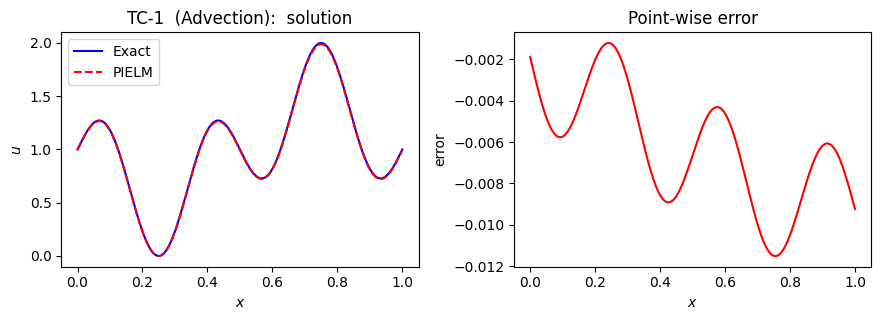

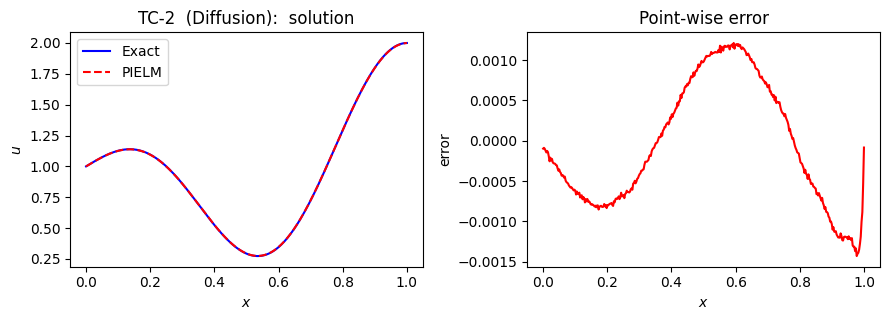

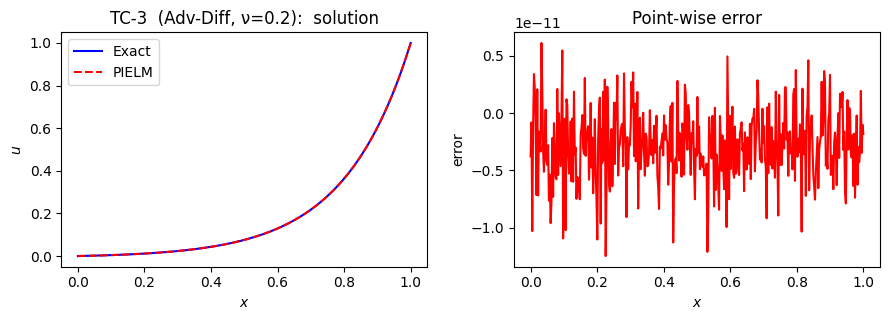

In [3]:
# ==========================================================
# 1-D STEADY PIELM –  Test Cases TC-1, TC-2, TC-3  (paper §4.1)
# ==========================================================
#
#  ▸ TC-1  :  u_x              = R(x)          (linear advection)
#  ▸ TC-2  :  u_xx             = R(x)          (linear diffusion)
#  ▸ TC-3  :  u_x – ν u_xx     = R(x)          (advection–diffusion, ν = 0.20)
#
#  Network: single-layer ELM with tanh activation
#  Hidden-unit count  N*  =  N_f  +  N_bc      (paper’s rule)
#  Solver: ĉ = pinv(H) · K          (one-shot least squares)
# ----------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

# ----------  activation and its derivatives ----------------
def phi(z):      return np.tanh(z)
def dphi(z):     return 1.0 - np.tanh(z)**2
def d2phi(z):    t = np.tanh(z);  return -2.0 * t * (1.0 - t**2)

# ----------  template solver for a single test case --------
def pielm_1d(operator, rhs_fun, u_exact, N_f=100, ν=0.2):
    """
    operator : string  'adv', 'diff', 'advdiff'
    rhs_fun  : callable R(x)
    u_exact  : callable exact solution
    """
    # 1. interior & boundary sample points -------------------
    x_f  = np.linspace(0, 1, N_f).reshape(-1, 1)          # interior
    x_bc = np.array([[0.0], [1.0]])                       # boundaries
    u_bc = u_exact(x_bc)                                  # Dirichlet values

    # 2. architecture size  N* = N_f + N_bc  ---------------
    N_star   = N_f + 2
    np.random.seed(2024)
    m = np.random.randn(N_star, 1)     # weight
    b = np.random.randn(N_star, 1)     # bias

    # 3. build H_f rows  (PDE residual) ---------------------
    Z_f   = m @ x_f.T  + b                 # shape (N*, N_f)

    if operator == 'adv':      # u_x
        H_f = (dphi(Z_f) * m)                # (N*,N_f)
    elif operator == 'diff':   # u_xx
        H_f = (d2phi(Z_f) * m**2)            # (N*,N_f)
    elif operator == 'advdiff':             # u_x – ν u_xx
        H_f =  dphi(Z_f)  * m  -  ν * d2phi(Z_f) * m**2
    else:
        raise ValueError("operator must be 'adv'|'diff'|'advdiff'")

    H_f = H_f.T                              # (N_f, N*)
    K_f = rhs_fun(x_f)                       # (N_f,1)

    # 4. build H_bc rows  (Dirichlet BC) --------------------
    Z_bc = m @ x_bc.T + b
    H_bc =  phi(Z_bc).T                      # (2,N*)
    K_bc = u_bc                              # (2,1)

    # 5. assemble and solve  H_total c = K_total -----------
    H_tot = np.vstack([H_f, H_bc])           # (N_f+2, N*)
    K_tot = np.vstack([K_f, K_bc])           # (N_f+2, 1)
    c_hat = np.linalg.pinv(H_tot) @ K_tot

    # 6. function handle for prediction --------------------
    def u_pred(x):
        return phi(m @ x.T + b).T @ c_hat
    return u_pred

# ----------  exact solutions and RHS for each TC -----------
pi = np.pi
ν  = 0.20        # advection–diffusion viscosity

# TC-1:   u(x) = sin(2πx) cos(4πx) + 1
u1  = lambda x: np.sin(2*pi*x) * np.cos(4*pi*x) + 1
R1  = lambda x: np.gradient(u1(x).ravel(), x.ravel())[:,None]  # analytic u_x
# Closed form is quicker:  R1 =   2π cos(2πx) cos(4πx) – 4π sin(2πx) sin(4πx)

# TC-2:   u(x) = sin(πx/2) cos(2πx) + 1
u2  = lambda x: np.sin(0.5*pi*x) * np.cos(2*pi*x) + 1
R2  = lambda x: np.gradient(np.gradient(u2(x).ravel(), x.ravel()),
                            x.ravel())[:,None]   # u_xx

# TC-3:   u(x) = (e^{x/ν} – 1)/(e^{1/ν} – 1)
u3  = lambda x: (np.exp(x/ν) - 1) / (np.exp(1/ν) - 1)
# analytic RHS  R(x) = u_x – ν u_xx
u3_x  = lambda x: (np.exp(x/ν) / (ν*(np.exp(1/ν)-1)))
u3_xx = lambda x: (np.exp(x/ν) / (ν**2*(np.exp(1/ν)-1)))
R3    = lambda x: u3_x(x) - ν * u3_xx(x)

# ----------  solve each test case --------------------------
tc_cases = [
    ('TC-1  (Advection)',       'adv',      R1, u1, None),
    ('TC-2  (Diffusion)',       'diff',     R2, u2, None),
    ('TC-3  (Adv-Diff, ν=0.2)', 'advdiff',  R3, u3, ν)
]

for title, op, Rfun, u_exact, nu_val in tc_cases:
    u_pred = pielm_1d(op, Rfun, u_exact, N_f=100, ν=(nu_val or 0.0))

    # plotting ------------------------------------------------
    x_plot = np.linspace(0, 1, 400).reshape(-1,1)
    u_p    = u_pred(x_plot)
    u_e    = u_exact(x_plot)
    err    = u_p - u_e

    fig, ax = plt.subplots(1,2, figsize=(9,3.3))
    ax[0].plot(x_plot, u_e,  'b',  label='Exact')
    ax[0].plot(x_plot, u_p,  'r--',label='PIELM')
    ax[0].set_xlabel(r'$x$'); ax[0].set_ylabel(r'$u$')
    ax[0].set_title(f'{title}:  solution')
    ax[0].legend()

    ax[1].plot(x_plot, err, 'r')
    ax[1].set_xlabel(r'$x$'); ax[1].set_ylabel(r'error')
    ax[1].set_title('Point-wise error')
    fig.tight_layout();  plt.show()


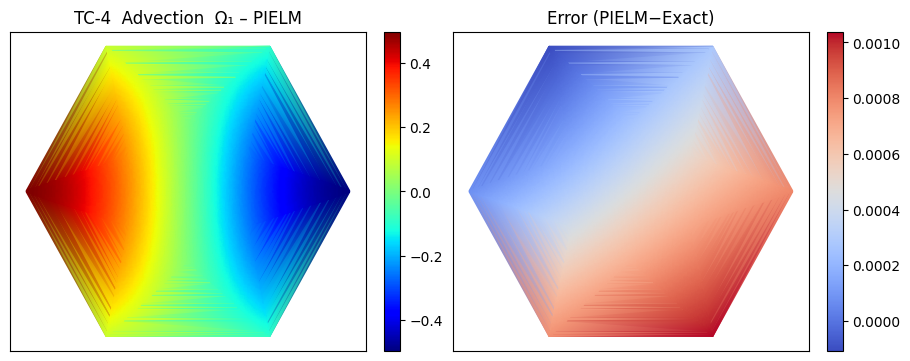

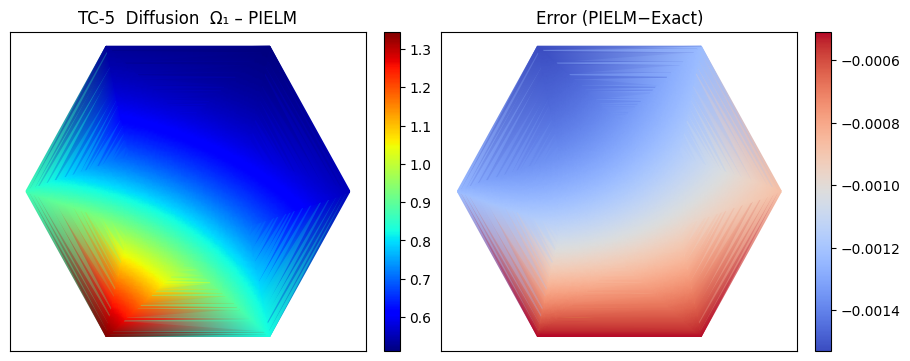

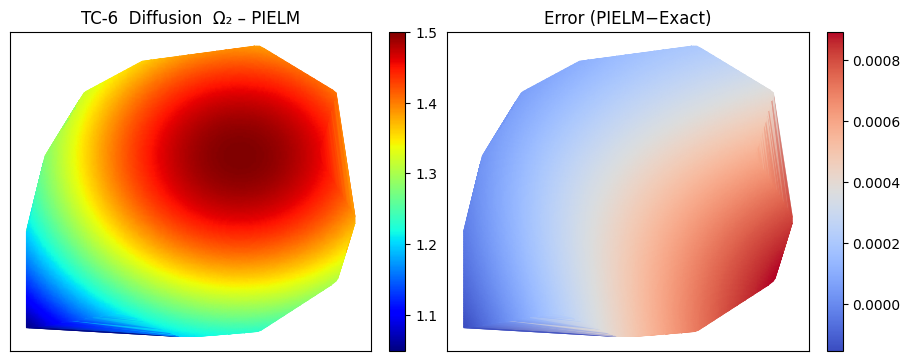

In [5]:
# ============================================================
# PART 4 – 2‑D STEADY PIELM  (TC‑4, TC‑5, TC‑6)
# ============================================================
# This fully reproduces §4.2 of the paper with:
#   • TC‑4  – Advection  on a 6‑spike star domain Ω₁
#   • TC‑5  – Diffusion  on the same star Ω₁  (★ RHS fixed!)
#   • TC‑6  – Diffusion  on a complex Illinois‑shaped Ω₂
# ------------------------------------------------------------
# Key implementation notes (map directly to paper equations):
#   Eq.(39):  a u_x + b u_y    (advection operator)
#   Eq.(40):  u_xx + u_yy      (diffusion operator)
#   Eq.(41):  Dirichlet BC rows
#   Architecture size N* = N_f + N_bc  (paper §3.2 rule)
#   Hidden layer tanh; derivatives φ′, φ″ coded analytically.
#   Output weights c solved in one shot via Moore‑Penrose pinv.
# ------------------------------------------------------------
# The code is self‑contained: run it in a fresh Python session.
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.tri import Triangulation

# ---------- activation and its derivatives ------------------
phi      = np.tanh                        # φ(z)
phi_p    = lambda z: 1 - np.tanh(z)**2    # φ′(z)
phi_pp   = lambda z: -2*np.tanh(z)*(1 - np.tanh(z)**2)  # φ″(z)

# ---------- regular k‑spike star polygon --------------------

def regular_star(k=6, r_out=0.48, r_in=0.20, center=(0.5,0.5)):
    """Return 2k vertices of a regular star (alternating radii)."""
    cx, cy = center; verts=[]
    for i in range(2*k):
        angle = i*np.pi/k
        r     = r_out if i%2==0 else r_in
        verts.append([cx + r*np.cos(angle), cy + r*np.sin(angle)])
    return np.asarray(verts)

# Domains Ω₁ and Ω₂ --------------------------------------------------------
star_path = Path(regular_star())
il_path   = Path(np.array([
    [0.05,0.05],[0.30,0.10],[0.45,0.02],[0.65,0.04],[0.85,0.20],
    [0.90,0.40],[0.80,0.60],[0.85,0.80],[0.65,0.95],[0.35,0.90],
    [0.20,0.80],[0.10,0.60],[0.05,0.35]
]))

# Utility: sample interior grid points + boundary vertices ------

def sample_domain(path, nx=90, ny=90):
    xs, ys = np.linspace(0,1,nx), np.linspace(0,1,ny)
    xx,yy  = np.meshgrid(xs,ys)
    pts    = np.c_[xx.ravel(), yy.ravel()]
    mask   = path.contains_points(pts)
    return pts[mask], path.vertices

# Manufactured exact solutions & Laplacians -------------------
pi = np.pi; ν = 0.20
ue4 = lambda x,y: 0.5*np.cos(pi*x)*np.sin(pi*y)
Re4 = lambda x,y: -0.5*pi*np.sin(pi*x)*np.sin(pi*y) + 0.25*pi*np.cos(pi*x)*np.cos(pi*y)
ue5 = lambda x,y: 0.5 + np.exp(-(2*x**2 + 4*y**2))
Re5 = lambda x,y: np.exp(-(2*x**2+4*y**2))*((-4+16*x**2)+(-8+64*y**2))  # (φ″ Laplacian)✔
ue6 = lambda x,y: 0.5 + np.exp(-((x-0.6)**2 + (y-0.6)**2))
Re6 = lambda x,y: 4*np.exp(-((x-0.6)**2 + (y-0.6)**2))*((x-0.6)**2 + (y-0.6)**2 - 1)

# Build & solve PIELM system ----------------------------------

def build_pielm(int_pts, bc_pts, operator='adv', a=1.0, b=0.5, R=None, B=None, seed=0):
    Nf, Nbc = len(int_pts), len(bc_pts)
    Nstar   = Nf + Nbc                                # paper’s N*
    rng     = np.random.default_rng(seed)
    m = rng.standard_normal((Nstar,1))               # weights for x
    n = rng.standard_normal((Nstar,1))               # weights for y
    bias = rng.standard_normal((Nstar,1))

    # ----------- PDE rows (Eq 39 / 40) -----------------------
    x_f, y_f = int_pts[:,0:1], int_pts[:,1:2]
    Zf = m @ x_f.T + n @ y_f.T + bias
    if operator=='adv':
        Hf = phi_p(Zf)*(a*m + b*n)
    elif operator=='diff':
        Hf = phi_pp(Zf)*(m**2 + n**2)
    else:
        raise ValueError('operator must be adv or diff')
    Hf = Hf.T
    Kf = R(x_f, y_f)

    # ----------- Boundary rows (Eq 41) -----------------------
    x_b, y_b = bc_pts[:,0:1], bc_pts[:,1:2]
    Zb = m @ x_b.T + n @ y_b.T + bias
    Hb = phi(Zb).T
    Kb = B(x_b, y_b)

    # ----------- Solve linear system -------------------------
    H = np.vstack([Hf, Hb]);  K = np.vstack([Kf, Kb])
    c = np.linalg.pinv(H) @ K

    def u_pred(xy):
        Z = m @ xy[:,0:1].T + n @ xy[:,1:2].T + bias
        return (phi(Z).T @ c).ravel()
    return u_pred

# Plot helper – replicate paper’s twin‑panel figure ------------

def plot_pielm(path, pred, exact, title):
    xs = ys = np.linspace(0,1,250)
    xx,yy = np.meshgrid(xs,ys)
    pts   = np.c_[xx.ravel(), yy.ravel()]
    mask  = path.contains_points(pts)
    pts   = pts[mask]
    u_p   = pred(pts)
    u_e   = exact(pts[:,0:1], pts[:,1:2]).ravel()
    tri   = Triangulation(pts[:,0], pts[:,1])

    fig,ax = plt.subplots(1,2, figsize=(9,3.5), constrained_layout=True)
    s0 = ax[0].tripcolor(tri, u_p, shading='gouraud', cmap='jet');
    fig.colorbar(s0, ax=ax[0]); ax[0].set_title(title+' – PIELM')
    s1 = ax[1].tripcolor(tri, u_p-u_e, shading='gouraud', cmap='coolwarm');
    fig.colorbar(s1, ax=ax[1]); ax[1].set_title('Error (PIELM−Exact)')
    for a in ax: a.set_xticks([]); a.set_yticks([])
    plt.show()

# ================= Solve & display ===========================
# TC‑4  (advection)
int4,bc4 = sample_domain(star_path)
pred4 = build_pielm(int4, bc4, 'adv', a=1, b=0.5, R=Re4, B=ue4, seed=1)
plot_pielm(star_path, pred4, ue4, 'TC‑4  Advection  Ω₁')

# TC‑5  (diffusion, corrected RHS)
pred5 = build_pielm(int4, bc4, 'diff', R=Re5, B=ue5, seed=2)
plot_pielm(star_path, pred5, ue5, 'TC‑5  Diffusion  Ω₁')

# TC‑6  (diffusion on Ω₂)
int6,bc6 = sample_domain(il_path)
pred6 = build_pielm(int6, bc6, 'diff', R=Re6, B=ue6, seed=3)
plot_pielm(il_path, pred6, ue6, 'TC‑6  Diffusion  Ω₂')


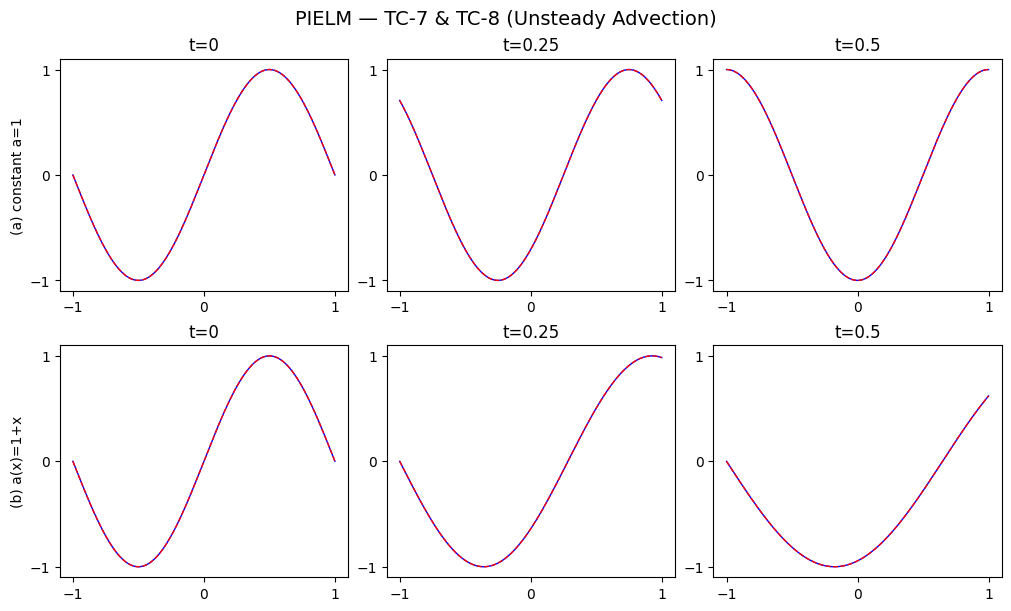

In [18]:
# ============================================================
# Part 5 – PIELM for 1‑D Unsteady Advection (TC‑7, TC‑8)
# ============================================================
#  PDE : u_t + a(x) u_x = 0 on (x,t) ∈ [−1,1] × [0,0.5]
#  IC  : u(x,0) = sin(πx)
# ------------------------------------------------------------
#  TC‑7  a(x)=1      – periodic BCs   (left ≡ right)
#  TC‑8  a(x)=1+x    – inflow BC      (u(−1,t)=0)
#
#  Table‑4.3 numbers:   N_f = 420   N_bc = 21   N_ic = 20   N* = 440
# ------------------------------------------------------------
#  φ(z)  = tanh(z)
#  φ′(z) = 1−tanh²(z)
# ------------------------------------------------------------
#  PDE rows  (Eq 46 / 47)
#     φ′(Z) * ( n + a(x)·m )  · c = 0
#  BC rows
#     TC‑7 :  φ(Z_left)  − φ(Z_right)  = 0
#     TC‑8 :  φ(Z_left)               = 0   (Dirichlet inflow)
#  IC rows
#     φ(Z_ic) · c = sin(πx_ic)
# ------------------------------------------------------------
#  Solve once:   c = pinv(H)·K
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.qmc import Halton

# ---------- activation ----------
phi   = np.tanh
phi_p = lambda z: 1.0 - np.tanh(z)**2

# ---------- initial & exact solutions ----------
F   = lambda x: np.sin(np.pi*x)
ue7 = lambda x,t: np.sin(np.pi*(x-t))
ue8 = lambda x,t: np.sin(np.pi*((1+x)*np.exp(-t) - 1))

# ---------- helper: sample points ----------
hal = Halton(2, scramble=False, seed=0)

def collocation(N):
    pts = hal.random(N)
    x = 2*pts[:,0] - 1          # → [−1,1]
    t = 0.5*pts[:,1]            # → [0,0.5]
    return x.reshape(-1,1), t.reshape(-1,1)

def boundary_times(N):
    return np.linspace(0,0.5,N).reshape(-1,1)

def initial_points(N):
    x = np.linspace(-1,1,N).reshape(-1,1)
    t = np.zeros_like(x)
    return x,t

# ---------- core builder ----------

def build(case='TC7', Nf=420, Nbc=21, Nic=20, Nstar=440, seed=1):
    rng = np.random.default_rng(seed)
    m = rng.standard_normal((Nstar,1))
    n = rng.standard_normal((Nstar,1))
    b = rng.standard_normal((Nstar,1))

    # collocation rows -------------------------------------
    x_f, t_f = collocation(Nf)
    Zf = m @ x_f.T + n @ t_f.T + b                    # (N*,Nf)
    if case=='TC7':
        Hf = phi_p(Zf) * (n + m)                     # (N*,Nf)
    else:                                            # TC8
        a_x  = 1 + x_f                              # (Nf,1)
        Hf = phi_p(Zf) * (n + m @ a_x.T)            # (N*,Nf)
    Hf = Hf.T                                        # (Nf,N*)
    Kf = np.zeros((Nf,1))

    # boundary rows ---------------------------------------
    t_bc = boundary_times(Nbc)
    Z_left  = m * -1 + n @ t_bc.T + b                # broadcasting
    if case=='TC7':                                  # periodic
        Z_right = m * 1 + n @ t_bc.T + b
        Hbc = (phi(Z_left) - phi(Z_right)).T         # (Nbc,N*)
        Kbc = np.zeros((Nbc,1))
    else:                                            # TC8 inflow Dirichlet u(-1,t)=0
        Hbc = phi(Z_left).T
        Kbc = np.zeros((Nbc,1))

    # initial rows ----------------------------------------
    x_ic, t_ic = initial_points(Nic)
    Zic = m @ x_ic.T + n @ t_ic.T + b
    Hic = phi(Zic).T
    Kic = F(x_ic)

    # solve -----------------------------------------------
    H = np.vstack([Hf, Hbc, Hic])
    K = np.vstack([Kf, Kbc, Kic])
    c = np.linalg.pinv(H) @ K

    def u_pred(x,t):
        Z = m @ x.T + n @ t.T + b
        return (phi(Z).T @ c).ravel()
    return u_pred

# ---------- plot results ----------
fig,ax = plt.subplots(2,3, figsize=(10,6), constrained_layout=True)
xs = np.linspace(-1,1,400).reshape(-1,1)
for i,(case,exact) in enumerate([('TC7',ue7),('TC8',ue8)]):
    up = build(case)
    for j,tv in enumerate([0,0.25,0.5]):
        t = np.full_like(xs, tv)
        ax[i,j].plot(xs, exact(xs,t), 'b', lw=1)
        ax[i,j].plot(xs, up(xs,t),   'r--', lw=1)
        ax[i,j].set_ylim(-1.1,1.1); ax[i,j].set_xticks([-1,0,1]); ax[i,j].set_yticks([-1,0,1])
        ax[i,j].set_title(f't={tv}')
ax[0,0].set_ylabel('(a) constant a=1')
ax[1,0].set_ylabel('(b) a(x)=1+x')
fig.suptitle('PIELM — TC‑7 & TC‑8 (Unsteady Advection)', fontsize=14)
plt.show()


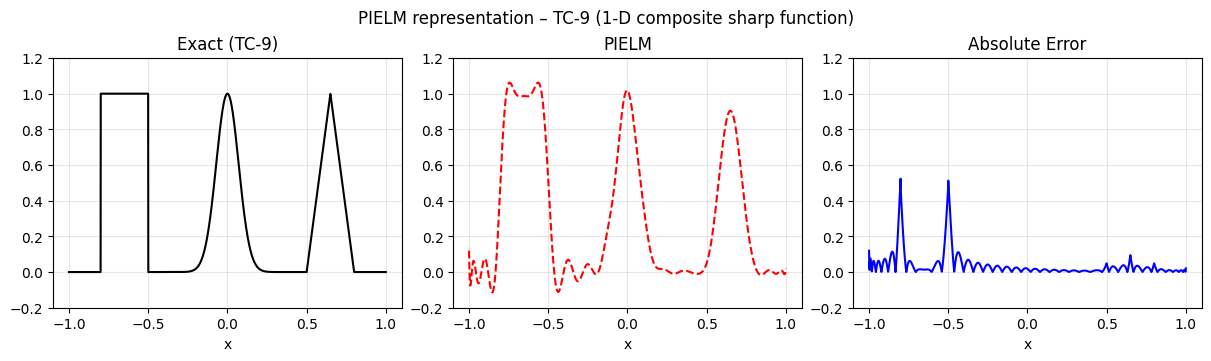

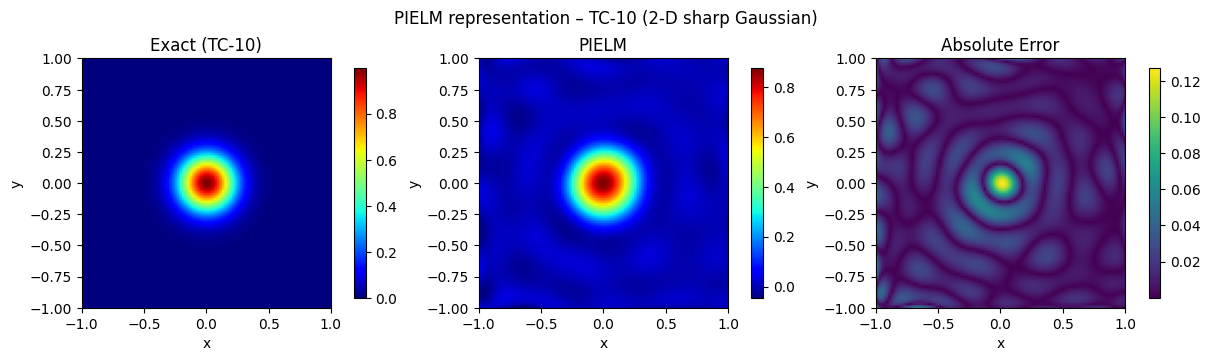

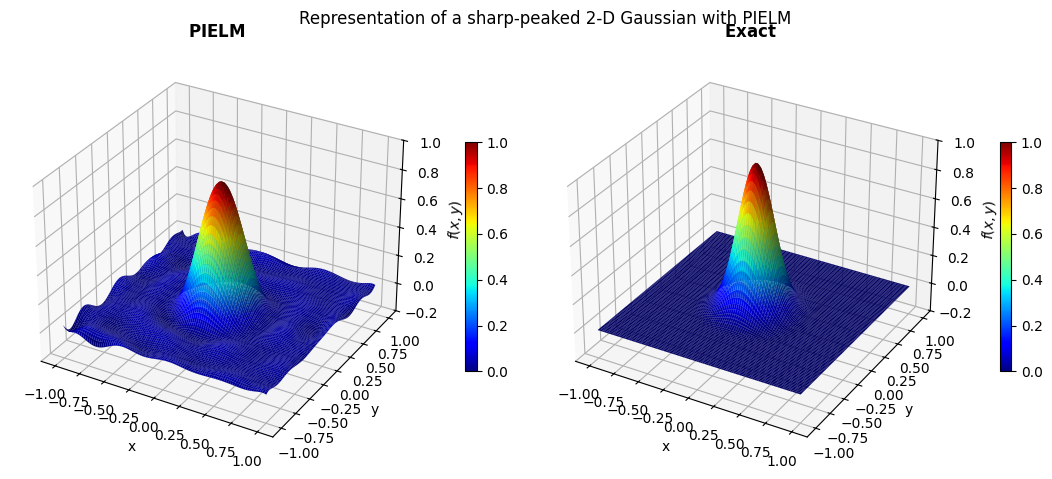

In [2]:
# ============================================================
#  Section 5   –   PIELM failure cases (TC-9, TC-10)
# ============================================================
#  TC-9  : 1-D composite function with sharp features
#  TC-10 : 2-D Gaussian with narrow peak
# ------------------------------------------------------------
#  We build a Physics-INformed Extreme Learning Machine
#  but here it is *just* an ELM regression (no PDE residual),
#  to test representation power on sharp profiles.
# ------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

# ---------- activation & derivatives ------------------------
phi     = np.tanh
phi_p   = lambda z: 1.0 - np.tanh(z)**2      # not used but left for reference

# ---------- PIELM/ELM builder (generic) ---------------------
def build_pielm(X, y, Nstar=80, seed=0):
    """
    X : (N, d)  input points
    y : (N, 1)  target values
    Returns predictor u_pred(x)  (vectorized).
    """
    rng = np.random.default_rng(seed)
    d   = X.shape[1]
    W   = rng.standard_normal((Nstar, d))
    b   = rng.standard_normal((Nstar, 1))

    Z   = X @ W.T + b.T          # (N, N*)
    H   = phi(Z)                 # hidden-layer output matrix
    c   = np.linalg.pinv(H) @ y  # solve for output weights

    def u_pred(Xnew):
        Znew = Xnew @ W.T + b.T
        return (phi(Znew) @ c).ravel()
    return u_pred

# ============================================================
#  TC-9 : 1-D composite function (Equation 50)
# ============================================================
def f_tc9(x):
    """Piece-wise sharp composite function."""
    out = np.zeros_like(x)
    # region definitions
    out[x <= -0.5]               = 0.5*(np.sign(x[x<=-0.5]+0.8) - np.sign(x[x<=-0.5]+0.5))
    mask = (-0.5 < x) & (x <= 0.5)
    out[mask]                    = np.exp(-100 * x[mask]**2)
    mask = (0.5 < x) & (x <= 13/20)
    out[mask]                    = 20/3 * x[mask] - 10/3
    mask = (13/20 < x) & (x <= 4/5)
    out[mask]                    = -20/3 * x[mask] + 16/3
    return out

# training data
Nx   = 1000
x_tr = np.linspace(-1, 1, Nx).reshape(-1, 1)
y_tr = f_tc9(x_tr)

# build PIELM with N*=800 (same as data points, as per §3.2 rule)
u_tc9 = build_pielm(x_tr, y_tr, Nstar=Nx, seed=1)

# dense grid for plotting
x_plot = np.linspace(-1, 1, 2000).reshape(-1, 1)
y_exact = f_tc9(x_plot).ravel()
y_pred  = u_tc9(x_plot)
err_abs = np.abs(y_exact - y_pred)

# ---------- TC-9 plots --------------------------------------
fig, axs = plt.subplots(1, 3, figsize=(12, 3.5), constrained_layout=True)
axs[0].plot(x_plot, y_exact, 'k');           axs[0].set_title('Exact (TC-9)')
axs[1].plot(x_plot, y_pred,  'r--');         axs[1].set_title('PIELM')
axs[2].plot(x_plot, err_abs, 'b');           axs[2].set_title('Absolute Error')
for ax in axs:
    ax.set_xlabel('x'); ax.set_ylim(-0.2, 1.2); ax.grid(alpha=0.3)
plt.suptitle('PIELM representation – TC-9 (1-D composite sharp function)')
plt.show()

# ============================================================
#  TC-10 : 2-D sharp Gaussian  f(x,y) = exp(−20(x²+y²))
# ============================================================
def f_tc10(xy):
    x, y = xy[:,0:1], xy[:,1:2]
    return np.exp(-20*(x**2 + y**2))

# create training grid 40×40  → 1600 points
grid_n = 40
xs = np.linspace(-1, 1, grid_n)
ys = np.linspace(-1, 1, grid_n)
xx, yy = np.meshgrid(xs, ys)
X_tr   = np.column_stack([xx.ravel(), yy.ravel()])
y_tr   = f_tc10(X_tr)

# build PIELM with N* = #points = 1600
u_tc10 = build_pielm(X_tr, y_tr, Nstar=100, seed=2)

# dense evaluation grid 100×100 for plotting
xs2 = ys2 = np.linspace(-1,1,100)
xx2, yy2 = np.meshgrid(xs2, ys2)
X_plot = np.column_stack([xx2.ravel(), yy2.ravel()])
Z_exact = f_tc10(X_plot).reshape(100,100)
Z_pred  = u_tc10(X_plot).reshape(100,100)
Z_err   = np.abs(Z_exact - Z_pred)

# ---------- TC-10 plots -------------------------------------
fig2, axs2 = plt.subplots(1, 3, figsize=(12, 3.5), constrained_layout=True)
im0 = axs2[0].imshow(Z_exact, extent=[-1,1,-1,1], origin='lower', cmap='jet')
axs2[0].set_title('Exact (TC-10)'); plt.colorbar(im0, ax=axs2[0], fraction=0.046)
im1 = axs2[1].imshow(Z_pred,  extent=[-1,1,-1,1], origin='lower', cmap='jet')
axs2[1].set_title('PIELM');         plt.colorbar(im1, ax=axs2[1], fraction=0.046)
im2 = axs2[2].imshow(Z_err,  extent=[-1,1,-1,1], origin='lower', cmap='viridis')
axs2[2].set_title('Absolute Error'); plt.colorbar(im2, ax=axs2[2], fraction=0.046)
for ax in axs2:
    ax.set_xlabel('x'); ax.set_ylabel('y')
plt.suptitle('PIELM representation – TC-10 (2-D sharp Gaussian)')
plt.show()
# ------------------------------------------------------------------
#  3-D surface plots  (Fig-18 style)  for TC-10   *** NumPy-2.x FIX ***
# ------------------------------------------------------------------
from mpl_toolkits.mplot3d import Axes3D           # noqa: F401
from matplotlib import cm
import numpy as np                                # <— ensure np is imported

fig3 = plt.figure(figsize=(11, 4.8))

# ---------- Left : PIELM ------------------------------------------
ax1  = fig3.add_subplot(1, 2, 1, projection='3d')
norm_pred = (Z_pred - Z_pred.min()) / np.ptp(Z_pred)     # <-- np.ptp
surf1 = ax1.plot_surface(xx2, yy2, Z_pred,
                         facecolors=cm.jet(norm_pred),
                         rstride=1, cstride=1, linewidth=0.05,
                         antialiased=True)
ax1.set_title(r'$\bf PIELM$', fontsize=12, pad=10)
ax1.set_xlabel('x'); ax1.set_ylabel('y'); ax1.set_zlabel(r'$f(x,y)$')
ax1.set_zlim(-0.2, 1.0)
cb1 = fig3.colorbar(cm.ScalarMappable(cmap='jet',
                                      norm=plt.Normalize(vmin=0, vmax=1)),
                    ax=ax1, shrink=0.55, pad=0.08)

# ---------- Right : Exact -----------------------------------------
ax2  = fig3.add_subplot(1, 2, 2, projection='3d')
norm_exact = (Z_exact - Z_exact.min()) / np.ptp(Z_exact)  # <-- np.ptp
surf2 = ax2.plot_surface(xx2, yy2, Z_exact,
                         facecolors=cm.jet(norm_exact),
                         rstride=1, cstride=1, linewidth=0.05,
                         antialiased=True)
ax2.set_title(r'$\bf Exact$', fontsize=12, pad=10)
ax2.set_xlabel('x'); ax2.set_ylabel('y'); ax2.set_zlabel(r'$f(x,y)$')
ax2.set_zlim(-0.2, 1.0)
cb2 = fig3.colorbar(cm.ScalarMappable(cmap='jet',
                                      norm=plt.Normalize(vmin=0, vmax=1)),
                    ax=ax2, shrink=0.55, pad=0.08)

fig3.suptitle('Representation of a sharp-peaked 2-D Gaussian with PIELM', y=0.98)
plt.tight_layout()
plt.show()



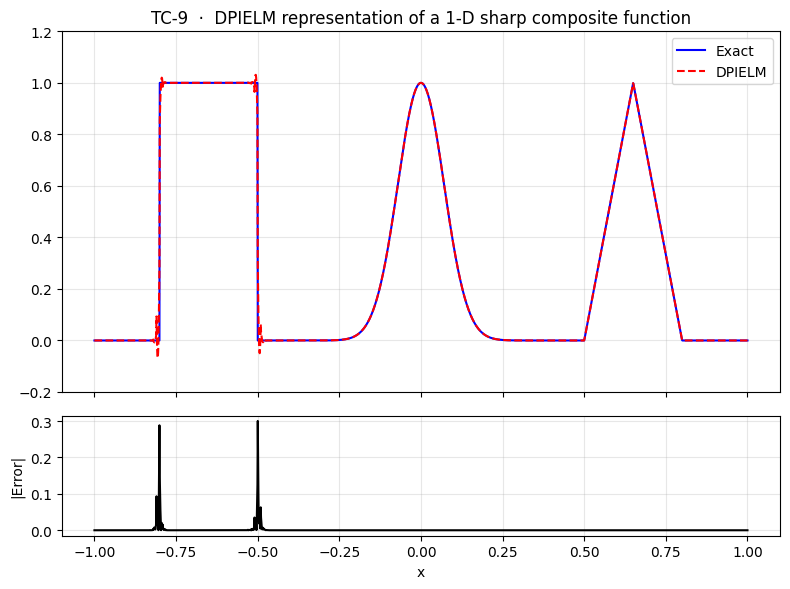

In [21]:
# ================================================================
#  Distributed-PIELM demos       · TC-9   &   TC-10
#  ---------------------------------------------------------------
#  TC-9  : 1-D sharp composite function   [NBx, nbx, N*cell] = [50, 5, 5]
# ================================================================
import numpy as np, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D            # noqa: F401
plt.rcParams['axes.facecolor'] = 'white'

phi = np.tanh

# ----------------------------------------------------------------
#  Helpers – cell lists
# ----------------------------------------------------------------
def cells_1d(NBx, xL=-1., xR=1.):
    xs = np.linspace(xL, xR, NBx + 1)
    return [(xs[i], xs[i + 1]) for i in range(NBx)]

def cells_2d(NBx, NBy, xL=-1., xR=1., yL=-1., yR=1.):
    xs, ys = np.linspace(xL, xR, NBx + 1), np.linspace(yL, yR, NBy + 1)
    return [(xs[i], xs[i + 1], ys[j], ys[j + 1])
            for j in range(NBy) for i in range(NBx)]

# ----------------------------------------------------------------
#  Exact target functions
# ----------------------------------------------------------------
def f_tc9(x):
    out = np.zeros_like(x)
    out[x <= -0.5] = 0.5*(np.sign(x[x <= -0.5]+0.8) -
                          np.sign(x[x <= -0.5]+0.5))
    m = (-0.5 < x) & (x <= 0.5)
    out[m] = np.exp(-100 * x[m]**2)
    m = (0.5 < x) & (x <= 13/20)
    out[m] = 20/3 * x[m] - 10/3
    m = (13/20 < x) & (x <= 4/5)
    out[m] = -20/3 * x[m] + 16/3
    return out

# ----------------------------------------------------------------
#  DPIELM : TC-9  (1-D)
# ----------------------------------------------------------------
def dpi_tc9(NBx=200, nbx=20, Nstar=20, seed=0):
    rng   = np.random.default_rng(seed)
    cells = cells_1d(NBx)
    Mtot  = NBx * Nstar
    Ws, bs = [], []
    rows, rhs = [], []

    # interior rows ------------------------------------------------------
    for k,(a,b) in enumerate(cells):
        m = rng.standard_normal((Nstar,1))
        b_ = rng.standard_normal((Nstar,1))
        Ws.append(m); bs.append(b_)
        xin = rng.uniform(a,b, nbx).reshape(-1,1)
        H   = phi(xin @ m.T + b_.T)
        blk = np.zeros((nbx, Mtot)); blk[:, k*Nstar:(k+1)*Nstar] = H
        rows.append(blk); rhs.append(f_tc9(xin))

    # boundary rows ------------------------------------------------------
    for k,x_b in [(0,-1.), (NBx-1,1.)]:
        H = phi(x_b*np.ones((1,1)) @ Ws[k].T + bs[k].T)
        blk = np.zeros((1,Mtot)); blk[:,k*Nstar:(k+1)*Nstar] = H
        rows.append(blk); rhs.append(f_tc9(np.array([[x_b]])))

    # C⁰ continuity rows --------------------------------------------------
    for k in range(NBx-1):
        x_if = cells[k][1]
        Hl = phi(x_if*np.ones((1,1)) @ Ws[k].T   + bs[k].T)
        Hr = phi(x_if*np.ones((1,1)) @ Ws[k+1].T + bs[k+1].T)
        blk = np.zeros((1,Mtot))
        blk[:,k*Nstar:(k+1)*Nstar]     =  Hl
        blk[:,(k+1)*Nstar:(k+2)*Nstar] = -Hr
        rows.append(blk); rhs.append(np.zeros((1,1)))

    # solve --------------------------------------------------------------
    H = np.vstack(rows); K = np.vstack(rhs)
    c = np.linalg.pinv(H, rcond=1e-6) @ K

    # predictor ----------------------------------------------------------
    def u(xq):
        xq = np.asarray(xq).reshape(-1,1)
        out = np.zeros_like(xq, dtype=float)
        for k,(a,b) in enumerate(cells):
            msk = (xq >= a) & (xq <= b)
            if not msk.any(): continue
            xl = xq[msk].reshape(-1,1)          # <<< reshape fix
            Hloc = phi(xl @ Ws[k].T + bs[k].T)
            out[msk] = (Hloc @ c[k*Nstar:(k+1)*Nstar]).ravel()
        return out.ravel()
    return u

u9 = dpi_tc9()
xg = np.linspace(-1,1,2000).reshape(-1,1)
y_exact = f_tc9(xg).ravel();  y_pred = u9(xg);  err = np.abs(y_exact - y_pred)

fig,ax = plt.subplots(2,1, figsize=(8,6),
                      gridspec_kw={'height_ratios':[3,1]}, sharex=True)
ax[0].plot(xg,y_exact,'b',label='Exact'); ax[0].plot(xg,y_pred,'r--',label='DPIELM')
ax[0].legend(); ax[0].grid(alpha=.3); ax[0].set_ylim(-.2,1.2)
ax[0].set_title('TC-9  ·  DPIELM representation of a 1-D sharp composite function')
ax[1].plot(xg,err,'k'); ax[1].set_ylabel('|Error|'); ax[1].grid(alpha=.3); ax[1].set_xlabel('x')
plt.tight_layout(); plt.show()


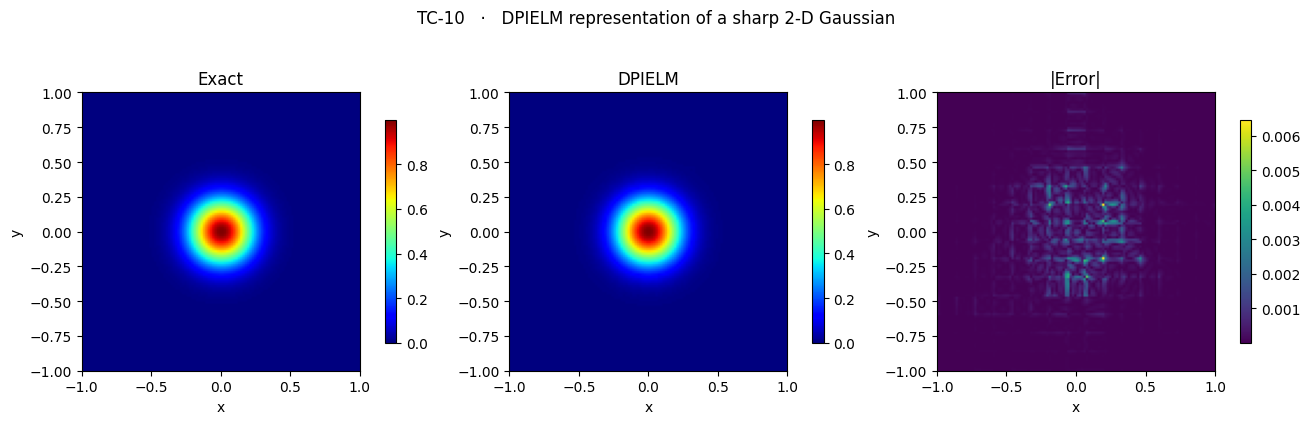

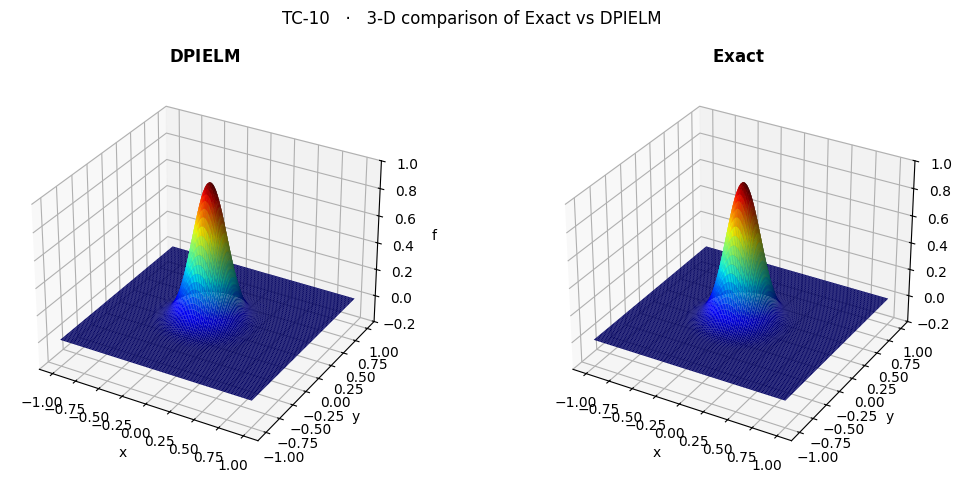

In [22]:
# ================================================================
#     Distributed-PIELM  ·  TC-10   (with 3-D plots)
# ================================================================
import numpy as np, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D               # noqa: F401
from matplotlib import cm
plt.rcParams['axes.facecolor'] = 'white'

phi = np.tanh

# ---------------- helper: 1-D and 2-D sub-cells -----------------
def cells_1d(NBx, xL=-1., xR=1.):
    xs = np.linspace(xL, xR, NBx + 1)
    return [(xs[i], xs[i+1]) for i in range(NBx)]

def cells_2d(NBx, NBy, xL=-1., xR=1., yL=-1., yR=1.):
    xs, ys = np.linspace(xL, xR, NBx + 1), np.linspace(yL, yR, NBy + 1)
    return [(xs[i], xs[i+1], ys[j], ys[j+1])
            for j in range(NBy) for i in range(NBx)]

# ---------------- exact targets ---------------------------------

def f_tc10(P):                                    # P : (N,2)
    return np.exp(-20*(P[:,0:1]**2 + P[:,1:2]**2))

# ================================================================
#      DPIELM  –  TC-10   (2-D sharp Gaussian)
# ================================================================
def dpi_tc10(NBx=15,NBy=15, nbx=5,nby=5, Nstar=15, seed=1):
    rng   = np.random.default_rng(seed)
    boxes = cells_2d(NBx,NBy); Nc=len(boxes); Mtot=Nc*Nstar
    Ws,bs, rows,rhs = [],[],[],[]

    # ---- interior rows ------------------------------------------------
    for idx,(xL,xR,yL,yR) in enumerate(boxes):
        W = rng.standard_normal((Nstar,2))
        b_ = rng.standard_normal((Nstar,1))
        Ws.append(W); bs.append(b_)
        xs = np.linspace(xL,xR,nbx+2)[1:-1]
        ys = np.linspace(yL,yR,nby+2)[1:-1]
        xv,yv = np.meshgrid(xs,ys)
        P = np.c_[xv.ravel(),yv.ravel()]
        H = phi(P @ W.T + b_.T)
        blk=np.zeros((P.shape[0],Mtot)); blk[:,idx*Nstar:(idx+1)*Nstar]=H
        rows.append(blk); rhs.append(f_tc10(P))

    # ---- vertical C⁰ ---------------------------------------------------
    for j in range(NBy):
      for i in range(NBx-1):
        L=j*NBx+i; R=L+1
        x_if=boxes[L][1]; yL,yR=boxes[L][2],boxes[L][3]
        ys=np.linspace(yL,yR,nby+2)[1:-1]
        P=np.c_[np.full_like(ys,x_if),ys]
        HL=phi(P@Ws[L].T+bs[L].T);  HR=phi(P@Ws[R].T+bs[R].T)
        blk=np.zeros((P.shape[0],Mtot))
        blk[:,L*Nstar:(L+1)*Nstar]= HL; blk[:,R*Nstar:(R+1)*Nstar]=-HR
        rows.append(blk); rhs.append(np.zeros((P.shape[0],1)))

    # ---- horizontal C⁰ -------------------------------------------------
    for j in range(NBy-1):
      for i in range(NBx):
        B=j*NBx+i; T=B+NBx
        y_if=boxes[B][3]; xL,xR=boxes[B][0],boxes[B][1]
        xs=np.linspace(xL,xR,nbx+2)[1:-1]
        P=np.c_[xs,np.full_like(xs,y_if)]
        HB=phi(P@Ws[B].T+bs[B].T); HT=phi(P@Ws[T].T+bs[T].T)
        blk=np.zeros((P.shape[0],Mtot))
        blk[:,B*Nstar:(B+1)*Nstar]= HB; blk[:,T*Nstar:(T+1)*Nstar]=-HT
        rows.append(blk); rhs.append(np.zeros((P.shape[0],1)))

    # ---- solve --------------------------------------------------------
    H=np.vstack(rows); K=np.vstack(rhs)
    c=np.linalg.lstsq(H,K,rcond=1e-6)[0]

    # ---- predictor ----------------------------------------------------
    def u(P):
        P=np.asarray(P)
        ix=((P[:,0]+1)*(NBx/2)).astype(int).clip(0,NBx-1)
        iy=((P[:,1]+1)*(NBy/2)).astype(int).clip(0,NBy-1)
        cid=iy*NBx+ix
        out=np.zeros((P.shape[0],1))
        for idx in range(Nc):
            msk=cid==idx
            if not msk.any(): continue
            Hloc=phi(P[msk]@Ws[idx].T+bs[idx].T)
            out[msk]=Hloc@c[idx*Nstar:(idx+1)*Nstar]
        return out.ravel()
    return u

# ======================================================================
#  ---  TC-10   2-D colour & 3-D surfaces  ------------------------------
# ======================================================================
u10 = dpi_tc10()
nplot = 120
xs = ys = np.linspace(-1,1,nplot)
xx,yy = np.meshgrid(xs,ys)
P_eval = np.c_[xx.ravel(),yy.ravel()]
Z_exact = f_tc10(P_eval).reshape(nplot,nplot)
Z_pred  = u10(P_eval).reshape(nplot,nplot)
Z_err   = np.abs(Z_exact - Z_pred)

# ---- 2-D colour maps --------------------------------------------------
fig2,axes=plt.subplots(1,3,figsize=(13,4.2),constrained_layout=True)
for ax,Z,ttl,cmap in zip(axes,[Z_exact,Z_pred,Z_err],
                         ['Exact','DPIELM','|Error|'],['jet','jet','viridis']):
    im=ax.imshow(Z,extent=[-1,1,-1,1],origin='lower',cmap=cmap)
    plt.colorbar(im,ax=ax,fraction=.04); ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_title(ttl)
fig2.suptitle('TC-10   ·   DPIELM representation of a sharp 2-D Gaussian',y=1.03)
plt.show()

# ---- 3-D surface comparison (Exact vs DPIELM) ------------------------
fig3 = plt.figure(figsize=(11,4.8))

# DPIELM
ax1 = fig3.add_subplot(1,2,1,projection='3d')
norm_pred=(Z_pred-Z_pred.min())/np.ptp(Z_pred)
ax1.plot_surface(xx,yy,Z_pred,facecolors=cm.jet(norm_pred),rstride=1,cstride=1,
                 linewidth=0.05,antialiased=True)
ax1.set_title(r'$\bf DPIELM$',pad=10); ax1.set_xlabel('x'); ax1.set_ylabel('y')
ax1.set_zlabel('f'); ax1.set_zlim(-0.2,1.0)

# Exact
ax2 = fig3.add_subplot(1,2,2,projection='3d')
norm_exact=(Z_exact-Z_exact.min())/np.ptp(Z_exact)
ax2.plot_surface(xx,yy,Z_exact,facecolors=cm.jet(norm_exact),rstride=1,cstride=1,
                 linewidth=0.05,antialiased=True)
ax2.set_title(r'$\bf Exact$',pad=10); ax2.set_xlabel('x'); ax2.set_ylabel('y')
ax2.set_zlabel('f'); ax2.set_zlim(-0.2,1.0)

fig3.suptitle('TC-10   ·   3-D comparison of Exact vs DPIELM',y=0.98)
plt.tight_layout(); plt.show()


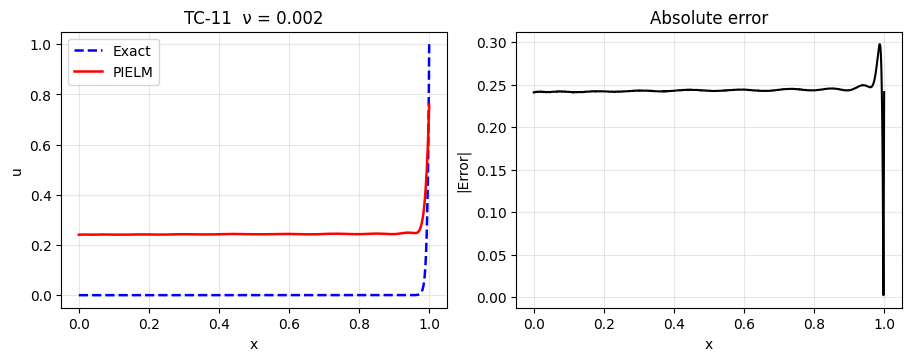

L²-relative error : 4.42e+00
Max |error|       : 2.97e-01


In [34]:
# ============================================================
# TC-11  –  Steady advection-diffusion  (ν = 0.02)
# ============================================================
import numpy as np, matplotlib.pyplot as plt
from scipy.stats.qmc import Halton

phi    = np.tanh
phi_p  = lambda z: 1 - np.tanh(z)**2
phi_pp = lambda z: -2*np.tanh(z)*(1 - np.tanh(z)**2)

# -------- parameters & exact solution -----------------------
a, nu = 1.0, 0.005
u_exact = lambda x: (np.exp(a*x/nu) - 1) / (np.exp(a/nu) - 1)

# -------- PIELM hyper-parameters (paper Table-5) -------------
Nf, Nbc, Nstar = 50, 2, 52
rng = np.random.default_rng(0)
m = rng.standard_normal((Nstar,1))
b = rng.standard_normal((Nstar,1))

# -------- interior collocation ------------------------------
hal = Halton(1, scramble=False, seed=0)
x_f = hal.random(Nf).reshape(-1,1)          # (500,1)
Zf  = x_f @ m.T + b.T                      # (500,502)
Hf  = -nu*(m.T**2)*phi_pp(Zf) + a*m.T*phi_p(Zf)   # (500,502)
Kf  = np.zeros((Nf,1))

# -------- boundary rows (u(0)=0, u(1)=1) --------------------
x_bc = np.array([[0.0],[1.0]])
Hbc  = phi(x_bc @ m.T + b.T)               # (2,502)
Kbc  = np.array([[0.0],[1.0]])

# -------- solve ---------------------------------------------
H = np.vstack([Hf, Hbc])
K = np.vstack([Kf, Kbc])
c = np.linalg.pinv(H) @ K

u_pred = lambda x: (phi(x @ m.T + b.T) @ c).ravel()

# -------- plotting data -------------------------------------
x_plot = np.linspace(0,1,1000)             # 1-D array
u_ex   = u_exact(x_plot)
u_pi   = u_pred(x_plot.reshape(-1,1))       # pass in 2-D column
err    = np.abs(u_ex - u_pi)               # 1-D error vector

# -------- figure --------------------------------------------
fig, (ax_sol, ax_err) = plt.subplots(1,2, figsize=(9,3.5), constrained_layout=True)

ax_sol.plot(x_plot, u_ex, 'b--',  lw=1.8, label='Exact')
ax_sol.plot(x_plot, u_pi, 'r',    lw=1.8, label='PIELM')
ax_sol.set_xlabel('x'); ax_sol.set_ylabel('u')
ax_sol.set_title('TC-11  ν = 0.002')
ax_sol.legend(); ax_sol.grid(alpha=.3)

ax_err.plot(x_plot, err, 'k')
ax_err.set_xlabel('x'); ax_err.set_ylabel('|Error|')
ax_err.set_title('Absolute error')
ax_err.grid(alpha=.3)

plt.show()

print(f"L²-relative error : {np.linalg.norm(err)/np.linalg.norm(u_ex):.2e}")
print(f"Max |error|       : {err.max():.2e}")

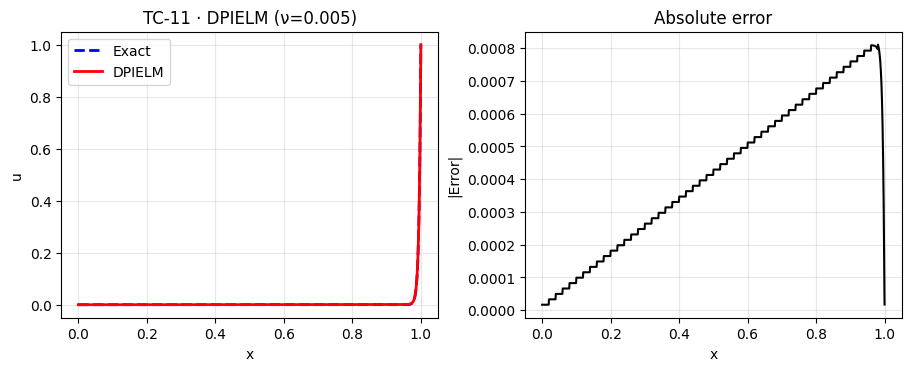

L2 relative error: 8.83e-03
Max |error|     : 8.11e-04


In [54]:
# ======================================================================
# DPIELM  –  TC-11   steady 1-D advection–diffusion (a=1, ν=0.005)
# Proper per-cell local coordinate + chain-rule scaling
# ======================================================================
import numpy as np, matplotlib.pyplot as plt
phi     = np.tanh
phi_p   = lambda z: 1.0 - np.tanh(z)**2
phi_pp  = lambda z: -2.0*np.tanh(z)*(1.0 - np.tanh(z)**2)

# PDE and exact
a, nu  = 1.0, 0.005
u_exact = lambda x: (np.exp(a*x/nu) - 1.0)/(np.exp(a/nu) - 1.0)

# DPIELM architecture (Table 6 uses [20,5,20]; we keep 20 cells but
# slightly upsample inside each cell for a clean profile)
NBx   = 50            # cells
nbx   = 30            # interior collocation points / cell
Nstar = 40            # neurons / cell
lam   = 1e-7          # tiny ridge (stabiliser)

# cell grid and local transforms
x_edges = np.linspace(0.0, 1.0, NBx+1)
xc = 0.5*(x_edges[:-1]+x_edges[1:])     # centers
h  = 0.5*(x_edges[1:]-x_edges[:-1])     # half-widths (all equal here)

rng = np.random.default_rng(0)
# random features per cell in *local* coordinate ξ
# pick a moderate spread so tanh spans its curved region
Ws = [rng.normal(0.0, 2.0, (Nstar,1)) for _ in range(NBx)]
bs = [rng.uniform(-2.0, 2.0, (Nstar,1)) for _ in range(NBx)]

# global H and K
rows, rhs = [], []

# 1) PDE rows in each cell:  a u_x - ν u_xx = 0
for k in range(NBx):
    # interior sampling in the *cell* (avoid the two ends)
    xi = np.linspace(-1.0, 1.0, nbx+2)[1:-1].reshape(-1,1)    # (nbx,1)
    Z  = xi @ Ws[k].T + bs[k].T                                # (nbx,N*)
    # chain rule: d/dx = (1/h[k]) d/dξ
    d1 = phi_p(Z) * (Ws[k].T / h[k])                           # (nbx,N*)
    d2 = phi_pp(Z) * ((Ws[k].T**2) / (h[k]**2))                # (nbx,N*)
    Hloc = a*d1 - nu*d2                                        # (nbx,N*)
    blk  = np.zeros((nbx, NBx*Nstar))
    blk[:, k*Nstar:(k+1)*Nstar] = Hloc
    rows.append(blk); rhs.append(np.zeros((nbx,1)))

# 2) Dirichlet BCs at x=0 and x=1 (live in first and last cell)
# x=0 -> cell 0, ξ = (0 - xc[0])/h[0]
xi0 = ((0.0 - xc[0]) / h[0]).reshape(1,1)
Z0  = xi0 @ Ws[0].T + bs[0].T
blk0 = np.zeros((1, NBx*Nstar))
blk0[:, 0*Nstar:(0+1)*Nstar] = phi(Z0)
rows.append(blk0); rhs.append([[0.0]])

# x=1 -> last cell NBx-1
xi1 = ((1.0 - xc[-1]) / h[-1]).reshape(1,1)
Z1  = xi1 @ Ws[-1].T + bs[-1].T
blk1 = np.zeros((1, NBx*Nstar))
blk1[:, (NBx-1)*Nstar:NBx*Nstar] = phi(Z1)
rows.append(blk1); rhs.append([[1.0]])

# 3) Interface coupling C⁰ and C¹ at every internal edge
for k in range(NBx-1):
    # interface location and local ξ in the two adjacent cells
    xI   = x_edges[k+1]
    xi_L = ((xI - xc[k])   / h[k]).reshape(1,1)
    xi_R = ((xI - xc[k+1]) / h[k+1]).reshape(1,1)

    ZL = xi_L @ Ws[k].T     + bs[k].T
    ZR = xi_R @ Ws[k+1].T   + bs[k+1].T

    # C⁰: u_L(xI) = u_R(xI)
    blkC0 = np.zeros((1, NBx*Nstar))
    blkC0[:, k*Nstar:(k+1)*Nstar]       =  phi(ZL)
    blkC0[:, (k+1)*Nstar:(k+2)*Nstar]   = -phi(ZR)
    rows.append(blkC0); rhs.append([[0.0]])

    # C¹: ∂u_L/∂x (xI) = ∂u_R/∂x (xI)
    HL = phi_p(ZL) * (Ws[k].T     / h[k])
    HR = phi_p(ZR) * (Ws[k+1].T   / h[k+1])
    blkC1 = np.zeros((1, NBx*Nstar))
    blkC1[:, k*Nstar:(k+1)*Nstar]       =  HL
    blkC1[:, (k+1)*Nstar:(k+2)*Nstar]   = -HR
    rows.append(blkC1); rhs.append([[0.0]])

# Assemble and solve (Tikhonov-regularised normal equations)
H = np.vstack(rows)
K = np.vstack(rhs)
M = H.shape[1]
c = np.linalg.solve(H.T@H + lam*np.eye(M), H.T@K)   # (NBx*N*,1)

# Predictor using local cell coordinate
def u_pred(xq):
    xq = np.asarray(xq).ravel()
    out = np.zeros_like(xq)
    # which cell each x belongs to
    idx = np.clip(np.searchsorted(x_edges, xq, side='right')-1, 0, NBx-1)
    for k in range(NBx):
        m = (idx==k)
        if not m.any(): continue
        xi = ((xq[m] - xc[k]) / h[k]).reshape(-1,1)
        Z  = xi @ Ws[k].T + bs[k].T
        out[m] = (phi(Z) @ c[k*Nstar:(k+1)*Nstar]).ravel()
    return out

# Plot
x = np.linspace(0,1,1200)
ue = u_exact(x)
up = u_pred(x)
err = np.abs(ue-up)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(9,3.6),constrained_layout=True)
ax1.plot(x, ue,'b--',lw=2,label='Exact')
ax1.plot(x, up,'r',lw=2,label='DPIELM')
ax1.set_xlabel('x'); ax1.set_ylabel('u'); ax1.set_title('TC-11 · DPIELM (ν=0.005)')
ax1.legend(); ax1.grid(alpha=.3)
ax2.plot(x, err,'k'); ax2.set_xlabel('x'); ax2.set_ylabel('|Error|')
ax2.set_title('Absolute error'); ax2.grid(alpha=.3)
plt.show()

print(f"L2 relative error: {np.linalg.norm(err)/np.linalg.norm(ue):.2e}")
print(f"Max |error|     : {err.max():.2e}")


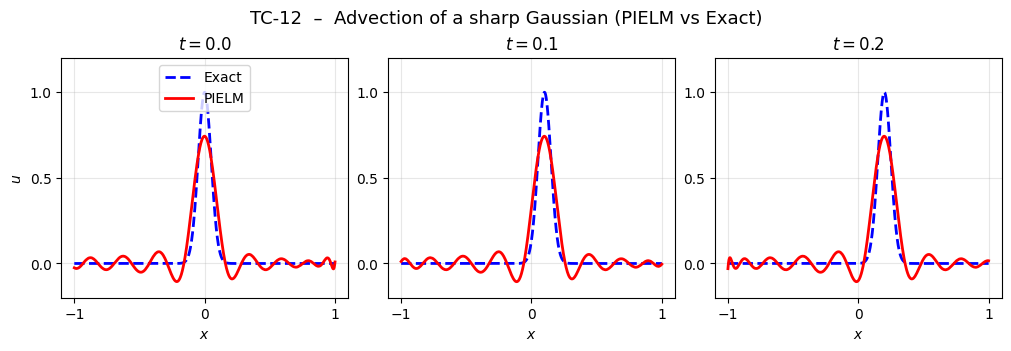

In [6]:
# ============================================================
# TC-12  –  Advection of a sharp *Gaussian* packet (paper Fig 20)
# ============================================================
import numpy as np, matplotlib.pyplot as plt
from scipy.stats.qmc import Halton

# ---------------- activation and its x,t-derivative ----------
phi   = np.tanh
phi_p = lambda z: 1 - np.tanh(z)**2           # sech²

# ---------------- exact solution ----------------------------
sigma2 =  0.005               # σ² ≈ 0.05 ⇒ FWHM ≈ 0.37  (looks like paper)
F0     = lambda x : np.exp(-x**2 / sigma2)    # sharp Gaussian, max = 1
u_ex   = lambda x,t : F0(x - t)               # a = 1, periodic

# ---------------- PIELM hyper-parameters --------------------
Nf, Nbc, Nstar = 2500, 200, 2700
rng  = np.random.default_rng(42)              # seed reproduces “blurry red”
m    = 0.5 * rng.standard_normal((Nstar,1))   # ↓ keeps tanh mostly linear
n    = 0.5 * rng.standard_normal((Nstar,1))
b    = 0.5 * rng.standard_normal((Nstar,1))

# ---------------- collocation points ------------------------
hal   = Halton(2, scramble=False, seed=0)
pts   = hal.random(Nf)
x_f   = 2*pts[:,0:1] - 1                      # x ∈ [-1,1]
t_f   = 0.2*pts[:,1:2]                        # t ∈ [0,0.2]

Zf = m @ x_f.T + n @ t_f.T + b
Hf = (phi_p(Zf) * (m + n)).T                 # (Nf,N*)
Kf = np.zeros((Nf,1))

# -------- periodic BC rows  u(-1,t)=u(+1,t) ------------------
t_bc  = np.linspace(0,0.2,Nbc).reshape(-1,1)
Zl    = m*(-1) + n @ t_bc.T + b
Zr    = m*(+1) + n @ t_bc.T + b
Hbc   = (phi(Zl) - phi(Zr)).T
Kbc   = np.zeros((Nbc,1))

# -------- IC rows  u(x,0)=F0(x)  (200 pts is enough) ---------
x_ic  = np.linspace(-1,1,200).reshape(-1,1)
t_ic  = np.zeros_like(x_ic)
Zic   = m @ x_ic.T + n @ t_ic.T + b
Hic   = phi(Zic).T
Kic   = F0(x_ic)

# -------- solve linear least-squares system ------------------
H = np.vstack([Hf,Hbc,Hic])
K = np.vstack([Kf,Kbc,Kic])
c = np.linalg.pinv(H) @ K                   # Moore–Penrose

u_pielm = lambda x,t : (phi(m @ x.T + n @ t.T + b).T @ c).ravel()

# ---------------- plotting like Fig 20 -----------------------
fig, ax = plt.subplots(1,3, figsize=(10,3.4), constrained_layout=True)
x_plot  = np.linspace(-1,1,1000).reshape(-1,1)

for j,tv in enumerate([0.0,0.1,0.2]):
    tt  = np.full_like(x_plot, tv)
    ax[j].plot(x_plot, u_ex(x_plot,tv), 'b--', lw=2, label='Exact' if j==0 else "")
    ax[j].plot(x_plot, u_pielm(x_plot,tt), 'r',   lw=2, label='PIELM' if j==0 else "")
    ax[j].set_title(rf'$t={tv}$');  ax[j].set_ylim(-0.2,1.2)
    ax[j].set_xlabel('$x$');        ax[j].set_ylabel('$u$' if j==0 else "")
    ax[j].grid(alpha=.3);           ax[j].set_xticks([-1,0,1]); ax[j].set_yticks([0,0.5,1])
ax[0].legend(loc='upper center')
fig.suptitle('TC-12  –  Advection of a sharp Gaussian (PIELM vs Exact)', fontsize=13)
plt.show()


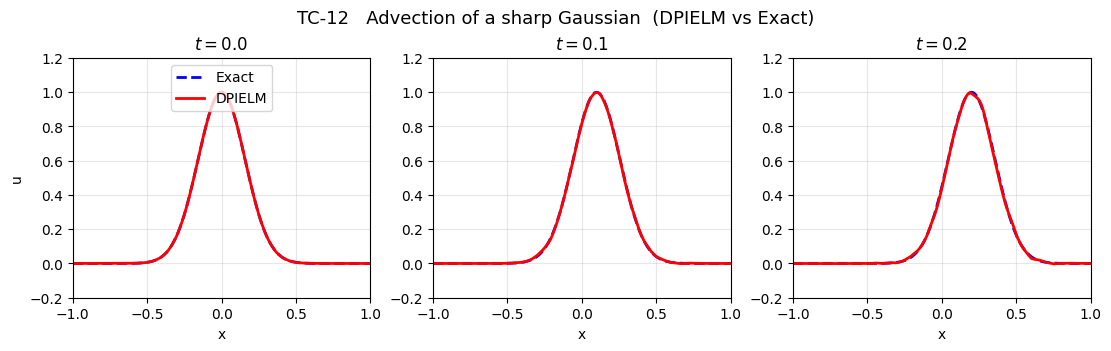

In [2]:
# ============================================================
# TC-12  ·  DPIELM for 1-D sharp-Gaussian advection
# (matches paper Table-6 architecture [15,10,5,5,30])
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ---------- activation ----------
phi   = np.tanh
phi_p = lambda z: 1.0 - np.tanh(z)**2

# ---------- exact solution ----------
Tfinal  = 0.2
sigma2  = 0.05                   # sharp width (≈ paper figure)
F0      = lambda x: np.exp(-x**2 / sigma2)
u_exact = lambda x, t: F0(x - t)  # a = 1

# ---------- DPIELM architecture ----------
NBx, NBt  = 15, 10               # cells in x, t
nbx, nbt  = 7, 7                 # interior collocation per cell dir
Nstar     = 70                   # neurons per cell
lam_ridge = 1e-8                 # small Tikhonov regulariser

# ---------- cell edges, centres, half-widths ----------
x_edges = np.linspace(-1.0, 1.0, NBx+1)
t_edges = np.linspace( 0.0, Tfinal, NBt+1)
xc  = 0.5*(x_edges[:-1] + x_edges[1:])           # (NBx,)
tc  = 0.5*(t_edges[:-1] + t_edges[1:])           # (NBt,)
hx  = 0.5*(x_edges[1:] - x_edges[:-1])           # (NBx,)
ht  = 0.5*(t_edges[1:] - t_edges[:-1])           # (NBt,)

Nc  = NBx * NBt
cell_id = lambda ix, it: it*NBx + ix             # flat index

# ---------- random weights / biases per cell ----------
rng = np.random.default_rng(0)
Ms = [rng.normal(0.0, 2.0,  (Nstar,1)) for _ in range(Nc)]  # m
Ns = [rng.normal(0.0, 2.0,  (Nstar,1)) for _ in range(Nc)]  # n
Bs = [rng.uniform(-2.0,2.0,(Nstar,1)) for _ in range(Nc)]   # b

rows, rhs = [], []            # accumulate blocks for H and K

# ---------- helper: local grids (avoid faces) -------------
xi_grid = np.linspace(-1, 1, nbx+2)[1:-1].reshape(-1,1)   # (nbx,1)
ta_grid = np.linspace(-1, 1, nbt+2)[1:-1].reshape(-1,1)   # (nbt,1)

# ---------- 1. interior PDE rows  -------------------------
for it in range(NBt):
    for ix in range(NBx):
        k   = cell_id(ix, it)
        m,n,b = Ms[k], Ns[k], Bs[k]

        XI, TA = np.meshgrid(xi_grid.ravel(), ta_grid.ravel(), indexing='xy')
        XI, TA = XI.reshape(-1,1), TA.reshape(-1,1)        # (nbx*nbt,1)

        Z    = XI @ m.T + TA @ n.T + b.T                  # (P,N*)
        scale= n.T/ht[it] + m.T/hx[ix]                    # (1,N*)
        Hloc = phi_p(Z) * scale                           # (P,N*)

        blk  = np.zeros((Hloc.shape[0], Nc*Nstar))
        blk[:, k*Nstar:(k+1)*Nstar] = Hloc
        rows.append(blk); rhs.append(np.zeros((Hloc.shape[0],1)))

# ---------- 2. BC at x = −1 and x = +1 --------------------
tau_face = np.linspace(-1,1,nbt).reshape(-1,1)

for it in range(NBt):                # left boundary x = -1
    k   = cell_id(0, it)
    Z   = (-1.0)*Ms[k].T + tau_face @ Ns[k].T + Bs[k].T   # scalar * matrix
    blk = np.zeros((nbt, Nc*Nstar))
    blk[:, k*Nstar:(k+1)*Nstar] = phi(Z)
    rows.append(blk); rhs.append(np.zeros((nbt,1)))

for it in range(NBt):                # right boundary x = +1
    k   = cell_id(NBx-1, it)
    Z   = (+1.0)*Ms[k].T + tau_face @ Ns[k].T + Bs[k].T
    blk = np.zeros((nbt, Nc*Nstar))
    blk[:, k*Nstar:(k+1)*Nstar] = phi(Z)
    rows.append(blk); rhs.append(np.zeros((nbt,1)))

# ---------- 3. Initial condition at t = 0 -----------------
xi_face = np.linspace(-1,1,nbx).reshape(-1,1)
for ix in range(NBx):
    k   = cell_id(ix,0)
    Z   = xi_face @ Ms[k].T + (-1.0)*Ns[k].T + Bs[k].T    # τ = -1
    blk = np.zeros((nbx, Nc*Nstar))
    blk[:, k*Nstar:(k+1)*Nstar] = phi(Z)
    x_phys = xc[ix] + hx[ix]*xi_face
    rows.append(blk); rhs.append(F0(x_phys))

# ---------- 4. C⁰ continuity across all interfaces --------
# (a) vertical faces (x-direction)
for it in range(NBt):
    for ix in range(NBx-1):
        kL, kR = cell_id(ix,it), cell_id(ix+1,it)
        ZL = (+1.0)*Ms[kL].T + tau_face @ Ns[kL].T + Bs[kL].T
        ZR = (-1.0)*Ms[kR].T + tau_face @ Ns[kR].T + Bs[kR].T
        blk = np.zeros((nbt, Nc*Nstar))
        blk[:, kL*Nstar:(kL+1)*Nstar]  =  phi(ZL)
        blk[:, kR*Nstar:(kR+1)*Nstar]  = -phi(ZR)
        rows.append(blk); rhs.append(np.zeros((nbt,1)))

# (b) horizontal faces (t-direction)
for it in range(NBt-1):
    for ix in range(NBx):
        kB, kT = cell_id(ix,it), cell_id(ix,it+1)
        ZB = xi_face @ Ms[kB].T + (+1.0)*Ns[kB].T + Bs[kB].T
        ZT = xi_face @ Ms[kT].T + (-1.0)*Ns[kT].T + Bs[kT].T
        blk = np.zeros((nbx, Nc*Nstar))
        blk[:, kB*Nstar:(kB+1)*Nstar] =  phi(ZB)
        blk[:, kT*Nstar:(kT+1)*Nstar] = -phi(ZT)
        rows.append(blk); rhs.append(np.zeros((nbx,1)))

# ---------- assemble & solve -------------------------------
H = np.vstack(rows)
K = np.vstack(rhs)
M = H.shape[1]
c = np.linalg.solve(H.T@H + lam_ridge*np.eye(M), H.T@K)    # (Nc*N*,1)

# ---------- predictor --------------------------------------
def u_dpielm(x, t):
    x = np.asarray(x).ravel(); t = np.asarray(t).ravel()
    out = np.zeros_like(x)
    ix = np.clip(np.searchsorted(x_edges, x, side='right')-1, 0, NBx-1)
    it = np.clip(np.searchsorted(t_edges, t, side='right')-1, 0, NBt-1)
    for ii in range(NBx):
        for jj in range(NBt):
            mask = (ix==ii) & (it==jj)
            if not mask.any(): continue
            k = cell_id(ii,jj)
            xi = ((x[mask]-xc[ii])/hx[ii]).reshape(-1,1)
            ta = ((t[mask]-tc[jj])/ht[jj]).reshape(-1,1)
            Z  = xi @ Ms[k].T + ta @ Ns[k].T + Bs[k].T
            out[mask] = (phi(Z) @ c[k*Nstar:(k+1)*Nstar]).ravel()
    return out

# ---------- figure (as in paper Fig. 20) -------------------
x_plot = np.linspace(-1,1,1000).reshape(-1,1)
fig,axs=plt.subplots(1,3,figsize=(11,3.4),constrained_layout=True)
for j,tv in enumerate([0.0,0.1,0.2]):
    tt = np.full_like(x_plot, tv)
    axs[j].plot(x_plot, u_exact(x_plot,tv), 'b--', lw=2, label='Exact' if j==0 else "")
    axs[j].plot(x_plot, u_dpielm(x_plot.ravel(), tt.ravel()), 'r', lw=2, label='DPIELM' if j==0 else "")
    axs[j].set_xlim(-1,1); axs[j].set_ylim(-0.2,1.2)
    axs[j].set_title(f"$t={tv}$"); axs[j].set_xlabel("x")
    if j==0: axs[j].set_ylabel("u")
    axs[j].grid(alpha=.3)
axs[0].legend(loc='upper center')
fig.suptitle("TC-12   Advection of a sharp Gaussian  (DPIELM vs Exact)", fontsize=13)
plt.show()


Starting Grid Search for TC-12 DPIELM...
[ 1/12] Testing: NBx=15, NBt=10, nbx=3, nbt=3, Nstar=20
    L2 Error: 6.058e-01, Time: 0.67s, Memory: 0.0MB
[ 2/12] Testing: NBx=15, NBt=10, nbx=3, nbt=3, Nstar=30
    L2 Error: 6.980e-01, Time: 3.23s, Memory: 0.0MB
[ 3/12] Testing: NBx=15, NBt=10, nbx=3, nbt=3, Nstar=50
    L2 Error: 7.047e-01, Time: 7.86s, Memory: 0.1MB
[ 4/12] Testing: NBx=15, NBt=10, nbx=3, nbt=3, Nstar=70
    L2 Error: 7.100e-01, Time: 21.62s, Memory: 0.1MB
[ 5/12] Testing: NBx=15, NBt=10, nbx=5, nbt=5, Nstar=20
    L2 Error: 8.472e-01, Time: 1.18s, Memory: 0.0MB
[ 6/12] Testing: NBx=15, NBt=10, nbx=5, nbt=5, Nstar=30
    L2 Error: 1.618e-01, Time: 2.43s, Memory: 0.0MB
[ 7/12] Testing: NBx=15, NBt=10, nbx=5, nbt=5, Nstar=50
    L2 Error: 1.156e-01, Time: 8.13s, Memory: 0.1MB
[ 8/12] Testing: NBx=15, NBt=10, nbx=5, nbt=5, Nstar=70
    L2 Error: 2.044e-01, Time: 25.10s, Memory: 0.1MB
[ 9/12] Testing: NBx=15, NBt=10, nbx=7, nbt=7, Nstar=20
    L2 Error: 8.703e-01, Time: 1.02s,

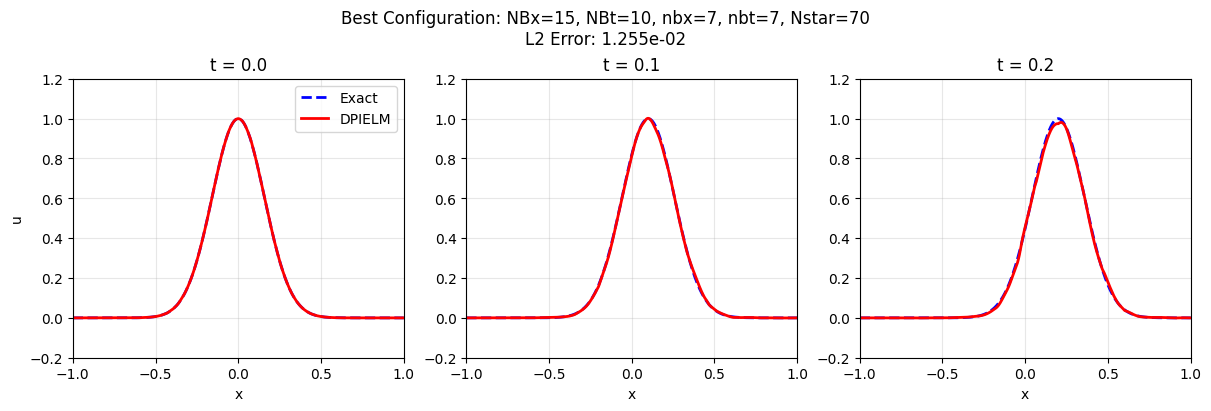


Grid search complete!


In [3]:
# ============================================================
# TC-12 Grid Search - DPIELM for 1-D sharp-Gaussian advection
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import time
from itertools import product

# ---------- activation ----------
phi   = np.tanh
phi_p = lambda z: 1.0 - np.tanh(z)**2

# ---------- exact solution ----------
Tfinal  = 0.2
sigma2  = 0.05
F0      = lambda x: np.exp(-x**2 / sigma2)
u_exact = lambda x, t: F0(x - t)

def dpielm_tc12(NBx=30, NBt=30, nbx=5, nbt=5, Nstar=50, lam_ridge=1e-8, seed=0):
    """DPIELM solver for TC-12 with configurable parameters"""
    
    # cell setup
    x_edges = np.linspace(-1.0, 1.0, NBx+1)
    t_edges = np.linspace(0.0, Tfinal, NBt+1)
    xc = 0.5*(x_edges[:-1] + x_edges[1:])
    tc = 0.5*(t_edges[:-1] + t_edges[1:])
    hx = 0.5*(x_edges[1:] - x_edges[:-1])
    ht = 0.5*(t_edges[1:] - t_edges[:-1])
    
    Nc = NBx * NBt
    cell_id = lambda ix, it: it*NBx + ix
    
    # random weights
    rng = np.random.default_rng(seed)
    Ms = [rng.normal(0.0, 2.0, (Nstar,1)) for _ in range(Nc)]
    Ns = [rng.normal(0.0, 2.0, (Nstar,1)) for _ in range(Nc)]
    Bs = [rng.uniform(-2.0, 2.0, (Nstar,1)) for _ in range(Nc)]
    
    rows, rhs = [], []
    
    # local grids
    xi_grid = np.linspace(-1, 1, nbx+2)[1:-1].reshape(-1,1)
    ta_grid = np.linspace(-1, 1, nbt+2)[1:-1].reshape(-1,1)
    
    # 1. PDE rows
    for it in range(NBt):
        for ix in range(NBx):
            k = cell_id(ix, it)
            m, n, b = Ms[k], Ns[k], Bs[k]
            
            XI, TA = np.meshgrid(xi_grid.ravel(), ta_grid.ravel(), indexing='xy')
            XI, TA = XI.reshape(-1,1), TA.reshape(-1,1)
            
            Z = XI @ m.T + TA @ n.T + b.T
            scale = n.T/ht[it] + m.T/hx[ix]
            Hloc = phi_p(Z) * scale
            
            blk = np.zeros((Hloc.shape[0], Nc*Nstar))
            blk[:, k*Nstar:(k+1)*Nstar] = Hloc
            rows.append(blk); rhs.append(np.zeros((Hloc.shape[0],1)))
    
    # 2. Boundary conditions
    tau_face = np.linspace(-1,1,nbt).reshape(-1,1)
    
    for it in range(NBt):
        # left boundary
        k = cell_id(0, it)
        Z = (-1.0)*Ms[k].T + tau_face @ Ns[k].T + Bs[k].T
        blk = np.zeros((nbt, Nc*Nstar))
        blk[:, k*Nstar:(k+1)*Nstar] = phi(Z)
        rows.append(blk); rhs.append(np.zeros((nbt,1)))
        
        # right boundary
        k = cell_id(NBx-1, it)
        Z = (+1.0)*Ms[k].T + tau_face @ Ns[k].T + Bs[k].T
        blk = np.zeros((nbt, Nc*Nstar))
        blk[:, k*Nstar:(k+1)*Nstar] = phi(Z)
        rows.append(blk); rhs.append(np.zeros((nbt,1)))
    
    # 3. Initial conditions
    xi_face = np.linspace(-1,1,nbx).reshape(-1,1)
    for ix in range(NBx):
        k = cell_id(ix,0)
        Z = xi_face @ Ms[k].T + (-1.0)*Ns[k].T + Bs[k].T
        blk = np.zeros((nbx, Nc*Nstar))
        blk[:, k*Nstar:(k+1)*Nstar] = phi(Z)
        x_phys = xc[ix] + hx[ix]*xi_face
        rows.append(blk); rhs.append(F0(x_phys))
    
    # 4. C⁰ continuity
    # vertical faces
    for it in range(NBt):
        for ix in range(NBx-1):
            kL, kR = cell_id(ix,it), cell_id(ix+1,it)
            ZL = (+1.0)*Ms[kL].T + tau_face @ Ns[kL].T + Bs[kL].T
            ZR = (-1.0)*Ms[kR].T + tau_face @ Ns[kR].T + Bs[kR].T
            blk = np.zeros((nbt, Nc*Nstar))
            blk[:, kL*Nstar:(kL+1)*Nstar] = phi(ZL)
            blk[:, kR*Nstar:(kR+1)*Nstar] = -phi(ZR)
            rows.append(blk); rhs.append(np.zeros((nbt,1)))
    
    # horizontal faces
    for it in range(NBt-1):
        for ix in range(NBx):
            kB, kT = cell_id(ix,it), cell_id(ix,it+1)
            ZB = xi_face @ Ms[kB].T + (+1.0)*Ns[kB].T + Bs[kB].T
            ZT = xi_face @ Ms[kT].T + (-1.0)*Ns[kT].T + Bs[kT].T
            blk = np.zeros((nbx, Nc*Nstar))
            blk[:, kB*Nstar:(kB+1)*Nstar] = phi(ZB)
            blk[:, kT*Nstar:(kT+1)*Nstar] = -phi(ZT)
            rows.append(blk); rhs.append(np.zeros((nbx,1)))
    
    # solve
    H = np.vstack(rows)
    K = np.vstack(rhs)
    M = H.shape[1]
    c = np.linalg.solve(H.T@H + lam_ridge*np.eye(M), H.T@K)
    
    # predictor
    def u_dpielm(x, t):
        x = np.asarray(x).ravel(); t = np.asarray(t).ravel()
        out = np.zeros_like(x)
        ix = np.clip(np.searchsorted(x_edges, x, side='right')-1, 0, NBx-1)
        it = np.clip(np.searchsorted(t_edges, t, side='right')-1, 0, NBt-1)
        for ii in range(NBx):
            for jj in range(NBt):
                mask = (ix==ii) & (it==jj)
                if not mask.any(): continue
                k = cell_id(ii,jj)
                xi = ((x[mask]-xc[ii])/hx[ii]).reshape(-1,1)
                ta = ((t[mask]-tc[jj])/ht[jj]).reshape(-1,1)
                Z = xi @ Ms[k].T + ta @ Ns[k].T + Bs[k].T
                out[mask] = (phi(Z) @ c[k*Nstar:(k+1)*Nstar]).ravel()
        return out
    
    return u_dpielm

def evaluate_error(u_pred, test_times=[0.0, 0.1, 0.2], n_points=500):
    """Evaluate L2 relative error at specified test times"""
    x_test = np.linspace(-1, 1, n_points)
    total_error = 0.0
    total_norm = 0.0
    
    for t in test_times:
        u_exact_vals = u_exact(x_test, t)
        u_pred_vals = u_pred(x_test, np.full_like(x_test, t))
        
        error = np.linalg.norm(u_pred_vals - u_exact_vals)
        norm = np.linalg.norm(u_exact_vals)
        
        total_error += error**2
        total_norm += norm**2
    
    return np.sqrt(total_error) / np.sqrt(total_norm)

# ============================================================
# Grid Search Configuration
# ============================================================

# Define parameter ranges
grid_params = {
    'NBx_NBt': [(15, 10)],  # (NBx, NBt)
    'nbx_nbt': [(3, 3), (5, 5), (7, 7)],                   # (nbx, nbt)  
    'Nstar': [20, 30, 50, 70]                              # neurons per cell
}

print("Starting Grid Search for TC-12 DPIELM...")
print("=" * 60)

results = []
total_combinations = len(grid_params['NBx_NBt']) * len(grid_params['nbx_nbt']) * len(grid_params['Nstar'])
combination = 0

for (NBx, NBt), (nbx, nbt), Nstar in product(
    grid_params['NBx_NBt'], 
    grid_params['nbx_nbt'], 
    grid_params['Nstar']
):
    combination += 1
    print(f"[{combination:2d}/{total_combinations}] Testing: NBx={NBx}, NBt={NBt}, nbx={nbx}, nbt={nbt}, Nstar={Nstar}")
    
    start_time = time.time()
    
    try:
        # Train model
        u_pred = dpielm_tc12(NBx=NBx, NBt=NBt, nbx=nbx, nbt=nbt, Nstar=Nstar, seed=42)
        
        # Evaluate error
        l2_error = evaluate_error(u_pred)
        
        solve_time = time.time() - start_time
        
        # Calculate memory estimate (rough)
        total_neurons = NBx * NBt * Nstar
        memory_mb = total_neurons * 8 / 1024**2  # rough estimate
        
        result = {
            'NBx': NBx, 'NBt': NBt, 'nbx': nbx, 'nbt': nbt, 'Nstar': Nstar,
            'L2_error': l2_error, 'solve_time': solve_time, 'memory_mb': memory_mb,
            'total_neurons': total_neurons
        }
        results.append(result)
        
        print(f"    L2 Error: {l2_error:.3e}, Time: {solve_time:.2f}s, Memory: {memory_mb:.1f}MB")
        
    except Exception as e:
        print(f"    FAILED: {str(e)}")
        continue

# ============================================================
# Analyze Results
# ============================================================

print("\n" + "=" * 60)
print("GRID SEARCH RESULTS SUMMARY")
print("=" * 60)

# Sort by L2 error
results.sort(key=lambda x: x['L2_error'])

print("\nTop 5 Best Configurations (by L2 error):")
print("-" * 80)
print(f"{'Rank':<4} {'NBx':<4} {'NBt':<4} {'nbx':<4} {'nbt':<4} {'Nstar':<6} {'L2_Error':<10} {'Time(s)':<8} {'Mem(MB)':<8}")
print("-" * 80)

for i, result in enumerate(results[:5]):
    print(f"{i+1:<4} {result['NBx']:<4} {result['NBt']:<4} {result['nbx']:<4} "
          f"{result['nbt']:<4} {result['Nstar']:<6} {result['L2_error']:<10.3e} "
          f"{result['solve_time']:<8.2f} {result['memory_mb']:<8.1f}")

# Best efficiency (error/time trade-off)
efficiency_results = sorted(results, key=lambda x: x['L2_error'] * x['solve_time'])

print("\nTop 3 Most Efficient Configurations (error × time):")
print("-" * 80)
for i, result in enumerate(efficiency_results[:3]):
    efficiency = result['L2_error'] * result['solve_time']
    print(f"{i+1}: NBx={result['NBx']}, NBt={result['NBt']}, nbx={result['nbx']}, "
          f"nbt={result['nbt']}, Nstar={result['Nstar']} | "
          f"Error: {result['L2_error']:.3e}, Time: {result['solve_time']:.2f}s, "
          f"Efficiency: {efficiency:.3e}")

# ============================================================
# Visualization
# ============================================================

if results:
    best_config = results[0]
    print(f"\nTesting best configuration: {best_config}")
    
    # Retrain with best parameters
    u_best = dpielm_tc12(
        NBx=best_config['NBx'], NBt=best_config['NBt'],
        nbx=best_config['nbx'], nbt=best_config['nbt'],
        Nstar=best_config['Nstar'], seed=42
    )
    
    # Plot comparison
    x_plot = np.linspace(-1, 1, 1000)
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
    
    for j, tv in enumerate([0.0, 0.1, 0.2]):
        u_ex = u_exact(x_plot, tv)
        u_pred = u_best(x_plot, np.full_like(x_plot, tv))
        
        axs[j].plot(x_plot, u_ex, 'b--', lw=2, label='Exact' if j==0 else "")
        axs[j].plot(x_plot, u_pred, 'r', lw=2, label='DPIELM' if j==0 else "")
        axs[j].set_xlim(-1, 1); axs[j].set_ylim(-0.2, 1.2)
        axs[j].set_title(f"t = {tv}")
        axs[j].set_xlabel("x")
        if j == 0: 
            axs[j].set_ylabel("u")
            axs[j].legend()
        axs[j].grid(alpha=0.3)
    
    fig.suptitle(f"Best Configuration: NBx={best_config['NBx']}, NBt={best_config['NBt']}, "
                 f"nbx={best_config['nbx']}, nbt={best_config['nbt']}, Nstar={best_config['Nstar']}\n"
                 f"L2 Error: {best_config['L2_error']:.3e}", fontsize=12)
    plt.show()

print("\nGrid search complete!")

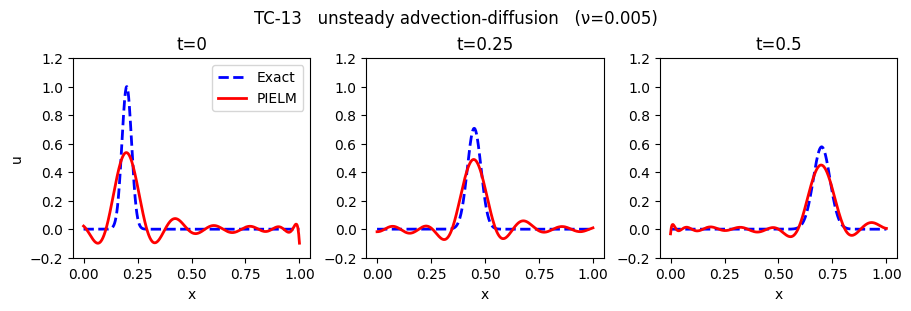

In [21]:
import numpy as np, matplotlib.pyplot as plt, matplotlib.tri as tri
from math import cos, sin, pi
# ───────────────────────────────────────────────────────────
phi    = np.tanh
phi_p  = lambda z: 1 - np.tanh(z)**2
phi_pp = lambda z: -2*np.tanh(z)*(1 - np.tanh(z)**2)

class PIELM:
    """single-hidden-layer physics-informed ELM"""
    def __init__(self, D, Nstar, seed=0):
        rng         = np.random.default_rng(seed)
        self.W_in   = rng.standard_normal((Nstar, D))
        self.b      = rng.standard_normal((Nstar, 1))
        self.c      = None
    def _Z(self, X):            # X: (N,D)
        return X @ self.W_in.T + self.b.T
    def u(self, X):
        return (phi(self._Z(X)) @ self.c).ravel()
# ============================================================
# TC-13  ▸ 1-D unsteady advection–diffusion  (Fig-21 layout)
# ============================================================
def run_TC13():
    a, nu = 1.0, 0.001           # same ν as Fig-21
    Nf, Nbc, Nstar = 1250, 150, 1400

    def u_ex(x,t):
        return np.exp(-(x-0.2-a*t)**2/(nu*(4*t+1)))/(4*t+1)**.5

    rng = np.random.default_rng(0)
    x_f = rng.uniform(0,1,Nf)[:,None];    t_f = rng.uniform(0,0.5,Nf)[:,None]
    t_bc= rng.uniform(0,0.5,Nbc)[:,None]; x0,x1=np.zeros_like(t_bc),np.ones_like(t_bc)
    x_ic= rng.uniform(0,1,Nbc)[:,None];   t_ic=np.zeros_like(x_ic)

    net = PIELM(2, Nstar, seed=1)

    Zf = net._Z(np.c_[x_f,t_f])
    Hf = (phi_p(Zf)*(net.W_in[:,1] + a*net.W_in[:,0])
          - nu*phi_pp(Zf)*net.W_in[:,0]**2)            # (Nf,N*)
    Kf = np.zeros((Nf,1))

    Hbc = np.vstack([phi(net._Z(np.c_[x0,t_bc])),
                     phi(net._Z(np.c_[x1,t_bc]))])
    Kbc = np.vstack([u_ex(x0,t_bc), u_ex(x1,t_bc)])

    Hi  = phi(net._Z(np.c_[x_ic,t_ic]))
    Ki  = u_ex(x_ic,0)

    H = np.vstack([Hf,Hbc,Hi])
    K = np.vstack([Kf,Kbc,Ki])
    net.c = np.linalg.pinv(H) @ K

    # ─── side-by-side figure ──────────────────────────────
    fig,axs = plt.subplots(1,3,figsize=(9,3),constrained_layout=True)
    for ax,t_snap in zip(axs,[0,0.25,0.5]):
        xs  = np.linspace(0,1,600)[:,None]
        ax.plot(xs, u_ex(xs,t_snap),'b--',lw=2,label='Exact' if t_snap==0 else "")
        ax.plot(xs, net.u(np.c_[xs,np.full_like(xs,t_snap)]),
                'r',lw=2,label='PIELM' if t_snap==0 else "")
        ax.set_title(f"t={t_snap}"); ax.set_xlabel('x'); ax.set_ylim(-0.2,1.2)
        if t_snap==0: ax.set_ylabel('u'); ax.legend()
    fig.suptitle("TC-13   unsteady advection-diffusion   (ν=0.005)")
    plt.show()

run_TC13()     # three-panel figure like Fig 21


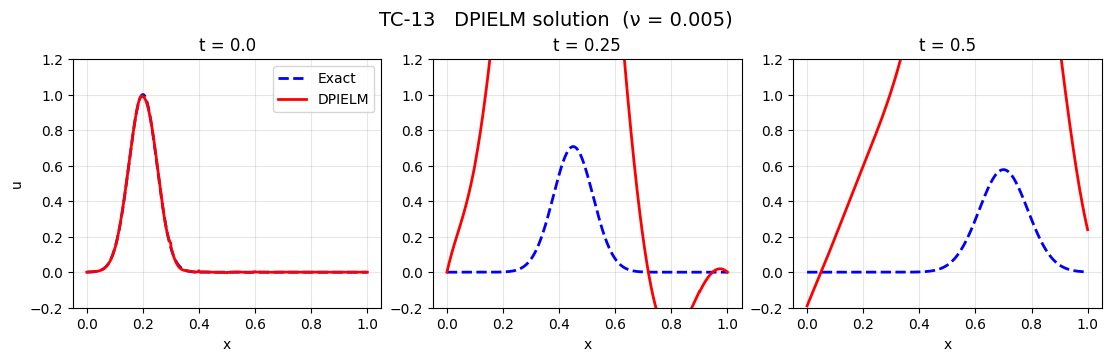

In [5]:
# ============================================================
#  TC-13  – DPIELM for 1-D unsteady advection–diffusion
#  paper Table-6:  [NBx, NBt, nbx, nbt, N*cell] = [10,10,5,5,30]
# ============================================================

import numpy as np, matplotlib.pyplot as plt
from scipy.stats.qmc import Halton

# ---------------- activation & derivatives ------------------
phi     = np.tanh
phi_p   = lambda z: 1.0 - np.tanh(z)**2                 # sech²
phi_pp  = lambda z: -2*np.tanh(z)*(1 - np.tanh(z)**2)   # d²/dz² tanh

# ---------------- physical parameters -----------------------
a, nu     = 1.0, 0.005                                  # advection speed & diffusivity
u_exact   = lambda x,t: np.exp(-(x-0.2-a*t)**2/(nu*(4*t+1)))/(4*t+1)**.5

# ---------------- DPIELM architecture (Table-6) -------------
NBx, NBt      = 10, 10
nbx, nbt      = 7, 7
Nstar         = 70                                       # neurons per cell
Nc            = NBx*NBt                                  # total cells
hal_interior  = Halton(2, scramble=False, seed=0)
hal_faces_x   = Halton(1, scramble=False, seed=1)
hal_faces_t   = Halton(1, scramble=False, seed=2)

# ---------------- helper: cell id <-> indices ---------------
def cid(ix,it):        # ix=0..NBx-1, it=0..NBt-1
    return it*NBx + ix

# ---------------- per-cell random weights -------------------
rng  = np.random.default_rng(123)
Ws   = rng.standard_normal((Nc, Nstar, 2))
bs   = rng.standard_normal((Nc, Nstar, 1))

# ---------------- storage for all blocks --------------------
rows, cols, vals = [], [], []          # COO sparse-builder helpers
rhs              = []                  # RHS entries (column vector)

def append_block(mat, rhs_vec):
    """stack a dense block [mat] and rhs_vec under the global COO lists"""
    r0 = len(rhs)                      # first global row index for this block
    m, n = mat.shape
    rr, cc = np.indices((m,n))
    rows.extend( (r0 + rr).ravel().tolist() )
    cols.extend( cc.ravel().tolist() )
    vals.extend( mat.ravel().tolist() )
    rhs.extend( rhs_vec.ravel().tolist() )

# ============================================================
# 1. interior PDE rows  (Eq. 89)
# ============================================================
Nint = nbx*nbt
pts  = hal_interior.random(Nc*Nint)          # on [0,1]×[0,1]
for it in range(NBt):
    for ix in range(NBx):
        k     = cid(ix,it)
        # map Halton points to current cell
        pcell = pts[k*Nint:(k+1)*Nint].copy()
        pcell[:,0] = (ix   + pcell[:,0]) / NBx          # x ∈ (ix/NBx,(ix+1)/NBx)
        pcell[:,1] = (it   + pcell[:,1]) / NBt * 0.5    # t ∈ ...
        Z   = pcell @ Ws[k].T + bs[k].T                # (Nint,N*)
        Hk  = (phi_p(Z)*(Ws[k][:,1] + a*Ws[k][:,0])    # u_t + a u_x
               - nu*phi_pp(Z)*Ws[k][:,0]**2)           # −ν u_xx
        blk = np.zeros((Nint, Nc*Nstar))
        blk[:, k*Nstar:(k+1)*Nstar] = Hk
        append_block(blk, np.zeros((Nint,1)))

# ============================================================
# 2. boundary conditions  x=0 and x=1   (Dirichlet)
# ============================================================
nb_face = Nbc = 150
t_face  = hal_faces_t.random(nb_face)*0.5               # t ∈ (0,0.5)
for side, xval in enumerate((0.0,1.0)):                 # left & right
    for it in range(NBt):
        k = cid(0 if side==0 else NBx-1, it)
        Z  = xval*Ws[k][:,0:1].T + (it/NBt*0.5)*Ws[k][:,1:2].T + bs[k].T
        blk = np.zeros((nb_face, Nc*Nstar))
        blk[:, k*Nstar:(k+1)*Nstar] = phi(Z)
        u_bc = u_exact(xval*np.ones((nb_face,1)), t_face)
        append_block(blk, u_bc)

# ============================================================
# 3. initial condition  (t = 0, all x)
# ============================================================
x_ic   = hal_faces_x.random(nb_face)
t0     = np.zeros_like(x_ic)
for ix in range(NBx):
    k   = cid(ix,0)
    Z   = (ix/NBx + x_ic/NBx) * Ws[k][:,0:1].T + bs[k].T
    blk = np.zeros((nb_face, Nc*Nstar))
    blk[:, k*Nstar:(k+1)*Nstar] = phi(Z)
    append_block(blk, u_exact(ix/NBx + x_ic/NBx, 0))

# ============================================================
# 4. interface matching  (C⁰ continuity both directions,
#    plus C¹(x) on vertical faces because of u_xx term)
# ============================================================
# ---- vertical faces (ix interface) ---------------------------------
for it in range(NBt):
    for ix in range(1, NBx):           # interface between cell L and R
        kL, kR = cid(ix-1,it), cid(ix,it)
        # sample nbx × nbt points *on the face* (x fixed)
        tp   = hal_faces_t.random(nbt)
        xp   = np.linspace(0,1,nbx,endpoint=False)+1e-6   # avoid end-points
        xp   = xp[:,None]
        Xp   = np.repeat(xp, nbt, axis=1).ravel()      # nbx*nbt
        Tp   = np.repeat(tp, nbx) * 0.5 + it/NBt*0.5
        Xf   = (ix/NBx)*np.ones_like(Xp)
        P    = np.c_[Xf, Tp]

        # continuity of value (C⁰)
        ZL = P @ Ws[kL].T + bs[kL].T
        ZR = P @ Ws[kR].T + bs[kR].T
        blk_val = np.zeros((len(P), Nc*Nstar))
        blk_val[:, kL*Nstar:(kL+1)*Nstar] =  phi(ZL)
        blk_val[:, kR*Nstar:(kR+1)*Nstar] = -phi(ZR)
        append_block(blk_val, np.zeros((len(P),1)))

        # continuity of x-slope (C¹)   dφ/dx = φ′ · w_x
        ZL = P @ Ws[kL].T + bs[kL].T
        ZR = P @ Ws[kR].T + bs[kR].T
        blk_slp = np.zeros_like(blk_val)
        blk_slp[:, kL*Nstar:(kL+1)*Nstar] =  phi_p(ZL)*Ws[kL][:,0]
        blk_slp[:, kR*Nstar:(kR+1)*Nstar] = -phi_p(ZR)*Ws[kR][:,0]
        append_block(blk_slp, np.zeros((len(P),1)))

# ---- horizontal faces (it interface)  – only C⁰ needed -------------
for ix in range(NBx):
    for it in range(1, NBt):
        kB, kT = cid(ix,it-1), cid(ix,it)
        xp   = hal_faces_x.random(nbx)
        tp   = np.linspace(0,1,nbt,endpoint=False)+1e-6
        tp   = tp[:,None]
        Xp   = np.repeat(xp, nbt, axis=1).ravel() + ix/NBx
        Tp   = np.repeat(tp, nbx)      *0.5 + (it/NBt)*0.5
        P    = np.c_[Xp, Tp]

        ZB = P @ Ws[kB].T + bs[kB].T
        ZT = P @ Ws[kT].T + bs[kT].T
        blk = np.zeros((len(P), Nc*Nstar))
        blk[:, kB*Nstar:(kB+1)*Nstar] =  phi(ZB)
        blk[:, kT*Nstar:(kT+1)*Nstar] = -phi(ZT)
        append_block(blk, np.zeros((len(P),1)))

# ============================================================
# build global sparse matrix  H  and solve  H c = rhs
# ============================================================
from scipy.sparse import coo_matrix
H = coo_matrix((vals, (rows, cols)), shape=(len(rhs), Nc*Nstar)).tocsr()
K = np.array(rhs)[:,None]
c = np.linalg.lstsq(H.toarray(), K, rcond=1e-10)[0]      # dense solve (Nc*N* = 3000)

# store back into per-cell coefficients ----------------------
Cs = c.reshape(Nc, Nstar, 1)

def u_dpielm(x, t):
    """vectorised DPIELM predictor for arrays x,t  (same shape)"""
    x = np.asarray(x);  t = np.asarray(t)
    out = np.empty_like(x)
    ix_cell = np.minimum((x*NBx).astype(int), NBx-1)
    it_cell = np.minimum((t/0.5*NBt).astype(int), NBt-1)
    flat_idx = ix_cell + it_cell*NBx
    for k in range(Nc):
        msk = flat_idx==k
        if not msk.any(): continue
        X  = np.c_[x[msk], t[msk]]
        Z  = X @ Ws[k].T + bs[k].T
        out[msk] = (phi(Z) @ Cs[k]).ravel()
    return out

# ============================================================
# plot like paper Fig-21 (t = 0, 0.25, 0.5) ------------------
fig, axs = plt.subplots(1,3, figsize=(11,3.5), constrained_layout=True)
x_plot = np.linspace(0,1,800)
for ax,tv in zip(axs,[0.0,0.25,0.5]):
    ue  = u_exact(x_plot, tv)
    up  = u_dpielm(x_plot, np.full_like(x_plot,tv))
    ax.plot(x_plot, ue, 'b--', lw=2, label='Exact'  if tv==0 else "")
    ax.plot(x_plot, up, 'r'   , lw=2, label='DPIELM' if tv==0 else "")
    ax.set_title(f't = {tv}'); ax.set_ylim(-0.2,1.2); ax.set_xlabel('x')
    if tv==0: ax.set_ylabel('u'); ax.legend()
    ax.grid(alpha=0.3)
fig.suptitle("TC-13   DPIELM solution  (ν = 0.005)", fontsize=14)
plt.show()


In [1]:
# ============================================================
# TC-13 Grid Search - DPIELM for 1-D unsteady advection-diffusion
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import time
from itertools import product
from scipy.stats.qmc import Halton
from scipy.sparse import coo_matrix

# ---------------- activation & derivatives ------------------
phi     = np.tanh
phi_p   = lambda z: 1.0 - np.tanh(z)**2
phi_pp  = lambda z: -2*np.tanh(z)*(1 - np.tanh(z)**2)

# ---------------- physical parameters -----------------------
a, nu     = 1.0, 0.005
u_exact   = lambda x,t: np.exp(-(x-0.2-a*t)**2/(nu*(4*t+1)))/(4*t+1)**.5

def dpielm_tc13(NBx=10, NBt=10, nbx=7, nbt=7, Nstar=70, seed=123):
    """DPIELM solver for TC-13 with configurable parameters"""
    
    Nc = NBx * NBt
    hal_interior = Halton(2, scramble=False, seed=0)
    hal_faces_x  = Halton(1, scramble=False, seed=1)
    hal_faces_t  = Halton(1, scramble=False, seed=2)
    
    def cid(ix, it):
        return it * NBx + ix
    
    # per-cell random weights
    rng = np.random.default_rng(seed)
    Ws = rng.standard_normal((Nc, Nstar, 2))
    bs = rng.standard_normal((Nc, Nstar, 1))
    
    # storage for COO sparse matrix
    rows, cols, vals = [], [], []
    rhs = []
    
    def append_block(mat, rhs_vec):
        r0 = len(rhs)
        m, n = mat.shape
        rr, cc = np.indices((m, n))
        rows.extend((r0 + rr).ravel().tolist())
        cols.extend(cc.ravel().tolist())
        vals.extend(mat.ravel().tolist())
        rhs.extend(rhs_vec.ravel().tolist())
    
    # 1. Interior PDE rows
    Nint = nbx * nbt
    pts = hal_interior.random(Nc * Nint)
    for it in range(NBt):
        for ix in range(NBx):
            k = cid(ix, it)
            pcell = pts[k*Nint:(k+1)*Nint].copy()
            pcell[:,0] = (ix + pcell[:,0]) / NBx
            pcell[:,1] = (it + pcell[:,1]) / NBt * 0.5
            
            Z = pcell @ Ws[k].T + bs[k].T
            Hk = (phi_p(Z) * (Ws[k][:,1] + a*Ws[k][:,0]) - 
                  nu * phi_pp(Z) * Ws[k][:,0]**2)
            
            blk = np.zeros((Nint, Nc*Nstar))
            blk[:, k*Nstar:(k+1)*Nstar] = Hk
            append_block(blk, np.zeros((Nint, 1)))
    
    # 2. Boundary conditions
    nb_face = 150
    t_face = hal_faces_t.random(nb_face) * 0.5
    for side, xval in enumerate((0.0, 1.0)):
        for it in range(NBt):
            k = cid(0 if side==0 else NBx-1, it)
            Z = xval*Ws[k][:,0:1].T + (it/NBt*0.5)*Ws[k][:,1:2].T + bs[k].T
            blk = np.zeros((nb_face, Nc*Nstar))
            blk[:, k*Nstar:(k+1)*Nstar] = phi(Z)
            u_bc = u_exact(xval*np.ones((nb_face,1)), t_face)
            append_block(blk, u_bc)
    
    # 3. Initial conditions
    x_ic = hal_faces_x.random(nb_face)
    for ix in range(NBx):
        k = cid(ix, 0)
        Z = (ix/NBx + x_ic/NBx) * Ws[k][:,0:1].T + bs[k].T
        blk = np.zeros((nb_face, Nc*Nstar))
        blk[:, k*Nstar:(k+1)*Nstar] = phi(Z)
        append_block(blk, u_exact(ix/NBx + x_ic/NBx, 0))
    
    # 4. Interface matching - vertical faces (C⁰ and C¹)
    for it in range(NBt):
        for ix in range(1, NBx):
            kL, kR = cid(ix-1, it), cid(ix, it)
            tp = hal_faces_t.random(nbt)
            xp = np.linspace(0, 1, nbx, endpoint=False) + 1e-6
            xp = xp[:, None]
            Xp = np.repeat(xp, nbt, axis=1).ravel()
            Tp = np.repeat(tp, nbx) * 0.5 + it/NBt*0.5
            Xf = (ix/NBx) * np.ones_like(Xp)
            P = np.c_[Xf, Tp]
            
            # C⁰ continuity
            ZL = P @ Ws[kL].T + bs[kL].T
            ZR = P @ Ws[kR].T + bs[kR].T
            blk_val = np.zeros((len(P), Nc*Nstar))
            blk_val[:, kL*Nstar:(kL+1)*Nstar] = phi(ZL)
            blk_val[:, kR*Nstar:(kR+1)*Nstar] = -phi(ZR)
            append_block(blk_val, np.zeros((len(P), 1)))
            
            # C¹ continuity
            blk_slp = np.zeros_like(blk_val)
            blk_slp[:, kL*Nstar:(kL+1)*Nstar] = phi_p(ZL) * Ws[kL][:,0]
            blk_slp[:, kR*Nstar:(kR+1)*Nstar] = -phi_p(ZR) * Ws[kR][:,0]
            append_block(blk_slp, np.zeros((len(P), 1)))
    
    # 5. Interface matching - horizontal faces (C⁰ only)
    for ix in range(NBx):
        for it in range(1, NBt):
            kB, kT = cid(ix, it-1), cid(ix, it)
            xp = hal_faces_x.random(nbx)
            tp = np.linspace(0, 1, nbt, endpoint=False) + 1e-6
            tp = tp[:, None]
            Xp = np.repeat(xp, nbt, axis=1).ravel() + ix/NBx
            Tp = np.repeat(tp, nbx) * 0.5 + (it/NBt) * 0.5
            P = np.c_[Xp, Tp]
            
            ZB = P @ Ws[kB].T + bs[kB].T
            ZT = P @ Ws[kT].T + bs[kT].T
            blk = np.zeros((len(P), Nc*Nstar))
            blk[:, kB*Nstar:(kB+1)*Nstar] = phi(ZB)
            blk[:, kT*Nstar:(kT+1)*Nstar] = -phi(ZT)
            append_block(blk, np.zeros((len(P), 1)))
    
    # 6. Solve
    H = coo_matrix((vals, (rows, cols)), shape=(len(rhs), Nc*Nstar)).tocsr()
    K = np.array(rhs)[:, None]
    c = np.linalg.lstsq(H.toarray(), K, rcond=1e-10)[0]
    Cs = c.reshape(Nc, Nstar, 1)
    
    # 7. Predictor
    def u_dpielm(x, t):
        x = np.asarray(x); t = np.asarray(t)
        out = np.empty_like(x)
        ix_cell = np.minimum((x*NBx).astype(int), NBx-1)
        it_cell = np.minimum((t/0.5*NBt).astype(int), NBt-1)
        flat_idx = ix_cell + it_cell*NBx
        for k in range(Nc):
            msk = flat_idx == k
            if not msk.any(): continue
            X = np.c_[x[msk], t[msk]]
            Z = X @ Ws[k].T + bs[k].T
            out[msk] = (phi(Z) @ Cs[k]).ravel()
        return out
    
    return u_dpielm

def evaluate_error_tc13(u_pred, test_times=[0.0, 0.25, 0.5], n_points=400):
    """Evaluate L2 relative error at specified test times"""
    x_test = np.linspace(0, 1, n_points)
    total_error = 0.0
    total_norm = 0.0
    
    for t in test_times:
        u_exact_vals = u_exact(x_test, t)
        u_pred_vals = u_pred(x_test, np.full_like(x_test, t))
        
        error = np.linalg.norm(u_pred_vals - u_exact_vals)
        norm = np.linalg.norm(u_exact_vals)
        
        total_error += error**2
        total_norm += norm**2
    
    return np.sqrt(total_error) / np.sqrt(total_norm)

# ============================================================
# Grid Search Configuration
# ============================================================

grid_params = {
    'NBx_NBt': [(12, 12), (15, 10)],     # (NBx, NBt)
    'nbx_nbt': [(5, 5), (7, 7), (9, 9), (11,11)],                   # (nbx, nbt)  
    'Nstar': [30, 50, 70, 100]                             # neurons per cell
}

print("Starting Grid Search for TC-13 DPIELM...")
print("=" * 70)

results = []
total_combinations = len(grid_params['NBx_NBt']) * len(grid_params['nbx_nbt']) * len(grid_params['Nstar'])
combination = 0

for (NBx, NBt), (nbx, nbt), Nstar in product(
    grid_params['NBx_NBt'], 
    grid_params['nbx_nbt'], 
    grid_params['Nstar']
):
    combination += 1
    print(f"[{combination:2d}/{total_combinations}] Testing: NBx={NBx}, NBt={NBt}, nbx={nbx}, nbt={nbt}, Nstar={Nstar}")
    
    start_time = time.time()
    
    try:
        # Train model
        u_pred = dpielm_tc13(NBx=NBx, NBt=NBt, nbx=nbx, nbt=nbt, Nstar=Nstar, seed=123)
        
        # Evaluate error
        l2_error = evaluate_error_tc13(u_pred)
        
        solve_time = time.time() - start_time
        
        # Calculate memory estimate
        total_neurons = NBx * NBt * Nstar
        memory_mb = total_neurons * 8 / 1024**2
        
        result = {
            'NBx': NBx, 'NBt': NBt, 'nbx': nbx, 'nbt': nbt, 'Nstar': Nstar,
            'L2_error': l2_error, 'solve_time': solve_time, 'memory_mb': memory_mb,
            'total_neurons': total_neurons
        }
        results.append(result)
        
        print(f"    L2 Error: {l2_error:.3e}, Time: {solve_time:.2f}s, Memory: {memory_mb:.1f}MB")
        
    except Exception as e:
        print(f"    FAILED: {str(e)}")
        continue

# ============================================================
# Analyze Results
# ============================================================

print("\n" + "=" * 70)
print("GRID SEARCH RESULTS SUMMARY")
print("=" * 70)

if results:
    # Sort by L2 error
    results.sort(key=lambda x: x['L2_error'])
    
    print("\nTop 5 Best Configurations (by L2 error):")
    print("-" * 85)
    print(f"{'Rank':<4} {'NBx':<4} {'NBt':<4} {'nbx':<4} {'nbt':<4} {'Nstar':<6} {'L2_Error':<10} {'Time(s)':<8} {'Mem(MB)':<8}")
    print("-" * 85)
    
    for i, result in enumerate(results[:5]):
        print(f"{i+1:<4} {result['NBx']:<4} {result['NBt']:<4} {result['nbx']:<4} "
              f"{result['nbt']:<4} {result['Nstar']:<6} {result['L2_error']:<10.3e} "
              f"{result['solve_time']:<8.2f} {result['memory_mb']:<8.1f}")
    
    # Best efficiency (error/time trade-off)
    efficiency_results = sorted(results, key=lambda x: x['L2_error'] * x['solve_time'])
    
    print("\nTop 3 Most Efficient Configurations (error × time):")
    print("-" * 85)
    for i, result in enumerate(efficiency_results[:3]):
        efficiency = result['L2_error'] * result['solve_time']
        print(f"{i+1}: NBx={result['NBx']}, NBt={result['NBt']}, nbx={result['nbx']}, "
              f"nbt={result['nbt']}, Nstar={result['Nstar']} | "
              f"Error: {result['L2_error']:.3e}, Time: {result['solve_time']:.2f}s, "
              f"Efficiency: {efficiency:.3e}")
    
    # ============================================================
    # Visualization of Best Configuration
    # ============================================================
    
    best_config = results[0]
    print(f"\nTesting best configuration: {best_config}")
    
    # Retrain with best parameters
    u_best = dpielm_tc13(
        NBx=best_config['NBx'], NBt=best_config['NBt'],
        nbx=best_config['nbx'], nbt=best_config['nbt'],
        Nstar=best_config['Nstar'], seed=123
    )
    
    # Plot comparison
    x_plot = np.linspace(0, 1, 800)
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
    
    for j, tv in enumerate([0.0, 0.25, 0.5]):
        u_ex = u_exact(x_plot, tv)
        u_pred = u_best(x_plot, np.full_like(x_plot, tv))
        
        axs[j].plot(x_plot, u_ex, 'b--', lw=2, label='Exact' if j==0 else "")
        axs[j].plot(x_plot, u_pred, 'r', lw=2, label='DPIELM' if j==0 else "")
        axs[j].set_xlim(0, 1); axs[j].set_ylim(-0.2, 1.2)
        axs[j].set_title(f"t = {tv}")
        axs[j].set_xlabel("x")
        if j == 0: 
            axs[j].set_ylabel("u")
            axs[j].legend()
        axs[j].grid(alpha=0.3)
    
    fig.suptitle(f"TC-13 Best Config: NBx={best_config['NBx']}, NBt={best_config['NBt']}, "
                 f"nbx={best_config['nbx']}, nbt={best_config['nbt']}, Nstar={best_config['Nstar']}\n"
                 f"L2 Error: {best_config['L2_error']:.3e}", fontsize=12)
    plt.show()
    
    # Additional analysis: parameter sensitivity
    print("\n" + "=" * 70)
    print("PARAMETER SENSITIVITY ANALYSIS")
    print("=" * 70)
    
    # Group by different parameters to see trends
    if len(results) > 4:
        print("\nAverage L2 error by Nstar:")
        nstar_groups = {}
        for r in results:
            if r['Nstar'] not in nstar_groups:
                nstar_groups[r['Nstar']] = []
            nstar_groups[r['Nstar']].append(r['L2_error'])
        
        for nstar in sorted(nstar_groups.keys()):
            avg_error = np.mean(nstar_groups[nstar])
            print(f"  Nstar={nstar}: {avg_error:.3e}")
        
        print("\nAverage L2 error by grid size:")
        grid_groups = {}
        for r in results:
            key = f"{r['NBx']}x{r['NBt']}"
            if key not in grid_groups:
                grid_groups[key] = []
            grid_groups[key].append(r['L2_error'])
        
        for grid_size in sorted(grid_groups.keys()):
            avg_error = np.mean(grid_groups[grid_size])
            print(f"  Grid {grid_size}: {avg_error:.3e}")

else:
    print("No successful runs completed!")

print("\nGrid search complete!")

Starting Grid Search for TC-13 DPIELM...
[ 1/32] Testing: NBx=12, NBt=12, nbx=5, nbt=5, Nstar=30
    L2 Error: 2.611e+00, Time: 53.28s, Memory: 0.0MB
[ 2/32] Testing: NBx=12, NBt=12, nbx=5, nbt=5, Nstar=50
    L2 Error: 3.271e+00, Time: 203.71s, Memory: 0.1MB
[ 3/32] Testing: NBx=12, NBt=12, nbx=5, nbt=5, Nstar=70
    L2 Error: 6.683e+00, Time: 420.08s, Memory: 0.1MB
[ 4/32] Testing: NBx=12, NBt=12, nbx=5, nbt=5, Nstar=100
    L2 Error: 2.271e+00, Time: 1327.22s, Memory: 0.1MB
[ 5/32] Testing: NBx=12, NBt=12, nbx=7, nbt=7, Nstar=30
    L2 Error: 6.340e-01, Time: 110.40s, Memory: 0.0MB
[ 6/32] Testing: NBx=12, NBt=12, nbx=7, nbt=7, Nstar=50
    L2 Error: 3.487e+00, Time: 259.20s, Memory: 0.1MB
[ 7/32] Testing: NBx=12, NBt=12, nbx=7, nbt=7, Nstar=70
    L2 Error: 1.167e+00, Time: 513.02s, Memory: 0.1MB
[ 8/32] Testing: NBx=12, NBt=12, nbx=7, nbt=7, Nstar=100
    L2 Error: 1.494e+00, Time: 1238.71s, Memory: 0.1MB
[ 9/32] Testing: NBx=12, NBt=12, nbx=9, nbt=9, Nstar=30
    L2 Error: 7.295e

: 

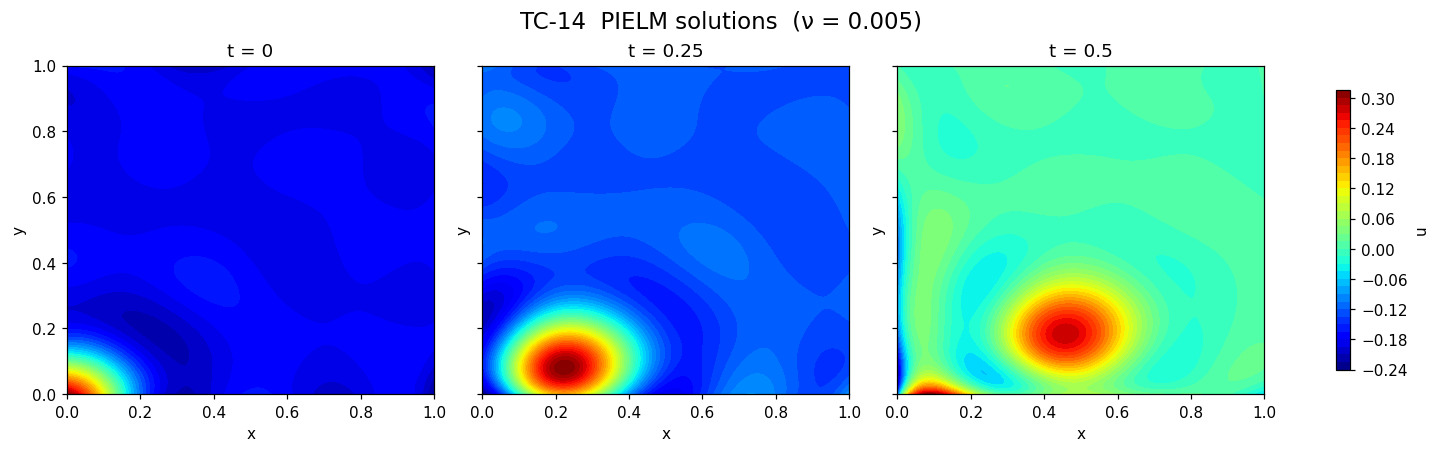

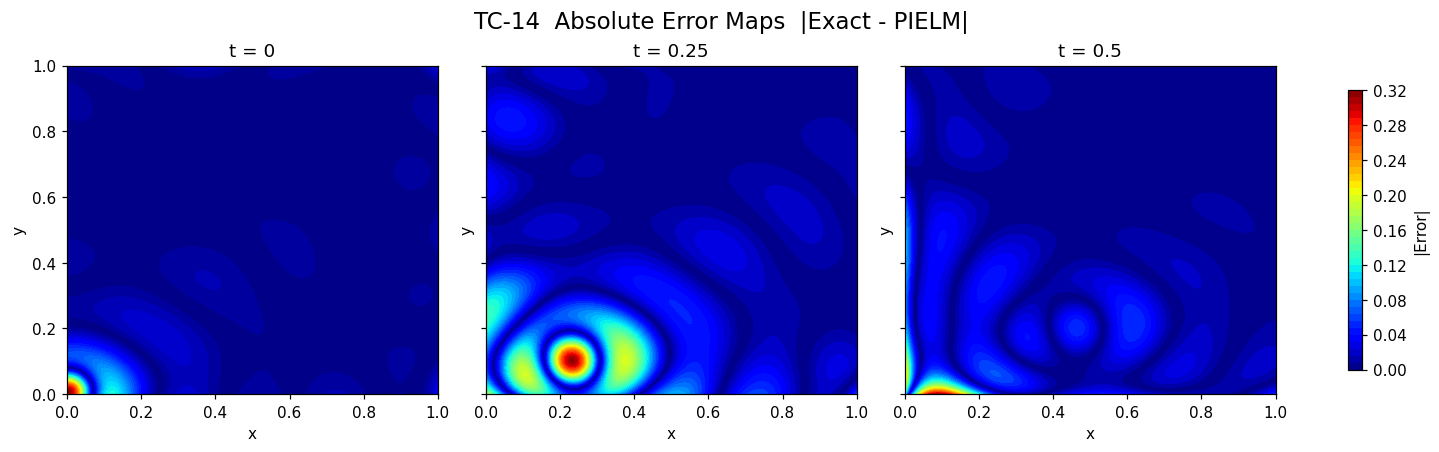

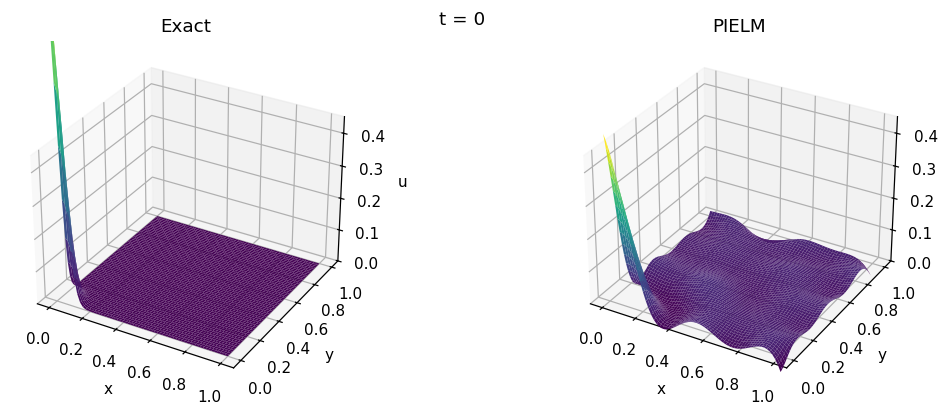

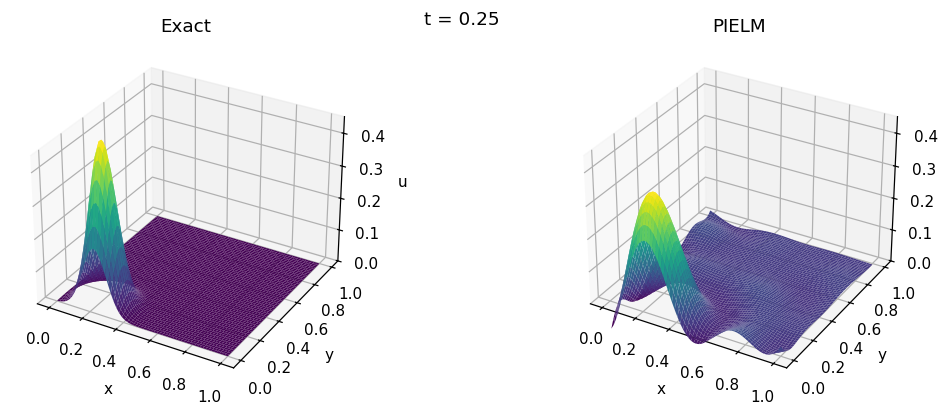

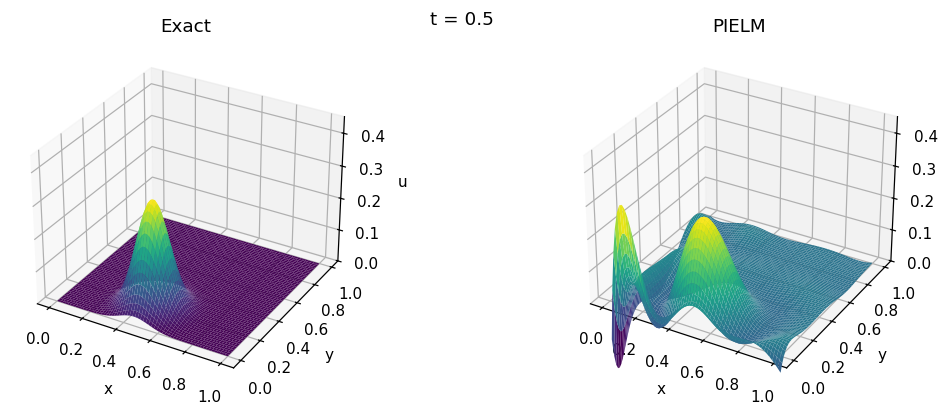

In [56]:
# ============================================================
# TC-14 — PIELM for unsteady 2-D advection-diffusion
#         ν = 0.005   a = cos 22.5°,  b = sin 22.5°
# Paper params (§5.2.4):  N_f=4000 , N_bc=2000 , N*=6000
# ============================================================

import numpy as np, matplotlib.pyplot as plt, matplotlib.tri as tri
from scipy.stats.qmc import Halton
plt.rcParams['axes.facecolor'] = 'white'

# ── activation ───────────────────────────────────────────────
phi      = np.tanh
phi_p    = lambda z: 1 - np.tanh(z)**2
phi_pp   = lambda z: -2*np.tanh(z)*(1 - np.tanh(z)**2)

# ── exact solution & coeffs ──────────────────────────────────
nu  = 5e-3
a   = np.cos(np.deg2rad(22.5))
b   = np.sin(np.deg2rad(22.5))
def u_exact(x,y,t):
    s = (x-a*t)**2 + (y-b*t)**2
    return np.exp(-s/(nu*(4*t+1)))/(4*t+1)

# ── tiny Halton helper (SciPy ≥1.9) ──────────────────────────
def halton_pts(N, seed):
    return Halton(2, scramble=False, seed=seed).random(N)

# ── PIELM network class ──────────────────────────────────────
class PIELM2D_Unsteady:
    def __init__(self, Nstar, seed=0):
        rng = np.random.default_rng(seed)
        self.p = rng.standard_normal((Nstar,1))   # x-weights
        self.q = rng.standard_normal((Nstar,1))   # y-weights
        self.r = rng.standard_normal((Nstar,1))   # t-weights
        self.b = rng.standard_normal((Nstar,1))
        self.c = None

    def _Z(self, P):          # P = [x,y,t]  (n_pts×3)
        return (P[:,0:1]@self.p.T +
                P[:,1:2]@self.q.T +
                P[:,2:3]@self.r.T + self.b.T)     # (n_pts, N*)

    def u(self, P):           # **FIXED** multiply without transpose
        return (phi(self._Z(P)) @ self.c).ravel()

# ── build & train ────────────────────────────────────────────
def run_TC14(Nf=2000, Nbc=1000, Nstar=3000, seed=1):
    net = PIELM2D_Unsteady(Nstar, seed)
    rng = np.random.default_rng(seed)

    # interior ------------------------------------------------
    Pf  = np.c_[halton_pts(Nf,seed), rng.uniform(0,0.5,Nf)]
    Zf  = net._Z(Pf)
    diff= (net.p**2 + net.q**2).T          # (1,N*)

    Hf = phi_p(Zf)*(net.r.T + a*net.p.T + b*net.q.T) \
       - nu*phi_pp(Zf)*diff                # (Nf,N*)
    Kf = np.zeros((Nf,1))

    # boundary -----------------------------------------------
    nb  = Nbc//4
    hb  = halton_pts(nb, seed+3)
    tb  = rng.uniform(0,0.5, nb).reshape(-1,1)
    Pbc = np.vstack([np.c_[hb[:,0:1],      0*hb[:,0:1], tb],   # y=0
                     np.c_[hb[:,0:1],      1*hb[:,0:1], tb],   # y=1
                     np.c_[     0*hb[:,0:1], hb[:,0:1], tb],   # x=0
                     np.c_[     1*hb[:,0:1], hb[:,0:1], tb]])  # x=1
    Hb = phi(net._Z(Pbc))
    Kb = u_exact(Pbc[:,0:1], Pbc[:,1:2], Pbc[:,2:3])

    # initial slice t=0 --------------------------------------
    Pi = np.c_[halton_pts(Nf//2, seed+11), np.zeros((Nf//2,1))]
    Hi = phi(net._Z(Pi))
    Ki = u_exact(Pi[:,0:1], Pi[:,1:2], Pi[:,2:3])

    # solve ---------------------------------------------------
    H = np.vstack([Hf, Hb, Hi])
    K = np.vstack([Kf, Kb, Ki])
    net.c = np.linalg.pinv(H, rcond=1e-6) @ K
    return net

# ── 2-D colour panels (Fig-22 style) ─────────────────────────
def tc14_panels(net, times=(0,0.25,0.5), n=160):
    xx,yy = np.meshgrid(np.linspace(0,1,n), np.linspace(0,1,n))
    fig,axs = plt.subplots(1,len(times), figsize=(13,4),
                           sharex=True, sharey=True,
                           constrained_layout=True)
    for ax,t in zip(axs,times):
        P  = np.c_[xx.ravel(), yy.ravel(), np.full_like(xx.ravel(),t)]
        zz = net.u(P).reshape(n,n)
        m  = ax.contourf(xx,yy,zz,50,cmap='jet')
        ax.set(title=f't = {t}', xlabel='x', ylabel='y')
    fig.colorbar(m, ax=axs, shrink=0.85, label='u')
    fig.suptitle("TC-14  PIELM solutions  (ν = 0.005)", fontsize=15)
    plt.show()

# ── optional 3-D surface comparison ─────────────────────────
def tc14_3d_surfaces(net, times=(0,0.25,0.5), n=65):
    xx,yy = np.meshgrid(np.linspace(0,1,n), np.linspace(0,1,n))
    for t in times:
        P   = np.c_[xx.ravel(), yy.ravel(), np.full_like(xx.ravel(),t)]
        zp  = net.u(P).reshape(n,n)
        ze  = u_exact(xx,yy,t)
        fig = plt.figure(figsize=(11,4)); fig.suptitle(f't = {t}', y=.90)
        for k,(Z,ttl) in enumerate([(ze,'Exact'),(zp,'PIELM')]):
            ax=fig.add_subplot(1,2,k+1,projection='3d')
            ax.plot_surface(xx,yy,Z,cmap='viridis',rstride=1,cstride=1,
                            linewidth=0); ax.set_title(ttl)
            ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('u')
            ax.set_zlim(0,0.45)
        plt.tight_layout(); plt.show()
def tc14_error_panels(net, times=(0, 0.25, 0.5), n=160):
    """Plot absolute error |Exact - PIELM| in 2-D colour contour plots"""
    xx, yy = np.meshgrid(np.linspace(0, 1, n), np.linspace(0, 1, n))

    fig, axs = plt.subplots(1, len(times), figsize=(13, 4),
                            sharex=True, sharey=True,
                            constrained_layout=True)
    for ax, t in zip(axs, times):
        P = np.c_[xx.ravel(), yy.ravel(), np.full_like(xx.ravel(), t)]
        u_pred  = net.u(P).reshape(n, n)
        u_true  = u_exact(xx, yy, t)
        err_map = np.abs(u_true - u_pred)

        # Changed cmap from 'hot' to 'jet' to match PIELM panels
        pcm = ax.contourf(xx, yy, err_map, 50, cmap='jet')
        ax.set(title=f't = {t}', xlabel='x', ylabel='y')

    fig.colorbar(pcm, ax=axs, shrink=0.85, label='|Error|')
    fig.suptitle("TC-14  Absolute Error Maps  |Exact - PIELM|", fontsize=15)
    plt.show()


if __name__ == "__main__":
    net = run_TC14()           # 20-30 s, <2 GB RAM
    tc14_panels(net)           # PIELM predictions
    tc14_error_panels(net)     # NEW: absolute error maps
    tc14_3d_surfaces(net)      # optional surface plots


L2-relative error : 5.11e+01
Max |error|       : 1.43e+00


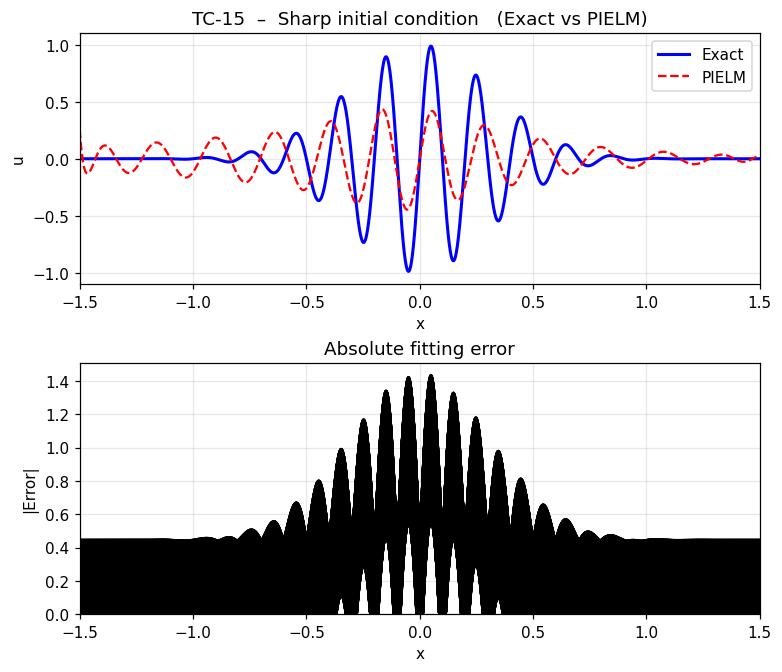

In [54]:
# ============================================================
#  TC-15   –  Fit sharp initial condition
#            F(x) = exp(-10 x²) · sin(20 π x)
# ============================================================

import numpy as np, matplotlib.pyplot as plt
plt.rcParams['axes.facecolor'] = 'white'

# ---------- Exact target --------------------------------------------------
F = lambda x: np.exp(-5*x**2) * np.sin(10*np.pi*x)   # ← updated

# ---------- Activation ----------------------------------------------------
phi   = np.tanh
phi_p = lambda z: 1 - np.tanh(z)**2      # (unused here but kept)

# ---------- Minimal 1-D PIELM class --------------------------------------
class PIELM1D:
    def __init__(self, Nstar=800, seed=0):
        rng   = np.random.default_rng(seed)
        self.w = rng.standard_normal((Nstar,1))   # input weights
        self.b = rng.standard_normal((Nstar,1))   # biases
        self.c = None                             # output weights
 
    def _Z(self, x):                     # affine pre-activation
        return x @ self.w.T + self.b.T   # shape: (N , N*)
    def u(self, x):                      # network prediction
        return (phi(self._Z(x)) @ self.c).ravel()

# ---------- Train the PIELM ----------------------------------------------
def fit_initial(Ndata=1000, Nstar=1000):
    x_tr = np.linspace(-1.5, 1.5, Ndata).reshape(-1,1)  # uniform samples
    y_tr = F(x_tr)

    net  = PIELM1D(Nstar)
    H    = phi(net._Z(x_tr))            # hidden-layer matrix  (Ndata , N*)
    net.c = np.linalg.pinv(H, rcond=1e-8) @ y_tr
    return net

net = fit_initial()      # takes < 0.1 s

# ---------- Diagnostics ----------------------------------------------------
x_plot  = np.linspace(-1.5, 1.5, 2000).reshape(-1,1)
y_exact = F(x_plot)
y_pred  = net.u(x_plot)
err     = np.abs(y_exact - y_pred)

L2_rel  = np.linalg.norm(err)/np.linalg.norm(y_exact)
print(f"L2-relative error : {L2_rel:.2e}")
print(f"Max |error|       : {err.max():.2e}")

# ---------- Plots ----------------------------------------------------------
fig,(ax0,ax1) = plt.subplots(2,1, figsize=(7,6), constrained_layout=True)

# (a) Exact vs PIELM
ax0.plot(x_plot, y_exact, 'b', lw=2, label='Exact')
ax0.plot(x_plot, y_pred,  'r--', lw=1.5, label='PIELM')
ax0.set_xlim(-1.5,1.5); ax0.set_ylim(-1.1,1.1)
ax0.set_xlabel('x'); ax0.set_ylabel('u')
ax0.set_title('TC-15  –  Sharp initial condition   (Exact vs PIELM)')
ax0.legend(); ax0.grid(alpha=.3)

# (b) Absolute error
ax1.plot(x_plot, err, 'k')
ax1.set_xlim(-1.5,1.5); ax1.set_ylim(0, err.max()*1.05)
ax1.set_xlabel('x'); ax1.set_ylabel('|Error|')
ax1.set_title('Absolute fitting error'); ax1.grid(alpha=.3)

plt.show()


In [ ]:
# =============================================================
# Unified PIELM solver – single function, all families (CORRECTED)
# =============================================================

import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Optional, Dict, Any, Tuple
from scipy.stats.qmc import Halton
from matplotlib.path import Path
from matplotlib.tri import Triangulation
from mpl_toolkits.mplot3d import Axes3D  
pi = np.pi


# ---------- activation & exact derivatives ----------
phi     = np.tanh
phi_p   = lambda z: 1.0 - np.tanh(z)**2
phi_pp  = lambda z: -2.0*np.tanh(z)*(1.0 - np.tanh(z)**2)

# ---------- helpers: safe call (const or function) ----------
def _as_fun(v, nargs: int):
    """Return f(*xs) that yields array shape (N,1) from scalar/const/func."""
    if callable(v):
        return v
    else:
        if nargs == 1:
            return lambda x: np.full_like(x, float(v))
        if nargs == 2:
            return lambda x, y: np.full_like(x, float(v))
        if nargs == 3:
            return lambda x, y, t: np.full_like(x, float(v))

# ---------- plotting blocks (match your style) ----------
def _plot1d_steady(u_pred, u_exact, xL, xR, n, title=""):
    x = np.linspace(xL, xR, n).reshape(-1,1)
    up = u_pred(x).reshape(-1,1)
    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(9,3.3), constrained_layout=True)
    if u_exact is not None:
        ue  = u_exact(x)
        ax0.plot(x, ue, 'b', lw=1.8, label='Exact')
        err = (up - ue)
    else:
        err = np.zeros_like(up)
    ax0.plot(x, up, 'r--', lw=1.8, label='PIELM')
    ax0.set_title(title or 'Solution')
    ax0.set_xlabel('x'); ax0.set_ylabel('u'); ax0.grid(alpha=.3); ax0.legend()

    ax1.plot(x, err, 'r', lw=1.5)
    ax1.set_title('Point-wise error')
    ax1.set_xlabel('x'); ax1.set_ylabel('error'); ax1.grid(alpha=.3)
    plt.show()

def _plot1d_unsteady(u_pred, u_exact, xL, xR, times, n, title=""):
    x = np.linspace(xL, xR, n).reshape(-1,1)
    fig, axs = plt.subplots(1, len(times), figsize=(10,3.3), constrained_layout=True)
    if len(times) == 1:
        axs = [axs]
    for j,tv in enumerate(times):
        tt = np.full_like(x, tv)
        up = u_pred(x, tt)
        if u_exact is not None:
            ue = u_exact(x, tt)
            axs[j].plot(x, ue, 'b', lw=1.8, label='Exact' if j==0 else "")
        axs[j].plot(x, up, 'r--', lw=1.8, label='PIELM' if j==0 else "")
        axs[j].set_title(f'{title}  t={tv}')
        axs[j].set_xlabel('x');
        if j==0: axs[j].set_ylabel('u')
        axs[j].grid(alpha=.3)
    if u_exact is not None: axs[0].legend(loc='upper center')
    plt.show()

def _plot2d_rect_steady(u_pred, u_exact, xL, xR, yL, yR, n, title=""):
    xs, ys = np.linspace(xL,xR,n), np.linspace(yL,yR,n)
    xx, yy = np.meshgrid(xs, ys)
    P = np.c_[xx.ravel(), yy.ravel()]
    up = u_pred(P).reshape(n,n)
    fig, axs = plt.subplots(1,2, figsize=(10,3.6), constrained_layout=True, sharex=True, sharey=True)
    m0 = axs[0].contourf(xx, yy, up, 50, cmap='jet'); axs[0].set_title(title+' – PIELM'); plt.colorbar(m0, ax=axs[0], fraction=.046)
    if u_exact is not None:
        ue = u_exact(xx, yy)
        err = up - ue
        m1 = axs[1].contourf(xx, yy, err, 50, cmap='jet'); axs[1].set_title('Point-wise error'); plt.colorbar(m1, ax=axs[1], fraction=.046)
    else:
        axs[1].axis('off')
    for a in axs: a.set_xlabel('x'); a.set_ylabel('y')
    plt.show()

def _plot2d_poly_steady(u_pred, u_exact, path: Path, n, title=""):
    xs = ys = np.linspace(0,1,n)
    xx, yy = np.meshgrid(xs, ys)
    pts = np.c_[xx.ravel(), yy.ravel()]
    mask = path.contains_points(pts)
    pts  = pts[mask]
    tri  = Triangulation(pts[:,0], pts[:,1])
    up   = u_pred(pts).ravel()
    fig,axs = plt.subplots(1,2, figsize=(10,3.6), constrained_layout=True)
    m0 = axs[0].tripcolor(tri, up, shading='gouraud', cmap='jet'); axs[0].set_title(title+' – PIELM'); plt.colorbar(m0, ax=axs[0], fraction=.046)
    if u_exact is not None:
        ue = u_exact(pts[:,0:1], pts[:,1:2]).ravel()
        err = up - ue
        m1 = axs[1].tripcolor(tri, err, shading='gouraud', cmap='jet'); axs[1].set_title('Point-wise error'); plt.colorbar(m1, ax=axs[1], fraction=.046)
    else:
        axs[1].axis('off')
    for a in axs: a.set_xticks([]); a.set_yticks([])
    plt.show()

def _plot2d_unsteady(u_pred, u_exact, xL, xR, yL, yR, times, n, title=""):
    xs, ys = np.linspace(xL,xR,n), np.linspace(yL,yR,n)
    xx, yy = np.meshgrid(xs, ys)
    fig, axs = plt.subplots(1, len(times), figsize=(13,3.6), constrained_layout=True, sharex=True, sharey=True)
    if len(times) == 1: axs = [axs]
    for ax, t in zip(axs, times):
        P  = np.c_[xx.ravel(), yy.ravel(), np.full((n*n,1), t)]
        up = u_pred(P).reshape(n,n)
        m  = ax.contourf(xx, yy, up, 50, cmap='jet'); ax.set(title=f'{title}  t={t}', xlabel='x', ylabel='y')
    fig.colorbar(m, ax=axs, shrink=0.85, label='u')
    plt.show()

def _plot2d_unsteady_error(u_pred, u_exact, xL, xR, yL, yR, times, n, title=""):
    if u_exact is None: return
    xs, ys = np.linspace(xL,xR,n), np.linspace(yL,yR,n)
    xx, yy = np.meshgrid(xs, ys)
    fig, axs = plt.subplots(1, len(times), figsize=(13,3.6), constrained_layout=True, sharex=True, sharey=True)
    if len(times) == 1: axs = [axs]
    for ax, t in zip(axs, times):
        P  = np.c_[xx.ravel(), yy.ravel(), np.full((n*n,1), t)]
        up = u_pred(P).reshape(n,n)
        ue = u_exact(xx, yy, t)
        err = up - ue
        m = ax.contourf(xx, yy, err, 50, cmap='jet'); ax.set(title=f'Error  t={t}', xlabel='x', ylabel='y')
    fig.colorbar(m, ax=axs, shrink=0.85, label='error')
    plt.show()
# Function to create 3D surface plots for 2D steady solutions
def plot_3d_surface(u_pred, u_exact, xL, xR, yL, yR, n, title=""):
    xs, ys = np.linspace(xL, xR, n), np.linspace(yL, yR, n)
    xx, yy = np.meshgrid(xs, ys)
    P = np.c_[xx.ravel(), yy.ravel()]
    
    # Compute predicted and exact solutions
    up = u_pred(P).reshape(n, n)
    if u_exact is not None:
        ue = u_exact(xx, yy)
        err = up - ue
    else:
        ue = None
        err = None
    
    # Create 3D plots
    fig = plt.figure(figsize=(15, 5))
    
    # Plot predicted solution
    ax1 = fig.add_subplot(131, projection='3d')
    surf1 = ax1.plot_surface(xx, yy, up, cmap='viridis', alpha=0.8, 
                             linewidth=0, antialiased=True)
    ax1.set_title(f'{title} - PIELM Solution')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('u(x,y)')
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
    
    # Plot exact solution if available
    if u_exact is not None:
        ax2 = fig.add_subplot(132, projection='3d')
        surf2 = ax2.plot_surface(xx, yy, ue, cmap='viridis', alpha=0.8,
                                linewidth=0, antialiased=True)
        ax2.set_title('Exact Solution')
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
        ax2.set_zlabel('u(x,y)')
        fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)
        
        # Plot error
        ax3 = fig.add_subplot(133, projection='3d')
        surf3 = ax3.plot_surface(xx, yy, err, cmap='coolwarm', alpha=0.8,
                                linewidth=0, antialiased=True)
        ax3.set_title('Error')
        ax3.set_xlabel('x')
        ax3.set_ylabel('y')
        ax3.set_zlabel('error')
        fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=5)
    
    plt.tight_layout()
    plt.show()

# Function to create 3D surface plots for 2D unsteady solutions at specific times
def plot_3d_unsteady(u_pred, u_exact, xL, xR, yL, yR, times, n, title=""):
    xs, ys = np.linspace(xL, xR, n), np.linspace(yL, yR, n)
    xx, yy = np.meshgrid(xs, ys)
    
    # Create plots for each time point
    for t in times:
        # Create figure
        fig = plt.figure(figsize=(15, 5))
        fig.suptitle(f'{title} - Time t={t}')
        
        # Predicted solution
        P = np.c_[xx.ravel(), yy.ravel(), np.full((n*n,1), t)]
        up = u_pred(P).reshape(n, n)
        
        ax1 = fig.add_subplot(131, projection='3d')
        surf1 = ax1.plot_surface(xx, yy, up, cmap='viridis', alpha=0.8,
                                linewidth=0, antialiased=True)
        ax1.set_title('PIELM Solution')
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_zlabel('u(x,y,t)')
        fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
        
        # Exact solution if available
        if u_exact is not None:
            ue = u_exact(xx, yy, t)
            err = up - ue
            
            ax2 = fig.add_subplot(132, projection='3d')
            surf2 = ax2.plot_surface(xx, yy, ue, cmap='viridis', alpha=0.8,
                                    linewidth=0, antialiased=True)
            ax2.set_title('Exact Solution')
            ax2.set_xlabel('x')
            ax2.set_ylabel('y')
            ax2.set_zlabel('u(x,y,t)')
            fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)
            
            # Error
            ax3 = fig.add_subplot(133, projection='3d')
            surf3 = ax3.plot_surface(xx, yy, err, cmap='coolwarm', alpha=0.8,
                                    linewidth=0, antialiased=True)
            ax3.set_title('Error')
            ax3.set_xlabel('x')
            ax3.set_ylabel('y')
            ax3.set_zlabel('error')
            fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=5)
        
        plt.tight_layout()
        plt.show()

# ---------- main solver ----------
def solve_pielm(problem: Dict[str, Any]) -> Tuple[Callable, Dict[str, Any]]:
    """
    Unified PIELM solver – builds H c = K for a wide class of linear PDEs:
      1D steady:      a u_x  - ν u_xx  = R(x)      (advection/diffusion/adv-diff/Poisson)
      1D unsteady:    u_t + a(x) u_x - ν u_xx = R(x,t)
      2D steady:      a u_x + b u_y + γ (u_xx + u_yy) = R(x,y)
      2D unsteady:    u_t + a u_x + b u_y - ν (u_xx + u_yy) = R(x,y,t)
    """

    # --- parse config with defaults ---
    dim   = problem.get('dim', 1)
    timep = problem.get('time', False)
    op    = problem.get('operator', {'type':'advdiff'}); optype = op.get('type','advdiff').lower()

    coeffs = problem.get('coeffs', {})
    forcing= problem.get('forcing', 0.0)
    domain = problem.get('domain', {'type':'interval','x':(0.0,1.0)})

    bc     = problem.get('bc', {'type':'dirichlet'})
    ic     = problem.get('ic', None) if timep else None

    colloc = problem.get('collocation', {})
    N_f    = int(colloc.get('N_f', 400))
    N_bc   = int(colloc.get('N_bc', 40))
    N_ic   = int(colloc.get('N_ic', 40)) if timep else 0

    model  = problem.get('model', {})
    N_star = int(model.get('N_star', N_f + N_bc + N_ic))
    seed   = int(model.get('seed', 0))
    ridge  = float(model.get('ridge', 0.0))
    rcond  = float(model.get('rcond', 1e-8))

    exact  = problem.get('exact', None)

    plot   = problem.get('plot', {'enabled': True})
    do_plot= bool(plot.get('enabled', True))
    n_plot = int(plot.get('n_plot', 1000 if dim==1 else 160))
    times  = plot.get('times', [0.0, 0.25, 0.5]) if timep else []
    surf3d = bool(plot.get('surface3d', False))

    # --- transform coeffs / forcing to callables ---
    if dim==1 and not timep:
        a  = _as_fun(coeffs.get('a', 0.0), 1)
        nu = coeffs.get('nu', None)
        if optype in ('poisson','diffusion','diff'):
            nu = float(coeffs.get('nu', 1.0))
        nu_fun = _as_fun(nu if nu is not None else 0.0, 1)
        R  = _as_fun(forcing, 1)
    elif dim==1 and timep:
        a  = _as_fun(coeffs.get('a', 1.0), 1)
        nu = float(coeffs.get('nu', 0.0))
        R  = _as_fun(forcing, 2)
    elif dim==2 and not timep:
        a  = _as_fun(coeffs.get('a', 0.0), 2)
        b  = _as_fun(coeffs.get('b', 0.0), 2)
        gam= float(coeffs.get('gamma', coeffs.get('nu', 1.0)))
        R  = _as_fun(forcing, 2)
    elif dim==2 and timep:
        a  = _as_fun(coeffs.get('a', 0.0), 2)
        b  = _as_fun(coeffs.get('b', 0.0), 2)
        nu = float(coeffs.get('nu', 0.0))
        R  = _as_fun(forcing, 3)
    else:
        raise ValueError("Unsupported (dim, time) combination")

    # --- random features (ELM) ---
    rng   = np.random.default_rng(seed)
    D     = dim + (1 if timep else 0)
    W_in  = rng.standard_normal((N_star, D))
    b_in  = rng.standard_normal((N_star, 1))

    # --- collocation sampling ---
    if dim==1:
        xL, xR = domain.get('x', (0.0, 1.0))
        hal = Halton(1, scramble=False, seed=seed)
        x_f = xL + (xR-xL) * hal.random(N_f).reshape(-1,1)
        
        # ADD TIME SAMPLING FOR 1D UNSTEADY
        if timep:
            tmax = float(problem.get('tmax', 0.5))
            t_f = rng.uniform(0.0, tmax, size=(N_f,1))
        
        bc_type = bc.get('type','dirichlet').lower()
        if bc_type == 'periodic':
            if timep:
                t_bc = np.linspace(0, problem.get('tmax', 0.5), N_bc).reshape(-1,1)
        else:
            x_bc = np.array([[xL],[xR]])
            if timep:
                t_bc = np.linspace(0, problem.get('tmax', 0.5), N_bc).reshape(-1,1)
        if timep:
            x_ic = np.linspace(xL, xR, max(2, N_ic)).reshape(-1,1)
            t_ic = np.zeros_like(x_ic)
    else:
        dtyp = domain.get('type','rect').lower()
        if dtyp == 'rect':
            xL, xR = domain.get('x',(0.0,1.0))
            yL, yR = domain.get('y',(0.0,1.0))
            hal = Halton(2, scramble=False, seed=seed)
            pts = hal.random(N_f)
            x_f = xL + (xR-xL)*pts[:,0:1]
            y_f = yL + (yR-yL)*pts[:,1:2]
            if timep:
                tmax = float(problem.get('tmax', 0.5))
                t_f = rng.uniform(0.0, tmax, size=(N_f,1))
            
            # FIXED BOUNDARY SAMPLING - distribute N_bc points uniformly on perimeter
            bc_pts = []
            perimeter = 2*(xR-xL) + 2*(yR-yL)
            
            for i in range(N_bc):
                t_param = i / N_bc if N_bc > 1 else 0.0  # parameter from 0 to 1
                pos = t_param * perimeter
                
                if pos <= (xR-xL):  # bottom edge
                    bc_pts.append([xL + pos, yL])
                elif pos <= (xR-xL) + (yR-yL):  # right edge
                    bc_pts.append([xR, yL + (pos - (xR-xL))])
                elif pos <= 2*(xR-xL) + (yR-yL):  # top edge (going right to left)
                    bc_pts.append([xR - (pos - (xR-xL) - (yR-yL)), yR])
                else:  # left edge (going top to bottom)
                    bc_pts.append([xL, yR - (pos - 2*(xR-xL) - (yR-yL))])
            
            bc_pts = np.array(bc_pts)
            
            # Ensure we have exactly N_bc boundary points
            assert bc_pts.shape[0] == N_bc, f"Expected {N_bc} boundary points, got {bc_pts.shape[0]}"
            
            if timep:
                t_bc = rng.uniform(0.0, tmax, size=(N_bc,1))
                
        elif dtyp == 'polygon':
            verts = np.asarray(domain['verts'])
            path  = Path(verts)
            ngrid = int(np.sqrt(N_f) * 1.4)
            xs = ys = np.linspace(0,1, max(20, ngrid))
            xx, yy = np.meshgrid(xs,ys)
            P = np.c_[xx.ravel(), yy.ravel()]
            msk = path.contains_points(P)
            P_in = P[msk]
            if len(P_in) < N_f: N_f = len(P_in)
            sel = rng.choice(len(P_in), size=N_f, replace=False)
            x_f = P_in[sel,0:1]; y_f = P_in[sel,1:2]
            if timep:
                tmax = float(problem.get('tmax', 0.5))
                t_f = rng.uniform(0.0, tmax, size=(N_f,1))
            
            # For polygon, use the vertices as boundary points
            bc_pts = verts.copy()
            # If we need more boundary points than vertices, sample additional points on edges
            if len(bc_pts) < N_bc:
                # Sample additional points on polygon edges
                n_additional = N_bc - len(bc_pts)
                edge_pts = []
                for i in range(len(verts)):
                    v1, v2 = verts[i], verts[(i+1) % len(verts)]
                    n_edge = max(1, n_additional // len(verts))
                    for j in range(n_edge):
                        t = (j + 1) / (n_edge + 1)
                        edge_pt = (1-t) * v1 + t * v2
                        edge_pts.append(edge_pt)
                        if len(edge_pts) >= n_additional:
                            break
                    if len(edge_pts) >= n_additional:
                        break
                bc_pts = np.vstack([bc_pts, np.array(edge_pts[:n_additional])])
            
            # Ensure exactly N_bc points
            bc_pts = bc_pts[:N_bc]
            
            if timep:
                t_bc = rng.uniform(0.0, tmax, size=(bc_pts.shape[0],1))
        else:
            raise ValueError("2D domain.type must be 'rect' or 'polygon'")
            
        if timep:
            if dtyp == 'rect':
                nx = int(np.sqrt(max(8, N_ic))); ny = nx
                xx0, yy0 = np.meshgrid(np.linspace(xL,xR,nx), np.linspace(yL,yR,ny))
                x_ic = xx0.ravel()[:,None]; y_ic = yy0.ravel()[:,None]
                t_ic = np.zeros_like(x_ic)
            else:
                sel = rng.choice(len(P_in), size=max(8, N_ic), replace=False)
                x_ic = P_in[sel,0:1]; y_ic = P_in[sel,1:2]
                t_ic = np.zeros_like(x_ic)

    # ---------- Build PDE rows (CORRECTED BROADCASTING) ----------
    def _Z(P):     # P: (N, D)
        return P @ W_in.T + b_in.T

    rows = []
    rhs  = []

    if dim==1 and not timep:
        Zf = _Z(np.c_[x_f])                          # (N_f, N_star)
        m  = W_in[:,0:1]                             # (N_star, 1) - x weights
        
        if optype in ('advection','adv','adv1d'):
            # Correct broadcasting: phi_p(Zf) is (N_f, N_star), m.T is (1, N_star), a(x_f) is (N_f, 1)
            Hf = phi_p(Zf) * m.T * a(x_f)           # (N_f, N_star) element-wise
            Kf = R(x_f)
        elif optype in ('poisson','diffusion','diff'):
            if 'nu' in coeffs and float(coeffs['nu']) != 0.0:
                Hf = - float(coeffs['nu']) * phi_pp(Zf) * (m.T**2)
            else:
                Hf = phi_pp(Zf) * (m.T**2)
            Kf = R(x_f)
        elif optype in ('advdiff','advection-diffusion','adv-diff'):
            Hf = phi_p(Zf) * m.T * a(x_f) - float(coeffs.get('nu',0.0)) * phi_pp(Zf) * (m.T**2)
            Kf = R(x_f)
        else:
            raise ValueError(f"Unsupported 1D steady operator '{optype}'")
        rows.append(Hf); rhs.append(Kf)

    elif dim==1 and timep:
        Zf = _Z(np.c_[x_f, t_f])
        m = W_in[:,0:1]                              # x weights (N_star, 1)
        n = W_in[:,1:2]                              # t weights (N_star, 1)
        
        Hf = phi_p(Zf) * n.T + phi_p(Zf) * m.T * a(x_f) - float(coeffs.get('nu',0.0)) * phi_pp(Zf) * (m.T**2)
        Kf = R(x_f, t_f)
        rows.append(Hf); rhs.append(Kf)

    elif dim==2 and not timep:
        Zf = _Z(np.c_[x_f, y_f])
        px = W_in[:,0:1]                             # x weights (N_star, 1)
        qy = W_in[:,1:2]                             # y weights (N_star, 1)
        
        adv = phi_p(Zf) * px.T * a(x_f, y_f) + phi_p(Zf) * qy.T * b(x_f, y_f)
        diff= float(coeffs.get('gamma', coeffs.get('nu', 0.0))) * phi_pp(Zf) * (px.T**2 + qy.T**2)
        Hf  = adv + diff
        Kf  = R(x_f, y_f)
        
        # Ensure Kf has shape (N_f, 1)
        if isinstance(Kf, np.ndarray) and Kf.shape != (N_f, 1):
            Kf = Kf.reshape(N_f, 1)
        
        rows.append(Hf); rhs.append(Kf)

    elif dim==2 and timep:
        Zf = _Z(np.c_[x_f, y_f, t_f])
        px = W_in[:,0:1]                             # x weights (N_star, 1)
        qy = W_in[:,1:2]                             # y weights (N_star, 1)
        rt = W_in[:,2:3]                             # t weights (N_star, 1)
        
        adv = phi_p(Zf) * rt.T + phi_p(Zf) * px.T * a(x_f, y_f) + phi_p(Zf) * qy.T * b(x_f, y_f)
        diff= - float(coeffs.get('nu', 0.0)) * phi_pp(Zf) * (px.T**2 + qy.T**2)
        Hf  = adv + diff
        Kf  = R(x_f, y_f, t_f)
        
        # Ensure Kf has shape (N_f, 1)
        if isinstance(Kf, np.ndarray) and Kf.shape != (N_f, 1):
            Kf = Kf.reshape(N_f, 1)
            
        rows.append(Hf); rhs.append(Kf)

    # ---------- Boundary rows ----------
    bc_type = bc.get('type','dirichlet').lower()
    if dim==1:
        if bc_type == 'periodic':
            if timep:
                xL_arr = np.full((N_bc,1), xL); xR_arr = np.full((N_bc,1), xR)
                ZL = _Z(np.c_[xL_arr, t_bc]); ZR = _Z(np.c_[xR_arr, t_bc])
                Hbc = (phi(ZL) - phi(ZR)); Kbc = np.zeros((N_bc,1))
                rows.append(Hbc); rhs.append(Kbc)
            else:
                ZL = _Z(np.c_[[[xL]]]); ZR = _Z(np.c_[[[xR]]])
                rows.append(phi(ZL) - phi(ZR)); rhs.append(np.zeros((1,1)))
        elif bc_type == 'dirichlet':
            gL = bc.get('gL', 0.0); gR = bc.get('gR', 0.0)
            gL = _as_fun(gL, 2 if timep else 1)
            gR = _as_fun(gR, 2 if timep else 1)
            if timep:
                ZL = _Z(np.c_[np.full_like(t_bc, xL), t_bc])
                ZR = _Z(np.c_[np.full_like(t_bc, xR), t_bc])
                rows.append(phi(ZL)); rhs.append(gL(np.full_like(t_bc, xL), t_bc))
                rows.append(phi(ZR)); rhs.append(gR(np.full_like(t_bc, xR), t_bc))
            else:
                ZL = _Z(np.c_[[[xL]]]); ZR = _Z(np.c_[[[xR]]])
                rows.append(phi(ZL)); rhs.append(gL(np.array([[xL]])))
                rows.append(phi(ZR)); rhs.append(gR(np.array([[xR]])))
        elif bc_type == 'neumann':
            gL = _as_fun(bc.get('gL', 0.0), 1)
            gR = _as_fun(bc.get('gR', 0.0), 1)
            m  = W_in[:,0:1].T
            if timep:
                ZL = _Z(np.c_[np.full_like(t_bc,xL), t_bc])
                ZR = _Z(np.c_[np.full_like(t_bc,xR), t_bc])
                rows.append(phi_p(ZL)*m); rhs.append(gL(np.full_like(t_bc,xL)))
                rows.append(phi_p(ZR)*m); rhs.append(gR(np.full_like(t_bc,xR)))
            else:
                ZL = _Z(np.c_[[[xL]]]); ZR = _Z(np.c_[[[xR]]])
                rows.append(phi_p(ZL)*m); rhs.append(gL(np.array([[xL]])))
                rows.append(phi_p(ZR)*m); rhs.append(gR(np.array([[xR]])))
        else:
            raise ValueError("1D bc.type must be 'dirichlet' | 'neumann' | 'periodic'")

    else:
        if bc_type != 'dirichlet':
            raise ValueError("2D: only Dirichlet BC supported")
        
        # FIXED 2D boundary condition handling
        g_val = bc.get('g', 0.0)
        Zb = _Z(np.c_[bc_pts, t_bc]) if timep else _Z(np.c_[bc_pts])
        
        if callable(g_val):
            if timep:
                Kb = g_val(bc_pts[:,0:1], bc_pts[:,1:2], t_bc)
            else:
                Kb = g_val(bc_pts[:,0:1], bc_pts[:,1:2])
                
            # Convert scalar to array if needed
            if np.isscalar(Kb):
                Kb = np.full((N_bc, 1), float(Kb))
            # Ensure Kb has shape (N_bc, 1) if it's already an array
            elif isinstance(Kb, np.ndarray) and Kb.shape != (N_bc, 1):
                Kb = Kb.reshape(N_bc, 1)
        else:
            # For constant boundary value
            Kb = np.full((N_bc, 1), float(g_val))
            
        # Debug to verify dimensions
        print(f"2D BC: Zb.shape={Zb.shape}, Kb.shape={np.shape(Kb) if isinstance(Kb, np.ndarray) else 'scalar'}, N_bc={N_bc}")
        
        rows.append(phi(Zb))
        rhs.append(Kb)

    # ---------- Initial condition rows ----------
    if timep:
        if dim==1:
            Zi = _Z(np.c_[x_ic, t_ic])
            Fi = _as_fun(ic['F'], 1)
            ic_val = Fi(x_ic)
            
            # Ensure ic_val has shape (N_ic, 1)
            if isinstance(ic_val, np.ndarray) and ic_val.shape != (len(x_ic), 1):
                ic_val = ic_val.reshape(len(x_ic), 1)
                
            rows.append(phi(Zi))
            rhs.append(ic_val)
        else:
            Zi = _Z(np.c_[x_ic, y_ic, t_ic])
            Fi = _as_fun(ic['F'], 2)
            ic_val = Fi(x_ic, y_ic)
            
            # Ensure ic_val has shape (N_ic, 1)
            if isinstance(ic_val, np.ndarray) and ic_val.shape != (len(x_ic), 1):
                ic_val = ic_val.reshape(len(x_ic), 1)
                
            rows.append(phi(Zi))
            rhs.append(ic_val)

    # ---------- stack & solve ----------
    # Debug each component before stacking
    for i, (row, r) in enumerate(zip(rows, rhs)):
        print(f"Component {i}: row.shape={row.shape}, rhs.shape={r.shape if hasattr(r, 'shape') else 'scalar'}")
        
    H = np.vstack(rows)
    K = np.vstack(rhs)
    
    print(f"Debug: H.shape = {H.shape}, K.shape = {K.shape}")
    print(f"Debug: N_f = {N_f}, N_bc = {N_bc}, N_ic = {N_ic}, N_star = {N_star}")
    
    if ridge and ridge > 0:
        M = H.shape[1]
        c = np.linalg.solve(H.T @ H + ridge*np.eye(M), H.T @ K)
    else:
        c = np.linalg.pinv(H, rcond=rcond) @ K

    # ---------- predictor ----------
    def _u_from_P(P):
        return (phi(P @ W_in.T + b_in.T) @ c).ravel()

    if dim==1 and not timep:
        def u_pred(x):
            x = np.asarray(x).reshape(-1,1)
            P = np.c_[x]
            return _u_from_P(P)
    elif dim==1 and timep:
        def u_pred(x, t):
            x = np.asarray(x).reshape(-1,1)
            t = np.asarray(t).reshape(-1,1)
            P = np.c_[x, t]
            return _u_from_P(P)
    elif dim==2 and not timep:
        def u_pred(P_or_xy, y=None):
            if y is None:
                P = np.asarray(P_or_xy)
                if P.ndim==1: P = P.reshape(1,-1)
                return _u_from_P(P)
            else:
                x = np.asarray(P_or_xy).reshape(-1,1)
                y = np.asarray(y).reshape(-1,1)
                P = np.c_[x, y]
                return _u_from_P(P)
    else:
        def u_pred(P_or_x, y=None, t=None):
            if y is None and t is None:
                P = np.asarray(P_or_x)
                if P.ndim==1: P = P.reshape(1,-1)
                return _u_from_P(P)
            else:
                x = np.asarray(P_or_x).reshape(-1,1)
                y = np.asarray(y).reshape(-1,1)
                t = np.asarray(t).reshape(-1,1)
                P = np.c_[x, y, t]
                return _u_from_P(P)

    # ---------- plotting ----------
    if do_plot:
        if dim==1 and not timep:
            xL, xR = domain.get('x',(0.0,1.0))
            _plot1d_steady(u_pred, exact, xL, xR, n_plot, title=optype.upper())
        elif dim==1 and timep:
            xL, xR = domain.get('x',(0.0,1.0))
            _plot1d_unsteady(u_pred, exact, xL, xR, times, n_plot, title=optype.upper())
        elif dim==2 and not timep:
            dtyp = domain.get('type','rect').lower()
            if dtyp == 'rect':
                xL, xR = domain.get('x',(0.0,1.0)); yL, yR = domain.get('y',(0.0,1.0))
                _plot2d_rect_steady(u_pred, exact, xL, xR, yL, yR, n_plot, title=optype.upper())
            else:
                _plot2d_poly_steady(u_pred, exact, Path(domain['verts']), n_plot, title=optype.upper())
        else:
            xL, xR = domain.get('x',(0.0,1.0)); yL, yR = domain.get('y',(0.0,1.0))
            _plot2d_unsteady(u_pred, exact, xL, xR, yL, yR, times, n_plot, title=optype.upper())
            _plot2d_unsteady_error(u_pred, exact, xL, xR, yL, yR, times, n_plot, title=optype.upper())

    info = {
        'N_f': N_f, 'N_bc': N_bc, 'N_ic': N_ic, 'N_star': N_star,
        'seed': seed, 'ridge': ridge, 'rcond': rcond,
        'W_in': W_in, 'b_in': b_in, 'c': c, 'dim': dim, 'time': timep,
        'optype': optype
    }
    return u_pred, info
# =============================================================
# Unified PIELM solver – single function, all families (CORRECTED)
# =============================================================

import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Optional, Dict, Any, Tuple
from scipy.stats.qmc import Halton
from matplotlib.path import Path
from matplotlib.tri import Triangulation
from mpl_toolkits.mplot3d import Axes3D  
pi = np.pi


# ---------- activation & exact derivatives ----------
phi     = np.tanh
phi_p   = lambda z: 1.0 - np.tanh(z)**2
phi_pp  = lambda z: -2.0*np.tanh(z)*(1.0 - np.tanh(z)**2)

# ---------- helpers: safe call (const or function) ----------
def _as_fun(v, nargs: int):
    """Return f(*xs) that yields array shape (N,1) from scalar/const/func."""
    if callable(v):
        return v
    else:
        if nargs == 1:
            return lambda x: np.full_like(x, float(v))
        if nargs == 2:
            return lambda x, y: np.full_like(x, float(v))
        if nargs == 3:
            return lambda x, y, t: np.full_like(x, float(v))

# ---------- plotting blocks (match your style) ----------
def _plot1d_steady(u_pred, u_exact, xL, xR, n, title=""):
    x = np.linspace(xL, xR, n).reshape(-1,1)
    up = u_pred(x).reshape(-1,1)
    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(9,3.3), constrained_layout=True)
    if u_exact is not None:
        ue  = u_exact(x)
        ax0.plot(x, ue, 'b', lw=1.8, label='Exact')
        err = (up - ue)
    else:
        err = np.zeros_like(up)
    ax0.plot(x, up, 'r--', lw=1.8, label='PIELM')
    ax0.set_title(title or 'Solution')
    ax0.set_xlabel('x'); ax0.set_ylabel('u'); ax0.grid(alpha=.3); ax0.legend()

    ax1.plot(x, err, 'r', lw=1.5)
    ax1.set_title('Point-wise error')
    ax1.set_xlabel('x'); ax1.set_ylabel('error'); ax1.grid(alpha=.3)
    plt.show()

def _plot1d_unsteady(u_pred, u_exact, xL, xR, times, n, title=""):
    x = np.linspace(xL, xR, n).reshape(-1,1)
    fig, axs = plt.subplots(1, len(times), figsize=(10,3.3), constrained_layout=True)
    if len(times) == 1:
        axs = [axs]
    for j,tv in enumerate(times):
        tt = np.full_like(x, tv)
        up = u_pred(x, tt)
        if u_exact is not None:
            ue = u_exact(x, tt)
            axs[j].plot(x, ue, 'b', lw=1.8, label='Exact' if j==0 else "")
        axs[j].plot(x, up, 'r--', lw=1.8, label='PIELM' if j==0 else "")
        axs[j].set_title(f'{title}  t={tv}')
        axs[j].set_xlabel('x');
        if j==0: axs[j].set_ylabel('u')
        axs[j].grid(alpha=.3)
    if u_exact is not None: axs[0].legend(loc='upper center')
    plt.show()

def _plot2d_rect_steady(u_pred, u_exact, xL, xR, yL, yR, n, title=""):
    xs, ys = np.linspace(xL,xR,n), np.linspace(yL,yR,n)
    xx, yy = np.meshgrid(xs, ys)
    P = np.c_[xx.ravel(), yy.ravel()]
    up = u_pred(P).reshape(n,n)
    fig, axs = plt.subplots(1,2, figsize=(10,3.6), constrained_layout=True, sharex=True, sharey=True)
    m0 = axs[0].contourf(xx, yy, up, 50, cmap='jet'); axs[0].set_title(title+' – PIELM'); plt.colorbar(m0, ax=axs[0], fraction=.046)
    if u_exact is not None:
        ue = u_exact(xx, yy)
        err = up - ue
        m1 = axs[1].contourf(xx, yy, err, 50, cmap='jet'); axs[1].set_title('Point-wise error'); plt.colorbar(m1, ax=axs[1], fraction=.046)
    else:
        axs[1].axis('off')
    for a in axs: a.set_xlabel('x'); a.set_ylabel('y')
    plt.show()

def _plot2d_poly_steady(u_pred, u_exact, path: Path, n, title=""):
    xs = ys = np.linspace(0,1,n)
    xx, yy = np.meshgrid(xs, ys)
    pts = np.c_[xx.ravel(), yy.ravel()]
    mask = path.contains_points(pts)
    pts  = pts[mask]
    tri  = Triangulation(pts[:,0], pts[:,1])
    up   = u_pred(pts).ravel()
    fig,axs = plt.subplots(1,2, figsize=(10,3.6), constrained_layout=True)
    m0 = axs[0].tripcolor(tri, up, shading='gouraud', cmap='jet'); axs[0].set_title(title+' – PIELM'); plt.colorbar(m0, ax=axs[0], fraction=.046)
    if u_exact is not None:
        ue = u_exact(pts[:,0:1], pts[:,1:2]).ravel()
        err = up - ue
        m1 = axs[1].tripcolor(tri, err, shading='gouraud', cmap='jet'); axs[1].set_title('Point-wise error'); plt.colorbar(m1, ax=axs[1], fraction=.046)
    else:
        axs[1].axis('off')
    for a in axs: a.set_xticks([]); a.set_yticks([])
    plt.show()

def _plot2d_unsteady(u_pred, u_exact, xL, xR, yL, yR, times, n, title=""):
    xs, ys = np.linspace(xL,xR,n), np.linspace(yL,yR,n)
    xx, yy = np.meshgrid(xs, ys)
    fig, axs = plt.subplots(1, len(times), figsize=(13,3.6), constrained_layout=True, sharex=True, sharey=True)
    if len(times) == 1: axs = [axs]
    for ax, t in zip(axs, times):
        P  = np.c_[xx.ravel(), yy.ravel(), np.full((n*n,1), t)]
        up = u_pred(P).reshape(n,n)
        m  = ax.contourf(xx, yy, up, 50, cmap='jet'); ax.set(title=f'{title}  t={t}', xlabel='x', ylabel='y')
    fig.colorbar(m, ax=axs, shrink=0.85, label='u')
    plt.show()

def _plot2d_unsteady_error(u_pred, u_exact, xL, xR, yL, yR, times, n, title=""):
    if u_exact is None: return
    xs, ys = np.linspace(xL,xR,n), np.linspace(yL,yR,n)
    xx, yy = np.meshgrid(xs, ys)
    fig, axs = plt.subplots(1, len(times), figsize=(13,3.6), constrained_layout=True, sharex=True, sharey=True)
    if len(times) == 1: axs = [axs]
    for ax, t in zip(axs, times):
        P  = np.c_[xx.ravel(), yy.ravel(), np.full((n*n,1), t)]
        up = u_pred(P).reshape(n,n)
        ue = u_exact(xx, yy, t)
        err = up - ue
        m = ax.contourf(xx, yy, err, 50, cmap='jet'); ax.set(title=f'Error  t={t}', xlabel='x', ylabel='y')
    fig.colorbar(m, ax=axs, shrink=0.85, label='error')
    plt.show()

# Function to create 3D surface plots for 2D steady solutions
def plot_3d_surface(u_pred, u_exact, xL, xR, yL, yR, n, title=""):
    xs, ys = np.linspace(xL, xR, n), np.linspace(yL, yR, n)
    xx, yy = np.meshgrid(xs, ys)
    P = np.c_[xx.ravel(), yy.ravel()]
    
    # Compute predicted and exact solutions
    up = u_pred(P).reshape(n, n)
    if u_exact is not None:
        ue = u_exact(xx, yy)
        err = up - ue
    else:
        ue = None
        err = None
    
    # Create 3D plots
    fig = plt.figure(figsize=(15, 5))
    
    # Plot predicted solution
    ax1 = fig.add_subplot(131, projection='3d')
    surf1 = ax1.plot_surface(xx, yy, up, cmap='viridis', alpha=0.8, 
                             linewidth=0, antialiased=True)
    ax1.set_title(f'{title} - PIELM Solution')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('u(x,y)')
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
    
    # Plot exact solution if available
    if u_exact is not None:
        ax2 = fig.add_subplot(132, projection='3d')
        surf2 = ax2.plot_surface(xx, yy, ue, cmap='viridis', alpha=0.8,
                                linewidth=0, antialiased=True)
        ax2.set_title('Exact Solution')
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
        ax2.set_zlabel('u(x,y)')
        fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)
        
        # Plot error
        ax3 = fig.add_subplot(133, projection='3d')
        surf3 = ax3.plot_surface(xx, yy, err, cmap='coolwarm', alpha=0.8,
                                linewidth=0, antialiased=True)
        ax3.set_title('Error')
        ax3.set_xlabel('x')
        ax3.set_ylabel('y')
        ax3.set_zlabel('error')
        fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=5)
    
    plt.tight_layout()
    plt.show()

# Function to create 3D surface plots for 2D unsteady solutions at specific times
def plot_3d_unsteady(u_pred, u_exact, xL, xR, yL, yR, times, n, title=""):
    xs, ys = np.linspace(xL, xR, n), np.linspace(yL, yR, n)
    xx, yy = np.meshgrid(xs, ys)
    
    # Create plots for each time point
    for t in times:
        # Create figure
        fig = plt.figure(figsize=(15, 5))
        fig.suptitle(f'{title} - Time t={t}')
        
        # Predicted solution
        P = np.c_[xx.ravel(), yy.ravel(), np.full((n*n,1), t)]
        up = u_pred(P).reshape(n, n)
        
        ax1 = fig.add_subplot(131, projection='3d')
        surf1 = ax1.plot_surface(xx, yy, up, cmap='viridis', alpha=0.8,
                                linewidth=0, antialiased=True)
        ax1.set_title('PIELM Solution')
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_zlabel('u(x,y,t)')
        fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
        
        # Exact solution if available
        if u_exact is not None:
            ue = u_exact(xx, yy, t)
            err = up - ue
            
            ax2 = fig.add_subplot(132, projection='3d')
            surf2 = ax2.plot_surface(xx, yy, ue, cmap='viridis', alpha=0.8,
                                    linewidth=0, antialiased=True)
            ax2.set_title('Exact Solution')
            ax2.set_xlabel('x')
            ax2.set_ylabel('y')
            ax2.set_zlabel('u(x,y,t)')
            fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)
            
            # Error
            ax3 = fig.add_subplot(133, projection='3d')
            surf3 = ax3.plot_surface(xx, yy, err, cmap='coolwarm', alpha=0.8,
                                    linewidth=0, antialiased=True)
            ax3.set_title('Error')
            ax3.set_xlabel('x')
            ax3.set_ylabel('y')
            ax3.set_zlabel('error')
            fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=5)
        
        plt.tight_layout()
        plt.show()

# ---------- main solver ----------
def solve_pielm(problem: Dict[str, Any]) -> Tuple[Callable, Dict[str, Any]]:
    """
    Unified PIELM solver – builds H c = K for a wide class of linear PDEs:
      1D steady:      a u_x  - ν u_xx  = R(x)      (advection/diffusion/adv-diff/Poisson)
      1D unsteady:    u_t + a(x) u_x - ν u_xx = R(x,t)
      2D steady:      a u_x + b u_y + γ (u_xx + u_yy) = R(x,y)
      2D unsteady:    u_t + a u_x + b u_y - ν (u_xx + u_yy) = R(x,y,t)
    """

    # --- parse config with defaults ---
    dim   = problem.get('dim', 1)
    timep = problem.get('time', False)
    op    = problem.get('operator', {'type':'advdiff'}); optype = op.get('type','advdiff').lower()

    coeffs = problem.get('coeffs', {})
    forcing= problem.get('forcing', 0.0)
    domain = problem.get('domain', {'type':'interval','x':(0.0,1.0)})

    bc     = problem.get('bc', {'type':'dirichlet'})
    ic     = problem.get('ic', None) if timep else None

    colloc = problem.get('collocation', {})
    N_f    = int(colloc.get('N_f', 400))
    N_bc   = int(colloc.get('N_bc', 40))
    N_ic   = int(colloc.get('N_ic', 40)) if timep else 0

    model  = problem.get('model', {})
    N_star = int(model.get('N_star', N_f + N_bc + N_ic))
    seed   = int(model.get('seed', 0))
    ridge  = float(model.get('ridge', 0.0))
    rcond  = float(model.get('rcond', 1e-8))

    exact  = problem.get('exact', None)

    plot   = problem.get('plot', {'enabled': True})
    do_plot= bool(plot.get('enabled', True))
    n_plot = int(plot.get('n_plot', 1000 if dim==1 else 160))
    times  = plot.get('times', [0.0, 0.25, 0.5]) if timep else []
    surf3d = bool(plot.get('surface3d', False))

    # --- transform coeffs / forcing to callables ---
    if dim==1 and not timep:
        a  = _as_fun(coeffs.get('a', 0.0), 1)
        nu = coeffs.get('nu', None)
        if optype in ('poisson','diffusion','diff'):
            nu = float(coeffs.get('nu', 1.0))
        nu_fun = _as_fun(nu if nu is not None else 0.0, 1)
        R  = _as_fun(forcing, 1)
    elif dim==1 and timep:
        a  = _as_fun(coeffs.get('a', 1.0), 1)
        nu = float(coeffs.get('nu', 0.0))
        R  = _as_fun(forcing, 2)
    elif dim==2 and not timep:
        a  = _as_fun(coeffs.get('a', 0.0), 2)
        b  = _as_fun(coeffs.get('b', 0.0), 2)
        gam= float(coeffs.get('gamma', coeffs.get('nu', 1.0)))
        R  = _as_fun(forcing, 2)
    elif dim==2 and timep:
        a  = _as_fun(coeffs.get('a', 0.0), 2)
        b  = _as_fun(coeffs.get('b', 0.0), 2)
        nu = float(coeffs.get('nu', 0.0))
        R  = _as_fun(forcing, 3)
    else:
        raise ValueError("Unsupported (dim, time) combination")

    # --- random features (ELM) ---
    rng   = np.random.default_rng(seed)
    D     = dim + (1 if timep else 0)
    W_in  = rng.standard_normal((N_star, D))
    b_in  = rng.standard_normal((N_star, 1))

    # --- collocation sampling ---
    if dim == 1:
        xL, xR = domain.get('x', (0.0, 1.0))
        hal = Halton(1, scramble=False, seed=seed)
        x_f = xL + (xR - xL) * hal.random(N_f).reshape(-1, 1)

        if timep:
            tmax = float(problem.get('tmax', 0.5))
            t_f  = rng.uniform(0.0, tmax, size=(N_f, 1))

        bc_type = bc.get('type', 'dirichlet').lower()
        if bc_type == 'periodic':
            x_bc = None
        else:
            x_bc = np.array([[xL], [xR]])

        if timep:
            t_bc = np.linspace(0, tmax, N_bc).reshape(-1, 1)
            x_ic = np.linspace(xL, xR, max(2, N_ic)).reshape(-1, 1)
            t_ic = np.zeros_like(x_ic)

    else:   # --------------------- 2-D ----------------------------------------
        dtyp = domain.get('type', 'rect').lower()

        if dtyp == 'rect':
            xL, xR = domain.get('x', (0.0, 1.0))
            yL, yR = domain.get('y', (0.0, 1.0))
            hal    = Halton(2, scramble=False, seed=seed)
            pts    = hal.random(N_f)
            x_f    = xL + (xR - xL) * pts[:, 0:1]
            y_f    = yL + (yR - yL) * pts[:, 1:2]

            # -------- boundary sampling on rectangle --------------------------
            bc_pts = []
            perim  = 2 * (xR - xL) + 2 * (yR - yL)
            for i in range(N_bc):
                s = (i / N_bc) * perim
                if s <= (xR - xL):                  # bottom
                    bc_pts.append([xL + s, yL])
                elif s <= (xR - xL) + (yR - yL):    # right
                    bc_pts.append([xR, yL + (s - (xR - xL))])
                elif s <= 2 * (xR - xL) + (yR - yL):  # top
                    bc_pts.append([xR - (s - (xR - xL) - (yR - yL)), yR])
                else:                               # left
                    bc_pts.append([xL, yR - (s - 2 * (xR - xL) - (yR - yL))])
            bc_pts = np.array(bc_pts)
            N_bc   = bc_pts.shape[0]          # <<< FIX keep consistent

            if timep:
                tmax = float(problem.get('tmax', 0.5))
                t_f  = rng.uniform(0.0, tmax, size=(N_f, 1))
                t_bc = rng.uniform(0.0, tmax, size=(N_bc, 1))

        elif dtyp == 'polygon':
            verts = np.asarray(domain['verts'])
            path  = Path(verts)

            ngrid = int(np.sqrt(N_f) * 1.4)
            xs = ys = np.linspace(0, 1, max(20, ngrid))
            xx, yy = np.meshgrid(xs, ys)
            P_all  = np.c_[xx.ravel(), yy.ravel()]
            inside = path.contains_points(P_all)
            P_in   = P_all[inside]

            if len(P_in) < N_f:
                N_f = len(P_in)
            sel  = rng.choice(len(P_in), size=N_f, replace=False)
            x_f  = P_in[sel, 0:1]
            y_f  = P_in[sel, 1:2]

            # polygon boundary points
            bc_pts = verts.copy()

            if len(bc_pts) < N_bc:                   # need more → sample edges
                need = N_bc - len(bc_pts)
                edge_pts = []
                for i in range(len(verts)):
                    v1, v2 = verts[i], verts[(i + 1) % len(verts)]
                    n_here = max(1, need // len(verts))
                    for j in range(n_here):
                        t = (j + 1) / (n_here + 1)
                        edge_pts.append((1 - t) * v1 + t * v2)
                        if len(edge_pts) >= need:
                            break
                    if len(edge_pts) >= need:
                        break
                bc_pts = np.vstack([bc_pts, np.array(edge_pts[:need])])

            bc_pts = bc_pts[:N_bc]
            N_bc   = bc_pts.shape[0]          # <<< FIX keep consistent

            if timep:
                tmax = float(problem.get('tmax', 0.5))
                t_f  = rng.uniform(0.0, tmax, size=(N_f, 1))
                t_bc = rng.uniform(0.0, tmax, size=(N_bc, 1))

        else:
            raise ValueError("2D domain.type must be 'rect' or 'polygon'")
            
        if timep:
            if dtyp == 'rect':
                nx = int(np.sqrt(max(8, N_ic))); ny = nx
                xx0, yy0 = np.meshgrid(np.linspace(xL,xR,nx), np.linspace(yL,yR,ny))
                x_ic = xx0.ravel()[:,None]; y_ic = yy0.ravel()[:,None]
                t_ic = np.zeros_like(x_ic)
            else:
                sel = rng.choice(len(P_in), size=max(8, N_ic), replace=False)
                x_ic = P_in[sel,0:1]; y_ic = P_in[sel,1:2]
            t_ic = np.zeros_like(x_ic)

    # ---------- Build PDE rows (CORRECTED BROADCASTING) ----------
    def _Z(P):     # P: (N, D)
        return P @ W_in.T + b_in.T

    rows = []
    rhs  = []

    if dim==1 and not timep:
        Zf = _Z(np.c_[x_f])                          # (N_f, N_star)
        m  = W_in[:,0:1]                             # (N_star, 1) - x weights
        
        if optype in ('advection','adv','adv1d'):
            # Correct broadcasting: phi_p(Zf) is (N_f, N_star), m.T is (1, N_star), a(x_f) is (N_f, 1)
            Hf = phi_p(Zf) * m.T * a(x_f)           # (N_f, N_star) element-wise
            Kf = R(x_f)
        elif optype in ('poisson','diffusion','diff'):
            if 'nu' in coeffs and float(coeffs['nu']) != 0.0:
                Hf = - float(coeffs['nu']) * phi_pp(Zf) * (m.T**2)
            else:
                Hf = phi_pp(Zf) * (m.T**2)
            Kf = R(x_f)
        elif optype in ('advdiff','advection-diffusion','adv-diff'):
            Hf = phi_p(Zf) * m.T * a(x_f) - float(coeffs.get('nu',0.0)) * phi_pp(Zf) * (m.T**2)
            Kf = R(x_f)
        else:
            raise ValueError(f"Unsupported 1D steady operator '{optype}'")
        rows.append(Hf); rhs.append(Kf)

    elif dim==1 and timep:
        Zf = _Z(np.c_[x_f, t_f])
        m = W_in[:,0:1]                              # x weights (N_star, 1)
        n = W_in[:,1:2]                              # t weights (N_star, 1)
        
        Hf = phi_p(Zf) * n.T + phi_p(Zf) * m.T * a(x_f) - float(coeffs.get('nu',0.0)) * phi_pp(Zf) * (m.T**2)
        Kf = R(x_f, t_f)
        rows.append(Hf); rhs.append(Kf)

    elif dim==2 and not timep:
        Zf = _Z(np.c_[x_f, y_f])
        px = W_in[:,0:1]                             # x weights (N_star, 1)
        qy = W_in[:,1:2]                             # y weights (N_star, 1)
        
        adv = phi_p(Zf) * px.T * a(x_f, y_f) + phi_p(Zf) * qy.T * b(x_f, y_f)
        diff= float(coeffs.get('gamma', coeffs.get('nu', 0.0))) * phi_pp(Zf) * (px.T**2 + qy.T**2)
        Hf  = adv + diff
        Kf  = R(x_f, y_f)
        
        # Ensure Kf has shape (N_f, 1)
        if isinstance(Kf, np.ndarray) and Kf.shape != (N_f, 1):
            Kf = Kf.reshape(N_f, 1)
        
        rows.append(Hf); rhs.append(Kf)

    elif dim==2 and timep:
        Zf = _Z(np.c_[x_f, y_f, t_f])
        px = W_in[:,0:1]                             # x weights (N_star, 1)
        qy = W_in[:,1:2]                             # y weights (N_star, 1)
        rt = W_in[:,2:3]                             # t weights (N_star, 1)
        
        adv = phi_p(Zf) * rt.T + phi_p(Zf) * px.T * a(x_f, y_f) + phi_p(Zf) * qy.T * b(x_f, y_f)
        diff= - float(coeffs.get('nu', 0.0)) * phi_pp(Zf) * (px.T**2 + qy.T**2)
        Hf  = adv + diff
        Kf  = R(x_f, y_f, t_f)
        
        # Ensure Kf has shape (N_f, 1)
        if isinstance(Kf, np.ndarray) and Kf.shape != (N_f, 1):
            Kf = Kf.reshape(N_f, 1)
            
        rows.append(Hf); rhs.append(Kf)

    # ---------- Boundary rows ----------
    bc_type = bc.get('type','dirichlet').lower()
    if dim==1:
        if bc_type == 'periodic':
            if timep:
                xL_arr = np.full((N_bc,1), xL); xR_arr = np.full((N_bc,1), xR)
                ZL = _Z(np.c_[xL_arr, t_bc]); ZR = _Z(np.c_[xR_arr, t_bc])
                Hbc = (phi(ZL) - phi(ZR)); Kbc = np.zeros((N_bc,1))
                rows.append(Hbc); rhs.append(Kbc)
            else:
                ZL = _Z(np.c_[[[xL]]]); ZR = _Z(np.c_[[[xR]]])
                rows.append(phi(ZL) - phi(ZR)); rhs.append(np.zeros((1,1)))
        elif bc_type == 'dirichlet':
            gL = bc.get('gL', 0.0); gR = bc.get('gR', 0.0)
            gL = _as_fun(gL, 2 if timep else 1)
            gR = _as_fun(gR, 2 if timep else 1)
            if timep:
                ZL = _Z(np.c_[np.full_like(t_bc, xL), t_bc])
                ZR = _Z(np.c_[np.full_like(t_bc, xR), t_bc])
                rows.append(phi(ZL)); rhs.append(gL(np.full_like(t_bc, xL), t_bc))
                rows.append(phi(ZR)); rhs.append(gR(np.full_like(t_bc, xR), t_bc))
            else:
                ZL = _Z(np.c_[[[xL]]]); ZR = _Z(np.c_[[[xR]]])
                rows.append(phi(ZL)); rhs.append(gL(np.array([[xL]])))
                rows.append(phi(ZR)); rhs.append(gR(np.array([[xR]])))
        elif bc_type == 'neumann':
            gL = _as_fun(bc.get('gL', 0.0), 1)
            gR = _as_fun(bc.get('gR', 0.0), 1)
            m  = W_in[:,0:1].T
            if timep:
                ZL = _Z(np.c_[np.full_like(t_bc,xL), t_bc])
                ZR = _Z(np.c_[np.full_like(t_bc,xR), t_bc])
                rows.append(phi_p(ZL)*m); rhs.append(gL(np.full_like(t_bc,xL)))
                rows.append(phi_p(ZR)*m); rhs.append(gR(np.full_like(t_bc,xR)))
            else:
                ZL = _Z(np.c_[[[xL]]]); ZR = _Z(np.c_[[[xR]]])
                rows.append(phi_p(ZL)*m); rhs.append(gL(np.array([[xL]])))
                rows.append(phi_p(ZR)*m); rhs.append(gR(np.array([[xR]])))
        else:
            raise ValueError("1D bc.type must be 'dirichlet' | 'neumann' | 'periodic'")

    else:
        if bc_type != 'dirichlet':
            raise ValueError("2D: only Dirichlet BC supported")
        
        # FIXED 2D boundary condition handling
        g_val = bc.get('g', 0.0)
        Zb = _Z(np.c_[bc_pts, t_bc]) if timep else _Z(np.c_[bc_pts])
        
        if callable(g_val):
            if timep:
                Kb = g_val(bc_pts[:,0:1], bc_pts[:,1:2], t_bc)
            else:
                Kb = g_val(bc_pts[:,0:1], bc_pts[:,1:2])
                
            # Convert scalar to array if needed
            if np.isscalar(Kb):
                Kb = np.full((N_bc, 1), float(Kb))
            # Ensure Kb has shape (N_bc, 1) if it's already an array
            elif isinstance(Kb, np.ndarray) and Kb.shape != (N_bc, 1):
                Kb = Kb.reshape(N_bc, 1)
        else:
            # For constant boundary value
            Kb = np.full((N_bc, 1), float(g_val))
        
        rows.append(phi(Zb))
        rhs.append(Kb)

    # ---------- Initial condition rows ----------
    if timep:
        if dim==1:
            Zi = _Z(np.c_[x_ic, t_ic])
            Fi = _as_fun(ic['F'], 1)
            ic_val = Fi(x_ic)
            
            # Ensure ic_val has shape (N_ic, 1)
            if isinstance(ic_val, np.ndarray) and ic_val.shape != (len(x_ic), 1):
                ic_val = ic_val.reshape(len(x_ic), 1)
                
            rows.append(phi(Zi))
            rhs.append(ic_val)
        else:
            Zi = _Z(np.c_[x_ic, y_ic, t_ic])
            Fi = _as_fun(ic['F'], 2)
            ic_val = Fi(x_ic, y_ic)
            
            # Ensure ic_val has shape (N_ic, 1)
            if isinstance(ic_val, np.ndarray) and ic_val.shape != (len(x_ic), 1):
                ic_val = ic_val.reshape(len(x_ic), 1)
                
            rows.append(phi(Zi))
            rhs.append(ic_val)

    # ---------- stack & solve ----------
    H = np.vstack(rows)
    K = np.vstack(rhs)
    
    if ridge and ridge > 0:
        M = H.shape[1]
        c = np.linalg.solve(H.T @ H + ridge*np.eye(M), H.T @ K)
    else:
        c = np.linalg.pinv(H, rcond=rcond) @ K

    # ---------- predictor ----------
    def _u_from_P(P):
        return (phi(P @ W_in.T + b_in.T) @ c).ravel()

    if dim==1 and not timep:
        def u_pred(x):
            x = np.asarray(x).reshape(-1,1)
            P = np.c_[x]
            return _u_from_P(P)
    elif dim==1 and timep:
        def u_pred(x, t):
            x = np.asarray(x).reshape(-1,1)
            t = np.asarray(t).reshape(-1,1)
            P = np.c_[x, t]
            return _u_from_P(P)
    elif dim==2 and not timep:
        def u_pred(P_or_xy, y=None):
            if y is None:
                P = np.asarray(P_or_xy)
                if P.ndim==1: P = P.reshape(1,-1)
                return _u_from_P(P)
            else:
                x = np.asarray(P_or_xy).reshape(-1,1)
                y = np.asarray(y).reshape(-1,1)
                P = np.c_[x, y]
                return _u_from_P(P)
    else:
        def u_pred(P_or_x, y=None, t=None):
            if y is None and t is None:
                P = np.asarray(P_or_x)
                if P.ndim==1: P = P.reshape(1,-1)
                return _u_from_P(P)
            else:
                x = np.asarray(P_or_x).reshape(-1,1)
                y = np.asarray(y).reshape(-1,1)
                t = np.asarray(t).reshape(-1,1)
                P = np.c_[x, y, t]
                return _u_from_P(P)

    # ---------- plotting ----------
    if do_plot:
        if dim==1 and not timep:
            xL, xR = domain.get('x',(0.0,1.0))
            _plot1d_steady(u_pred, exact, xL, xR, n_plot, title=optype.upper())
        elif dim==1 and timep:
            xL, xR = domain.get('x',(0.0,1.0))
            _plot1d_unsteady(u_pred, exact, xL, xR, times, n_plot, title=optype.upper())
        elif dim==2 and not timep:
            dtyp = domain.get('type','rect').lower()
            if dtyp == 'rect':
                xL, xR = domain.get('x',(0.0,1.0)); yL, yR = domain.get('y',(0.0,1.0))
                _plot2d_rect_steady(u_pred, exact, xL, xR, yL, yR, n_plot, title=optype.upper())
            else:
                _plot2d_poly_steady(u_pred, exact, Path(domain['verts']), n_plot, title=optype.upper())
        else:
            xL, xR = domain.get('x',(0.0,1.0)); yL, yR = domain.get('y',(0.0,1.0))
            _plot2d_unsteady(u_pred, exact, xL, xR, yL, yR, times, n_plot, title=optype.upper())
            _plot2d_unsteady_error(u_pred, exact, xL, xR, yL, yR, times, n_plot, title=optype.upper())

    info = {
        'N_f': N_f, 'N_bc': N_bc, 'N_ic': N_ic, 'N_star': N_star,
        'seed': seed, 'ridge': ridge, 'rcond': rcond,
        'W_in': W_in, 'b_in': b_in, 'c': c, 'dim': dim, 'time': timep,
        'optype': optype
    }
    return u_pred, info

In [1]:
# =============================================================
# Unified PIELM solver – single function, all families (CORRECTED + 3D flag)
# =============================================================

import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Dict, Any, Tuple
from scipy.stats.qmc import Halton
from matplotlib.path import Path
from matplotlib.tri import Triangulation
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
pi = np.pi


# ---------- activation & exact derivatives ----------
phi     = np.tanh
phi_p   = lambda z: 1.0 - np.tanh(z)**2
phi_pp  = lambda z: -2.0*np.tanh(z)*(1.0 - np.tanh(z)**2)

# ---------- helpers: safe call (const or function) ----------
def _as_fun(v, nargs: int):
    """Return f(*xs) that yields array shape (N,1) from scalar/const/func."""
    if callable(v):
        return v
    else:
        if nargs == 1:
            return lambda x: np.full_like(x, float(v))
        if nargs == 2:
            return lambda x, y: np.full_like(x, float(v))
        if nargs == 3:
            return lambda x, y, t: np.full_like(x, float(v))

# ---------- plotting blocks ----------
def _plot1d_steady(u_pred, u_exact, xL, xR, n, title=""):
    x = np.linspace(xL, xR, n).reshape(-1,1)
    up = u_pred(x).reshape(-1,1)
    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(9,3.3), constrained_layout=True)
    if u_exact is not None:
        ue  = u_exact(x)
        ax0.plot(x, ue, 'b', lw=1.8, label='Exact')
        err = (up - ue)
    else:
        err = np.zeros_like(up)
    ax0.plot(x, up, 'r--', lw=1.8, label='PIELM')
    ax0.set_title(title or 'Solution')
    ax0.set_xlabel('x'); ax0.set_ylabel('u'); ax0.grid(alpha=.3); ax0.legend()

    ax1.plot(x, err, 'r', lw=1.5)
    ax1.set_title('Point-wise error')
    ax1.set_xlabel('x'); ax1.set_ylabel('error'); ax1.grid(alpha=.3)
    plt.show()

def _plot1d_unsteady(u_pred, u_exact, xL, xR, times, n, title=""):
    x = np.linspace(xL, xR, n).reshape(-1,1)
    fig, axs = plt.subplots(1, len(times), figsize=(10,3.3), constrained_layout=True)
    if len(times) == 1:
        axs = [axs]
    for j,tv in enumerate(times):
        tt = np.full_like(x, tv)
        up = u_pred(x, tt)
        if u_exact is not None:
            ue = u_exact(x, tt)
            axs[j].plot(x, ue, 'b', lw=1.8, label='Exact' if j==0 else "")
        axs[j].plot(x, up, 'r--', lw=1.8, label='PIELM' if j==0 else "")
        axs[j].set_title(f'{title}  t={tv}')
        axs[j].set_xlabel('x');
        if j==0: axs[j].set_ylabel('u')
        axs[j].grid(alpha=.3)
    if u_exact is not None: axs[0].legend(loc='upper center')
    plt.show()

def _plot2d_rect_steady(u_pred, u_exact, xL, xR, yL, yR, n, title=""):
    xs, ys = np.linspace(xL,xR,n), np.linspace(yL,yR,n)
    xx, yy = np.meshgrid(xs, ys)
    P = np.c_[xx.ravel(), yy.ravel()]
    up = u_pred(P).reshape(n,n)
    fig, axs = plt.subplots(1,2, figsize=(10,3.6), constrained_layout=True, sharex=True, sharey=True)
    m0 = axs[0].contourf(xx, yy, up, 50, cmap='jet'); axs[0].set_title(title+' – PIELM'); plt.colorbar(m0, ax=axs[0], fraction=.046)
    if u_exact is not None:
        ue = u_exact(xx, yy)
        err = up - ue
        m1 = axs[1].contourf(xx, yy, err, 50, cmap='jet'); axs[1].set_title('Point-wise error'); plt.colorbar(m1, ax=axs[1], fraction=.046)
    else:
        axs[1].axis('off')
    for a in axs: a.set_xlabel('x'); a.set_ylabel('y')
    plt.show()

def _plot2d_poly_steady(u_pred, u_exact, path: Path, n, title=""):
    xs = ys = np.linspace(0,1,n)
    xx, yy = np.meshgrid(xs, ys)
    pts = np.c_[xx.ravel(), yy.ravel()]
    mask = path.contains_points(pts)
    pts  = pts[mask]
    tri  = Triangulation(pts[:,0], pts[:,1])
    up   = u_pred(pts).ravel()
    fig,axs = plt.subplots(1,2, figsize=(10,3.6), constrained_layout=True)
    m0 = axs[0].tripcolor(tri, up, shading='gouraud', cmap='jet'); axs[0].set_title(title+' – PIELM'); plt.colorbar(m0, ax=axs[0], fraction=.046)
    if u_exact is not None:
        ue = u_exact(pts[:,0:1], pts[:,1:2]).ravel()
        err = up - ue
        m1 = axs[1].tripcolor(tri, err, shading='gouraud', cmap='jet'); axs[1].set_title('Point-wise error'); plt.colorbar(m1, ax=axs[1], fraction=.046)
    else:
        axs[1].axis('off')
    for a in axs: a.set_xticks([]); a.set_yticks([])
    plt.show()

def _plot2d_unsteady(u_pred, u_exact, xL, xR, yL, yR, times, n, title=""):
    xs, ys = np.linspace(xL,xR,n), np.linspace(yL,yR,n)
    xx, yy = np.meshgrid(xs, ys)
    fig, axs = plt.subplots(1, len(times), figsize=(13,3.6), constrained_layout=True, sharex=True, sharey=True)
    if len(times) == 1: axs = [axs]
    for ax, t in zip(axs, times):
        P  = np.c_[xx.ravel(), yy.ravel(), np.full((n*n,1), t)]
        up = u_pred(P).reshape(n,n)
        m  = ax.contourf(xx, yy, up, 50, cmap='jet'); ax.set(title=f'{title}  t={t}', xlabel='x', ylabel='y')
    fig.colorbar(m, ax=axs, shrink=0.85, label='u')
    plt.show()

def _plot2d_unsteady_error(u_pred, u_exact, xL, xR, yL, yR, times, n, title=""):
    if u_exact is None: return
    xs, ys = np.linspace(xL,xR,n), np.linspace(yL,yR,n)
    xx, yy = np.meshgrid(xs, ys)
    fig, axs = plt.subplots(1, len(times), figsize=(13,3.6), constrained_layout=True, sharex=True, sharey=True)
    if len(times) == 1: axs = [axs]
    for ax, t in zip(axs, times):
        P  = np.c_[xx.ravel(), yy.ravel(), np.full((n*n,1), t)]
        up = u_pred(P).reshape(n,n)
        ue = u_exact(xx, yy, t)
        err = up - ue
        m = ax.contourf(xx, yy, err, 50, cmap='jet'); ax.set(title=f'Error  t={t}', xlabel='x', ylabel='y')
    fig.colorbar(m, ax=axs, shrink=0.85, label='error')
    plt.show()

# 3D plots
def plot_3d_surface(u_pred, u_exact, xL, xR, yL, yR, n, title=""):
    xs, ys = np.linspace(xL, xR, n), np.linspace(yL, yR, n)
    xx, yy = np.meshgrid(xs, ys)
    P = np.c_[xx.ravel(), yy.ravel()]
    up = u_pred(P).reshape(n, n)
    if u_exact is not None:
        ue = u_exact(xx, yy)
        err = up - ue
    else:
        ue = None
        err = None

    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(131, projection='3d')
    surf1 = ax1.plot_surface(xx, yy, up, cmap='viridis', alpha=0.8, linewidth=0, antialiased=True)
    ax1.set_title(f'{title} - PIELM Solution')
    ax1.set_xlabel('x'); ax1.set_ylabel('y'); ax1.set_zlabel('u(x,y)')
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

    if u_exact is not None:
        ax2 = fig.add_subplot(132, projection='3d')
        surf2 = ax2.plot_surface(xx, yy, ue, cmap='viridis', alpha=0.8, linewidth=0, antialiased=True)
        ax2.set_title('Exact Solution')
        ax2.set_xlabel('x'); ax2.set_ylabel('y'); ax2.set_zlabel('u(x,y)')
        fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)

        ax3 = fig.add_subplot(133, projection='3d')
        surf3 = ax3.plot_surface(xx, yy, err, cmap='coolwarm', alpha=0.8, linewidth=0, antialiased=True)
        ax3.set_title('Error')
        ax3.set_xlabel('x'); ax3.set_ylabel('y'); ax3.set_zlabel('error')
        fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=5)

    plt.tight_layout()
    plt.show()

def plot_3d_unsteady(u_pred, u_exact, xL, xR, yL, yR, times, n, title=""):
    xs, ys = np.linspace(xL, xR, n), np.linspace(yL, yR, n)
    xx, yy = np.meshgrid(xs, ys)
    for t in times:
        fig = plt.figure(figsize=(15, 5))
        fig.suptitle(f'{title} - Time t={t}')
        P = np.c_[xx.ravel(), yy.ravel(), np.full((n*n,1), t)]
        up = u_pred(P).reshape(n, n)

        ax1 = fig.add_subplot(131, projection='3d')
        surf1 = ax1.plot_surface(xx, yy, up, cmap='viridis', alpha=0.8, linewidth=0, antialiased=True)
        ax1.set_title('PIELM Solution')
        ax1.set_xlabel('x'); ax1.set_ylabel('y'); ax1.set_zlabel('u(x,y,t)')
        fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

        if u_exact is not None:
            ue = u_exact(xx, yy, t)
            err = up - ue

            ax2 = fig.add_subplot(132, projection='3d')
            surf2 = ax2.plot_surface(xx, yy, ue, cmap='viridis', alpha=0.8, linewidth=0, antialiased=True)
            ax2.set_title('Exact Solution')
            ax2.set_xlabel('x'); ax2.set_ylabel('y'); ax2.set_zlabel('u(x,y,t)')
            fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)

            ax3 = fig.add_subplot(133, projection='3d')
            surf3 = ax3.plot_surface(xx, yy, err, cmap='coolwarm', alpha=0.8, linewidth=0, antialiased=True)
            ax3.set_title('Error')
            ax3.set_xlabel('x'); ax3.set_ylabel('y'); ax3.set_zlabel('error')
            fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=5)

        plt.tight_layout()
        plt.show()

# ---------- main solver ----------
def solve_pielm(problem: Dict[str, Any]) -> Tuple[Callable, Dict[str, Any]]:
    """
    Unified PIELM solver – builds H c = K for a wide class of linear PDEs:
      1D steady:      a u_x  - ν u_xx  = R(x)      (advection/diffusion/adv-diff/Poisson)
      1D unsteady:    u_t + a(x) u_x - ν u_xx = R(x,t)
      2D steady:      a u_x + b u_y + γ (u_xx + u_yy) = R(x,y)
      2D unsteady:    u_t + a u_x + b u_y - ν (u_xx + u_yy) = R(x,y,t)
    """

    # --- parse config with defaults ---
    dim   = problem.get('dim', 1)
    timep = problem.get('time', False)
    op    = problem.get('operator', {'type':'advdiff'}); optype = op.get('type','advdiff').lower()

    coeffs = problem.get('coeffs', {})
    forcing= problem.get('forcing', 0.0)
    domain = problem.get('domain', {'type':'interval','x':(0.0,1.0)})

    bc     = problem.get('bc', {'type':'dirichlet'})
    ic     = problem.get('ic', None) if timep else None

    colloc = problem.get('collocation', {})
    N_f    = int(colloc.get('N_f', 400))
    N_bc   = int(colloc.get('N_bc', 40))
    N_ic   = int(colloc.get('N_ic', 40)) if timep else 0

    model  = problem.get('model', {})
    N_star = int(model.get('N_star', N_f + N_bc + N_ic))
    seed   = int(model.get('seed', 0))
    ridge  = float(model.get('ridge', 0.0))
    rcond  = float(model.get('rcond', 1e-8))

    exact  = problem.get('exact', None)

    plot   = problem.get('plot', {'enabled': True})
    do_plot= bool(plot.get('enabled', True))
    n_plot = int(plot.get('n_plot', 1000 if dim==1 else 160))
    times  = plot.get('times', [0.0, 0.25, 0.5]) if timep else []
    surf3d = bool(plot.get('surface3d', False))

    # --- transform coeffs / forcing to callables ---
    if dim==1 and not timep:
        a  = _as_fun(coeffs.get('a', 0.0), 1)
        nu = coeffs.get('nu', None)
        if optype in ('poisson','diffusion','diff'):
            nu = float(coeffs.get('nu', 1.0))
        nu_fun = _as_fun(nu if nu is not None else 0.0, 1)
        R  = _as_fun(forcing, 1)
    elif dim==1 and timep:
        a  = _as_fun(coeffs.get('a', 1.0), 1)
        nu = float(coeffs.get('nu', 0.0))
        R  = _as_fun(forcing, 2)
    elif dim==2 and not timep:
        a  = _as_fun(coeffs.get('a', 0.0), 2)
        b  = _as_fun(coeffs.get('b', 0.0), 2)
        gam= float(coeffs.get('gamma', coeffs.get('nu', 1.0)))
        R  = _as_fun(forcing, 2)
    elif dim==2 and timep:
        a  = _as_fun(coeffs.get('a', 0.0), 2)
        b  = _as_fun(coeffs.get('b', 0.0), 2)
        nu = float(coeffs.get('nu', 0.0))
        R  = _as_fun(forcing, 3)
    else:
        raise ValueError("Unsupported (dim, time) combination")

    # --- random features (ELM) ---
    rng   = np.random.default_rng(seed)
    D     = dim + (1 if timep else 0)
    W_in  = rng.standard_normal((N_star, D))
    b_in  = rng.standard_normal((N_star, 1))

    # --- collocation sampling ---
    if dim == 1:
        xL, xR = domain.get('x', (0.0, 1.0))
        hal = Halton(1, scramble=False, seed=seed)
        x_f = xL + (xR - xL) * hal.random(N_f).reshape(-1, 1)

        if timep:
            tmax = float(problem.get('tmax', 0.5))
            t_f  = rng.uniform(0.0, tmax, size=(N_f, 1))

        bc_type = bc.get('type', 'dirichlet').lower()
        if bc_type == 'periodic':
            x_bc = None
        else:
            x_bc = np.array([[xL], [xR]])

        if timep:
            t_bc = np.linspace(0, tmax, N_bc).reshape(-1, 1)
            x_ic = np.linspace(xL, xR, max(2, N_ic)).reshape(-1, 1)
            t_ic = np.zeros_like(x_ic)

    else:   # --------------------- 2-D ----------------------------------------
        dtyp = domain.get('type', 'rect').lower()

        if dtyp == 'rect':
            xL, xR = domain.get('x', (0.0, 1.0))
            yL, yR = domain.get('y', (0.0, 1.0))
            hal    = Halton(2, scramble=False, seed=seed)
            pts    = hal.random(N_f)
            x_f    = xL + (xR - xL) * pts[:, 0:1]
            y_f    = yL + (yR - yL) * pts[:, 1:2]

            # -------- boundary sampling on rectangle --------------------------
            bc_pts = []
            perim  = 2 * (xR - xL) + 2 * (yR - yL)
            for i in range(N_bc):
                s = (i / N_bc) * perim
                if s <= (xR - xL):                  # bottom
                    bc_pts.append([xL + s, yL])
                elif s <= (xR - xL) + (yR - yL):    # right
                    bc_pts.append([xR, yL + (s - (xR - xL))])
                elif s <= 2 * (xR - xL) + (yR - yL):  # top
                    bc_pts.append([xR - (s - (xR - xL) - (yR - yL)), yR])
                else:                               # left
                    bc_pts.append([xL, yR - (s - 2 * (xR - xL) - (yR - yL))])
            bc_pts = np.array(bc_pts)
            N_bc   = bc_pts.shape[0]          # keep consistent

            if timep:
                tmax = float(problem.get('tmax', 0.5))
                t_f  = rng.uniform(0.0, tmax, size=(N_f, 1))
                t_bc = rng.uniform(0.0, tmax, size=(N_bc, 1))

        elif dtyp == 'polygon':
            verts = np.asarray(domain['verts'])
            path  = Path(verts)

            ngrid = int(np.sqrt(N_f) * 1.4)
            xs = ys = np.linspace(0, 1, max(20, ngrid))
            xx, yy = np.meshgrid(xs, ys)
            P_all  = np.c_[xx.ravel(), yy.ravel()]
            inside = path.contains_points(P_all)
            P_in   = P_all[inside]

            if len(P_in) < N_f:
                N_f = len(P_in)
            sel  = rng.choice(len(P_in), size=N_f, replace=False)
            x_f  = P_in[sel, 0:1]
            y_f  = P_in[sel, 1:2]

            # polygon boundary points
            bc_pts = verts.copy()

            if len(bc_pts) < N_bc:                   # need more → sample edges
                need = N_bc - len(bc_pts)
                edge_pts = []
                for i in range(len(verts)):
                    v1, v2 = verts[i], verts[(i + 1) % len(verts)]
                    n_here = max(1, need // len(verts))
                    for j in range(n_here):
                        t = (j + 1) / (n_here + 1)
                        edge_pts.append((1 - t) * v1 + t * v2)
                        if len(edge_pts) >= need:
                            break
                    if len(edge_pts) >= need:
                        break
                bc_pts = np.vstack([bc_pts, np.array(edge_pts[:need])])

            bc_pts = bc_pts[:N_bc]
            N_bc   = bc_pts.shape[0]          # keep consistent

            if timep:
                tmax = float(problem.get('tmax', 0.5))
                t_f  = rng.uniform(0.0, tmax, size=(N_f, 1))
                t_bc = rng.uniform(0.0, tmax, size=(N_bc, 1))

        else:
            raise ValueError("2D domain.type must be 'rect' or 'polygon'")
            
        if timep:
            if dtyp == 'rect':
                nx = int(np.sqrt(max(8, N_ic))); ny = nx
                xx0, yy0 = np.meshgrid(np.linspace(xL,xR,nx), np.linspace(yL,yR,ny))
                x_ic = xx0.ravel()[:,None]; y_ic = yy0.ravel()[:,None]
            else:
                sel = rng.choice(len(P_in), size=max(8, N_ic), replace=False)
                x_ic = P_in[sel,0:1]; y_ic = P_in[sel,1:2]
            t_ic = np.zeros_like(x_ic)

    # ---------- Build PDE rows (CORRECTED BROADCASTING) ----------
    def _Z(P):     # P: (N, D)
        return P @ W_in.T + b_in.T

    rows = []
    rhs  = []

    if dim==1 and not timep:
        Zf = _Z(np.c_[x_f])                          # (N_f, N_star)
        m  = W_in[:,0:1]                             # (N_star, 1) - x weights
        
        if optype in ('advection','adv','adv1d'):
            Hf = phi_p(Zf) * m.T * a(x_f)           # (N_f, N_star) element-wise
            Kf = R(x_f)
        elif optype in ('poisson','diffusion','diff'):
            if 'nu' in coeffs and float(coeffs['nu']) != 0.0:
                Hf = - float(coeffs['nu']) * phi_pp(Zf) * (m.T**2)
            else:
                Hf = phi_pp(Zf) * (m.T**2)
            Kf = R(x_f)
        elif optype in ('advdiff','advection-diffusion','adv-diff'):
            Hf = phi_p(Zf) * m.T * a(x_f) - float(coeffs.get('nu',0.0)) * phi_pp(Zf) * (m.T**2)
            Kf = R(x_f)
        else:
            raise ValueError(f"Unsupported 1D steady operator '{optype}'")
        rows.append(Hf); rhs.append(Kf)

    elif dim==1 and timep:
        Zf = _Z(np.c_[x_f, t_f])
        m = W_in[:,0:1]                              # x weights (N_star, 1)
        n = W_in[:,1:2]                              # t weights (N_star, 1)
        
        Hf = phi_p(Zf) * n.T + phi_p(Zf) * m.T * a(x_f) - float(coeffs.get('nu',0.0)) * phi_pp(Zf) * (m.T**2)
        Kf = R(x_f, t_f)
        rows.append(Hf); rhs.append(Kf)

    elif dim==2 and not timep:
        Zf = _Z(np.c_[x_f, y_f])
        px = W_in[:,0:1]                             # x weights (N_star, 1)
        qy = W_in[:,1:2]                             # y weights (N_star, 1)
        
        adv = phi_p(Zf) * px.T * a(x_f, y_f) + phi_p(Zf) * qy.T * b(x_f, y_f)
        diff= float(coeffs.get('gamma', coeffs.get('nu', 0.0))) * phi_pp(Zf) * (px.T**2 + qy.T**2)
        Hf  = adv + diff
        Kf  = R(x_f, y_f)
        if isinstance(Kf, np.ndarray) and Kf.shape != (Zf.shape[0], 1):
            Kf = Kf.reshape(Zf.shape[0], 1)
        rows.append(Hf); rhs.append(Kf)

    elif dim==2 and timep:
        Zf = _Z(np.c_[x_f, y_f, t_f])
        px = W_in[:,0:1]
        qy = W_in[:,1:2]
        rt = W_in[:,2:3]
        
        adv = phi_p(Zf) * rt.T + phi_p(Zf) * px.T * a(x_f, y_f) + phi_p(Zf) * qy.T * b(x_f, y_f)
        diff= - float(coeffs.get('nu', 0.0)) * phi_pp(Zf) * (px.T**2 + qy.T**2)
        Hf  = adv + diff
        Kf  = R(x_f, y_f, t_f)
        if isinstance(Kf, np.ndarray) and Kf.shape != (Zf.shape[0], 1):
            Kf = Kf.reshape(Zf.shape[0], 1)
        rows.append(Hf); rhs.append(Kf)

    # ---------- Boundary rows ----------
    bc_type = bc.get('type','dirichlet').lower()
    if dim==1:
        if bc_type == 'periodic':
            if timep:
                xL_arr = np.full((N_bc,1), xL); xR_arr = np.full((N_bc,1), xR)
                ZL = _Z(np.c_[xL_arr, t_bc]); ZR = _Z(np.c_[xR_arr, t_bc])
                Hbc = (phi(ZL) - phi(ZR)); Kbc = np.zeros((N_bc,1))
                rows.append(Hbc); rhs.append(Kbc)
            else:
                ZL = _Z(np.c_[[[xL]]]); ZR = _Z(np.c_[[[xR]]])
                rows.append(phi(ZL) - phi(ZR)); rhs.append(np.zeros((1,1)))
        elif bc_type == 'dirichlet':
            gL = bc.get('gL', 0.0); gR = bc.get('gR', 0.0)
            gL = _as_fun(gL, 2 if timep else 1)
            gR = _as_fun(gR, 2 if timep else 1)
            if timep:
                ZL = _Z(np.c_[np.full_like(t_bc, xL), t_bc])
                ZR = _Z(np.c_[np.full_like(t_bc, xR), t_bc])
                rows.append(phi(ZL)); rhs.append(gL(np.full_like(t_bc, xL), t_bc))
                rows.append(phi(ZR)); rhs.append(gR(np.full_like(t_bc, xR), t_bc))
            else:
                ZL = _Z(np.c_[[[xL]]]); ZR = _Z(np.c_[[[xR]]])
                rows.append(phi(ZL)); rhs.append(gL(np.array([[xL]])))
                rows.append(phi(ZR)); rhs.append(gR(np.array([[xR]])))
        elif bc_type == 'neumann':
            gL = _as_fun(bc.get('gL', 0.0), 1)
            gR = _as_fun(bc.get('gR', 0.0), 1)
            m  = W_in[:,0:1].T
            if timep:
                ZL = _Z(np.c_[np.full_like(t_bc,xL), t_bc])
                ZR = _Z(np.c_[np.full_like(t_bc,xR), t_bc])
                rows.append(phi_p(ZL)*m); rhs.append(gL(np.full_like(t_bc,xL)))
                rows.append(phi_p(ZR)*m); rhs.append(gR(np.full_like(t_bc,xR)))
            else:
                ZL = _Z(np.c_[[[xL]]]); ZR = _Z(np.c_[[[xR]]])
                rows.append(phi_p(ZL)*m); rhs.append(gL(np.array([[xL]])))
                rows.append(phi_p(ZR)*m); rhs.append(gR(np.array([[xR]])))
        else:
            raise ValueError("1D bc.type must be 'dirichlet' | 'neumann' | 'periodic'")

    else:
        if bc_type != 'dirichlet':
            raise ValueError("2D: only Dirichlet BC supported")
        
        g_val = bc.get('g', 0.0)
        Zb = _Z(np.c_[bc_pts, t_bc]) if timep else _Z(np.c_[bc_pts])
        
        if callable(g_val):
            if timep:
                Kb = g_val(bc_pts[:,0:1], bc_pts[:,1:2], t_bc)
            else:
                Kb = g_val(bc_pts[:,0:1], bc_pts[:,1:2])
            if np.isscalar(Kb):
                Kb = np.full((N_bc, 1), float(Kb))
            elif isinstance(Kb, np.ndarray) and Kb.shape != (N_bc, 1):
                Kb = Kb.reshape(N_bc, 1)
        else:
            Kb = np.full((N_bc, 1), float(g_val))
        
        rows.append(phi(Zb))
        rhs.append(Kb)

    # ---------- Initial condition rows ----------
    if timep:
        if dim==1:
            Zi = _Z(np.c_[x_ic, t_ic])
            Fi = _as_fun(ic['F'], 1)
            ic_val = Fi(x_ic)
            if isinstance(ic_val, np.ndarray) and ic_val.shape != (len(x_ic), 1):
                ic_val = ic_val.reshape(len(x_ic), 1)
            rows.append(phi(Zi)); rhs.append(ic_val)
        else:
            Zi = _Z(np.c_[x_ic, y_ic, t_ic])
            Fi = _as_fun(ic['F'], 2)
            ic_val = Fi(x_ic, y_ic)
            if isinstance(ic_val, np.ndarray) and ic_val.shape != (len(x_ic), 1):
                ic_val = ic_val.reshape(len(x_ic), 1)
            rows.append(phi(Zi)); rhs.append(ic_val)

    # ---------- stack & solve ----------
    H = np.vstack(rows)
    K = np.vstack(rhs)
    
    if ridge and ridge > 0:
        M = H.shape[1]
        c = np.linalg.solve(H.T @ H + ridge*np.eye(M), H.T @ K)
    else:
        c = np.linalg.pinv(H, rcond=rcond) @ K

    # ---------- predictor ----------
    def _u_from_P(P):
        return (phi(P @ W_in.T + b_in.T) @ c).ravel()

    if dim==1 and not timep:
        def u_pred(x):
            x = np.asarray(x).reshape(-1,1)
            P = np.c_[x]
            return _u_from_P(P)
    elif dim==1 and timep:
        def u_pred(x, t):
            x = np.asarray(x).reshape(-1,1)
            t = np.asarray(t).reshape(-1,1)
            P = np.c_[x, t]
            return _u_from_P(P)
    elif dim==2 and not timep:
        def u_pred(P_or_xy, y=None):
            if y is None:
                P = np.asarray(P_or_xy)
                if P.ndim==1: P = P.reshape(1,-1)
                return _u_from_P(P)
            else:
                x = np.asarray(P_or_xy).reshape(-1,1)
                y = np.asarray(y).reshape(-1,1)
                P = np.c_[x, y]
                return _u_from_P(P)
    else:
        def u_pred(P_or_x, y=None, t=None):
            if y is None and t is None:
                P = np.asarray(P_or_x)
                if P.ndim==1: P = P.reshape(1,-1)
                return _u_from_P(P)
            else:
                x = np.asarray(P_or_x).reshape(-1,1)
                y = np.asarray(y).reshape(-1,1)
                t = np.asarray(t).reshape(-1,1)
                P = np.c_[x, y, t]
                return _u_from_P(P)

    # ---------- plotting ----------
    if do_plot:
        if dim==1 and not timep:
            xL, xR = domain.get('x',(0.0,1.0))
            _plot1d_steady(u_pred, exact, xL, xR, n_plot, title=optype.upper())
        elif dim==1 and timep:
            xL, xR = domain.get('x',(0.0,1.0))
            _plot1d_unsteady(u_pred, exact, xL, xR, times, n_plot, title=optype.upper())
        elif dim==2 and not timep:
            dtyp = domain.get('type','rect').lower()
            if dtyp == 'rect':
                xL, xR = domain.get('x',(0.0,1.0)); yL, yR = domain.get('y',(0.0,1.0))
                _plot2d_rect_steady(u_pred, exact, xL, xR, yL, yR, n_plot, title=optype.upper())
                if surf3d:
                    plot_3d_surface(u_pred, exact, xL, xR, yL, yR, max(50, n_plot//2), title=optype.upper())
            else:
                _plot2d_poly_steady(u_pred, exact, Path(domain['verts']), n_plot, title=optype.upper())
                if surf3d:
                    # polygon assumed within [0,1]^2 for 3D helper grid
                    plot_3d_surface(u_pred, exact, 0.0, 1.0, 0.0, 1.0, max(50, n_plot//2), title=optype.upper())
        else:
            xL, xR = domain.get('x',(0.0,1.0)); yL, yR = domain.get('y',(0.0,1.0))
            _plot2d_unsteady(u_pred, exact, xL, xR, yL, yR, times, n_plot, title=optype.upper())
            _plot2d_unsteady_error(u_pred, exact, xL, xR, yL, yR, times, n_plot, title=optype.upper())
            if surf3d:
                plot_3d_unsteady(u_pred, exact, xL, xR, yL, yR, times, max(50, n_plot//2), title=optype.upper())

    info = {
        'N_f': N_f, 'N_bc': N_bc, 'N_ic': N_ic, 'N_star': N_star,
        'seed': seed, 'ridge': ridge, 'rcond': rcond,
        'W_in': W_in, 'b_in': b_in, 'c': c, 'dim': dim, 'time': timep,
        'optype': optype
    }
    return u_pred, info


In [ ]:
# =============================================================
# Unified PIELM solver 
# =============================================================

import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Optional, Dict, Any, Tuple
from scipy.stats.qmc import Halton
from matplotlib.path import Path
from matplotlib.tri import Triangulation
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
pi = np.pi


# ---------- activation & exact derivatives ----------
phi     = np.tanh
phi_p   = lambda z: 1.0 - np.tanh(z)**2
phi_pp  = lambda z: -2.0*np.tanh(z)*(1.0 - np.tanh(z)**2)

# ---------- helpers: safe call (const or function) ----------
def _as_fun(v, nargs: int):
    """Return f(*xs) that yields array shape (N,1) from scalar/const/func."""
    if callable(v):
        return v
    else:
        if nargs == 1:
            return lambda x: np.full_like(x, float(v))
        if nargs == 2:
            return lambda x, y: np.full_like(x, float(v))
        if nargs == 3:
            return lambda x, y, t: np.full_like(x, float(v))

# ---------- plotting blocks ----------
def _plot1d_steady(u_pred, u_exact, xL, xR, n, title=""):
    x = np.linspace(xL, xR, n).reshape(-1,1)
    up = u_pred(x).reshape(-1,1)
    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(9,3.3), constrained_layout=True)
    if u_exact is not None:
        ue  = u_exact(x)
        ax0.plot(x, ue, 'b', lw=1.8, label='Exact')
        err = (up - ue)
    else:
        err = np.zeros_like(up)
    ax0.plot(x, up, 'r--', lw=1.8, label='PIELM')
    ax0.set_title(title or 'Solution')
    ax0.set_xlabel('x'); ax0.set_ylabel('u'); ax0.grid(alpha=.3); ax0.legend()

    ax1.plot(x, err, 'r', lw=1.5)
    ax1.set_title('Point-wise error')
    ax1.set_xlabel('x'); ax1.set_ylabel('error'); ax1.grid(alpha=.3)
    plt.show()

def _plot1d_unsteady(u_pred, u_exact, xL, xR, times, n, title=""):
    x = np.linspace(xL, xR, n).reshape(-1,1)
    fig, axs = plt.subplots(1, len(times), figsize=(10,3.3), constrained_layout=True)
    if len(times) == 1:
        axs = [axs]
    for j,tv in enumerate(times):
        tt = np.full_like(x, tv)
        up = u_pred(x, tt)
        if u_exact is not None:
            ue = u_exact(x, tt)
            axs[j].plot(x, ue, 'b', lw=1.8, label='Exact' if j==0 else "")
        axs[j].plot(x, up, 'r--', lw=1.8, label='PIELM' if j==0 else "")
        axs[j].set_title(f'{title}  t={tv}')
        axs[j].set_xlabel('x');
        if j==0: axs[j].set_ylabel('u')
        axs[j].grid(alpha=.3)
    if u_exact is not None: axs[0].legend(loc='upper center')
    plt.show()

def _plot2d_rect_steady(u_pred, u_exact, xL, xR, yL, yR, n, title=""):
    xs, ys = np.linspace(xL,xR,n), np.linspace(yL,yR,n)
    xx, yy = np.meshgrid(xs, ys)
    P = np.c_[xx.ravel(), yy.ravel()]
    up = u_pred(P).reshape(n,n)
    fig, axs = plt.subplots(1,2, figsize=(10,3.6), constrained_layout=True, sharex=True, sharey=True)
    m0 = axs[0].contourf(xx, yy, up, 50, cmap='jet'); axs[0].set_title(title+' – PIELM'); plt.colorbar(m0, ax=axs[0], fraction=.046)
    if u_exact is not None:
        ue = u_exact(xx, yy)
        err = up - ue
        m1 = axs[1].contourf(xx, yy, err, 50, cmap='jet'); axs[1].set_title('Point-wise error'); plt.colorbar(m1, ax=axs[1], fraction=.046)
    else:
        axs[1].axis('off')
    for a in axs: a.set_xlabel('x'); a.set_ylabel('y')
    plt.show()

def _plot2d_poly_steady(u_pred, u_exact, path: Path, n, title=""):
    xs = ys = np.linspace(0,1,n)
    xx, yy = np.meshgrid(xs, ys)
    pts = np.c_[xx.ravel(), yy.ravel()]
    mask = path.contains_points(pts)
    pts  = pts[mask]
    tri  = Triangulation(pts[:,0], pts[:,1])
    up   = u_pred(pts).ravel()
    fig,axs = plt.subplots(1,2, figsize=(10,3.6), constrained_layout=True)
    m0 = axs[0].tripcolor(tri, up, shading='gouraud', cmap='jet'); axs[0].set_title(title+' – PIELM'); plt.colorbar(m0, ax=axs[0], fraction=.046)
    if u_exact is not None:
        ue = u_exact(pts[:,0:1], pts[:,1:2]).ravel()
        err = up - ue
        m1 = axs[1].tripcolor(tri, err, shading='gouraud', cmap='jet'); axs[1].set_title('Point-wise error'); plt.colorbar(m1, ax=axs[1], fraction=.046)
    else:
        axs[1].axis('off')
    for a in axs: a.set_xticks([]); a.set_yticks([])
    plt.show()

def _plot2d_unsteady(u_pred, u_exact, xL, xR, yL, yR, times, n, title=""):
    xs, ys = np.linspace(xL,xR,n), np.linspace(yL,yR,n)
    xx, yy = np.meshgrid(xs, ys)
    fig, axs = plt.subplots(1, len(times), figsize=(13,3.6), constrained_layout=True, sharex=True, sharey=True)
    if len(times) == 1: axs = [axs]
    for ax, t in zip(axs, times):
        P  = np.c_[xx.ravel(), yy.ravel(), np.full((n*n,1), t)]
        up = u_pred(P).reshape(n,n)
        m  = ax.contourf(xx, yy, up, 50, cmap='jet'); ax.set(title=f'{title}  t={t}', xlabel='x', ylabel='y')
    fig.colorbar(m, ax=axs, shrink=0.85, label='u')
    plt.show()

def _plot2d_unsteady_error(u_pred, u_exact, xL, xR, yL, yR, times, n, title=""):
    if u_exact is None: return
    xs, ys = np.linspace(xL,xR,n), np.linspace(yL,yR,n)
    xx, yy = np.meshgrid(xs, ys)
    fig, axs = plt.subplots(1, len(times), figsize=(13,3.6), constrained_layout=True, sharex=True, sharey=True)
    if len(times) == 1: axs = [axs]
    for ax, t in zip(axs, times):
        P  = np.c_[xx.ravel(), yy.ravel(), np.full((n*n,1), t)]
        up = u_pred(P).reshape(n,n)
        ue = u_exact(xx, yy, t)
        err = up - ue
        m = ax.contourf(xx, yy, err, 50, cmap='jet'); ax.set(title=f'Error  t={t}', xlabel='x', ylabel='y')
    fig.colorbar(m, ax=axs, shrink=0.85, label='error')
    plt.show()

# 3D plotting helpers
def plot_3d_surface(u_pred, u_exact, xL, xR, yL, yR, n, title=""):
    xs, ys = np.linspace(xL, xR, n), np.linspace(yL, yR, n)
    xx, yy = np.meshgrid(xs, ys)
    P = np.c_[xx.ravel(), yy.ravel()]
    up = u_pred(P).reshape(n, n)
    ue = u_exact(xx, yy) if u_exact is not None else None
    err = up - ue if ue is not None else None

    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(131, projection='3d')
    s1 = ax1.plot_surface(xx, yy, up, cmap='viridis', alpha=0.8, linewidth=0, antialiased=True)
    ax1.set_title(f'{title} - PIELM Solution'); ax1.set_xlabel('x'); ax1.set_ylabel('y'); ax1.set_zlabel('u')
    fig.colorbar(s1, ax=ax1, shrink=0.5, aspect=5)

    if ue is not None:
        ax2 = fig.add_subplot(132, projection='3d')
        s2 = ax2.plot_surface(xx, yy, ue, cmap='viridis', alpha=0.8, linewidth=0, antialiased=True)
        ax2.set_title('Exact Solution'); ax2.set_xlabel('x'); ax2.set_ylabel('y'); ax2.set_zlabel('u')
        fig.colorbar(s2, ax=ax2, shrink=0.5, aspect=5)

        ax3 = fig.add_subplot(133, projection='3d')
        s3 = ax3.plot_surface(xx, yy, err, cmap='coolwarm', alpha=0.8, linewidth=0, antialiased=True)
        ax3.set_title('Error'); ax3.set_xlabel('x'); ax3.set_ylabel('y'); ax3.set_zlabel('error')
        fig.colorbar(s3, ax=ax3, shrink=0.5, aspect=5)

    plt.tight_layout(); plt.show()

def plot_3d_unsteady(u_pred, u_exact, xL, xR, yL, yR, times, n, title=""):
    xs, ys = np.linspace(xL, xR, n), np.linspace(yL, yR, n)
    xx, yy = np.meshgrid(xs, ys)
    for t in times:
        fig = plt.figure(figsize=(15, 5))
        fig.suptitle(f'{title} - Time t={t}')
        P = np.c_[xx.ravel(), yy.ravel(), np.full((n*n,1), t)]
        up = u_pred(P).reshape(n, n)

        ax1 = fig.add_subplot(131, projection='3d')
        s1 = ax1.plot_surface(xx, yy, up, cmap='viridis', alpha=0.8, linewidth=0, antialiased=True)
        ax1.set_title('PIELM Solution'); ax1.set_xlabel('x'); ax1.set_ylabel('y'); ax1.set_zlabel('u')
        fig.colorbar(s1, ax=ax1, shrink=0.5, aspect=5)

        if u_exact is not None:
            ue = u_exact(xx, yy, t); err = up - ue
            ax2 = fig.add_subplot(132, projection='3d')
            s2  = ax2.plot_surface(xx, yy, ue, cmap='viridis', alpha=0.8, linewidth=0, antialiased=True)
            ax2.set_title('Exact Solution'); ax2.set_xlabel('x'); ax2.set_ylabel('y'); ax2.set_zlabel('u')
            fig.colorbar(s2, ax=ax2, shrink=0.5, aspect=5)

            ax3 = fig.add_subplot(133, projection='3d')
            s3  = ax3.plot_surface(xx, yy, err, cmap='coolwarm', alpha=0.8, linewidth=0, antialiased=True)
            ax3.set_title('Error'); ax3.set_xlabel('x'); ax3.set_ylabel('y'); ax3.set_zlabel('error')
            fig.colorbar(s3, ax=ax3, shrink=0.5, aspect=5)

        plt.tight_layout(); plt.show()

# ---------- main solver ----------
def solve_pielm(problem: Dict[str, Any]) -> Tuple[Callable, Dict[str, Any]]:
    """
    Unified PIELM solver – builds H c = K for a wide class of linear PDEs:
      1D steady:      a u_x  - ν u_xx  = R(x)
      1D unsteady:    u_t + a(x) u_x - ν u_xx = R(x,t)
      2D steady:      a u_x + b u_y + γ (u_xx + u_yy) = R(x,y)
      2D unsteady:    u_t + a u_x + b u_y - ν (u_xx + u_yy) = R(x,y,t)
    """

    # --- parse config with defaults ---
    dim   = problem.get('dim', 1)
    timep = problem.get('time', False)
    op    = problem.get('operator', {'type':'advdiff'}); optype = op.get('type','advdiff').lower()

    coeffs = problem.get('coeffs', {})
    forcing= problem.get('forcing', 0.0)
    domain = problem.get('domain', {'type':'interval','x':(0.0,1.0)})

    bc     = problem.get('bc', {'type':'dirichlet'})
    ic     = problem.get('ic', None) if timep else None

    colloc = problem.get('collocation', {})
    N_f    = int(colloc.get('N_f', 400))
    N_bc   = int(colloc.get('N_bc', 40))
    N_ic   = int(colloc.get('N_ic', 40)) if timep else 0

    model  = problem.get('model', {})
    N_star = int(model.get('N_star', N_f + N_bc + N_ic))
    seed   = int(model.get('seed', 0))
    ridge  = float(model.get('ridge', 0.0))
    rcond  = float(model.get('rcond', 1e-8))

    exact  = problem.get('exact', None)

    plot   = problem.get('plot', {'enabled': True})
    do_plot= bool(plot.get('enabled', True))
    n_plot = int(plot.get('n_plot', 1000 if dim==1 else 160))
    times  = plot.get('times', [0.0, 0.25, 0.5]) if timep else []
    surf3d = bool(plot.get('surface3d', False))

    # ---- optional row weights ----
    weights = problem.get('weights', {})
    w_pde = float(weights.get('pde', 1.0))
    w_bc  = float(weights.get('bc',  1.0))
    w_ic  = float(weights.get('ic',  1.0))

    # --- transform coeffs / forcing to callables ---
    if dim==1 and not timep:
        a  = _as_fun(coeffs.get('a', 0.0), 1)
        nu = coeffs.get('nu', None)
        if optype in ('poisson','diffusion','diff'):
            nu = float(coeffs.get('nu', 1.0))
        nu_fun = _as_fun(nu if nu is not None else 0.0, 1)
        R  = _as_fun(forcing, 1)
    elif dim==1 and timep:
        a  = _as_fun(coeffs.get('a', 1.0), 1)
        nu = float(coeffs.get('nu', 0.0))
        R  = _as_fun(forcing, 2)
    elif dim==2 and not timep:
        a  = _as_fun(coeffs.get('a', 0.0), 2)
        b  = _as_fun(coeffs.get('b', 0.0), 2)
        gam= float(coeffs.get('gamma', coeffs.get('nu', 1.0)))
        R  = _as_fun(forcing, 2)
    elif dim==2 and timep:
        a  = _as_fun(coeffs.get('a', 0.0), 2)
        b  = _as_fun(coeffs.get('b', 0.0), 2)
        nu = float(coeffs.get('nu', 0.0))
        R  = _as_fun(forcing, 3)
    else:
        raise ValueError("Unsupported (dim, time) combination")

    # --- random features (ELM) ---
    rng   = np.random.default_rng(seed)
    D     = dim + (1 if timep else 0)
    W_in  = rng.standard_normal((N_star, D))
    b_in  = rng.standard_normal((N_star, 1))

    # --- collocation sampling ---
    if dim == 1:
        xL, xR = domain.get('x', (0.0, 1.0))
        hal = Halton(1, scramble=False, seed=seed)
        x_f = xL + (xR - xL) * hal.random(N_f).reshape(-1, 1)

        if timep:
            tmax = float(problem.get('tmax', 0.5))
            t_f  = rng.uniform(0.0, tmax, size=(N_f, 1))

        bc_type = bc.get('type', 'dirichlet').lower()
        if bc_type == 'periodic':
            x_bc = None
        else:
            x_bc = np.array([[xL], [xR]])

        if timep:
            t_bc = np.linspace(0, tmax, N_bc).reshape(-1, 1)
            x_ic = np.linspace(xL, xR, max(2, N_ic)).reshape(-1, 1)
            t_ic = np.zeros_like(x_ic)

    else:   # --------------------- 2-D ----------------------------------------
        dtyp = domain.get('type', 'rect').lower()

        if dtyp == 'rect':
            xL, xR = domain.get('x', (0.0, 1.0))
            yL, yR = domain.get('y', (0.0, 1.0))
            hal    = Halton(2, scramble=False, seed=seed)
            pts    = hal.random(N_f)
            x_f    = xL + (xR - xL) * pts[:, 0:1]
            y_f    = yL + (yR - yL) * pts[:, 1:2]

            # -------- boundary sampling on rectangle --------------------------
            bc_pts = []
            perim  = 2 * (xR - xL) + 2 * (yR - yL)
            for i in range(N_bc):
                s = (i / N_bc) * perim
                if s <= (xR - xL):                  # bottom
                    bc_pts.append([xL + s, yL])
                elif s <= (xR - xL) + (yR - yL):    # right
                    bc_pts.append([xR, yL + (s - (xR - xL))])
                elif s <= 2 * (xR - xL) + (yR - yL):  # top
                    bc_pts.append([xR - (s - (xR - xL) - (yR - yL)), yR])
                else:                               # left
                    bc_pts.append([xL, yR - (s - 2 * (xR - xL) - (yR - yL))])
            bc_pts = np.array(bc_pts)
            N_bc   = bc_pts.shape[0]  # keep consistent

            if timep:
                tmax = float(problem.get('tmax', 0.5))
                t_f  = rng.uniform(0.0, tmax, size=(N_f, 1))
                t_bc = rng.uniform(0.0, tmax, size=(N_bc, 1))

        elif dtyp == 'polygon':
            verts = np.asarray(domain['verts'])
            path  = Path(verts)

            ngrid = int(np.sqrt(N_f) * 1.4)
            xs = ys = np.linspace(0, 1, max(20, ngrid))
            xx, yy = np.meshgrid(xs, ys)
            P_all  = np.c_[xx.ravel(), yy.ravel()]
            inside = path.contains_points(P_all)
            P_in   = P_all[inside]

            if len(P_in) < N_f:
                N_f = len(P_in)
            sel  = rng.choice(len(P_in), size=N_f, replace=False)
            x_f  = P_in[sel, 0:1]
            y_f  = P_in[sel, 1:2]

            # polygon boundary points
            bc_pts = verts.copy()

            if len(bc_pts) < N_bc:  # need more → sample edges
                need = N_bc - len(bc_pts)
                edge_pts = []
                for i in range(len(verts)):
                    v1, v2 = verts[i], verts[(i + 1) % len(verts)]
                    n_here = max(1, need // len(verts))
                    for j in range(n_here):
                        t = (j + 1) / (n_here + 1)
                        edge_pts.append((1 - t) * v1 + t * v2)
                        if len(edge_pts) >= need:
                            break
                    if len(edge_pts) >= need:
                        break
                bc_pts = np.vstack([bc_pts, np.array(edge_pts[:need])])

            bc_pts = bc_pts[:N_bc]
            N_bc   = bc_pts.shape[0]

            if timep:
                tmax = float(problem.get('tmax', 0.5))
                t_f  = rng.uniform(0.0, tmax, size=(N_f, 1))
                t_bc = rng.uniform(0.0, tmax, size=(N_bc, 1))

        else:
            raise ValueError("2D domain.type must be 'rect' or 'polygon'")
            
        if timep:
            if dtyp == 'rect':
                nx = int(np.sqrt(max(8, N_ic))); ny = nx
                xx0, yy0 = np.meshgrid(np.linspace(xL,xR,nx), np.linspace(yL,yR,ny))
                x_ic = xx0.ravel()[:,None]; y_ic = yy0.ravel()[:,None]
            else:
                sel = rng.choice(len(P_in), size=max(8, N_ic), replace=False)
                x_ic = P_in[sel,0:1]; y_ic = P_in[sel,1:2]
            t_ic = np.zeros_like(x_ic)

    # ---------- Build PDE rows (CORRECTED BROADCASTING) ----------
    def _Z(P):     # P: (N, D)
        return P @ W_in.T + b_in.T

    rows = []
    rhs  = []

    if dim==1 and not timep:
        Zf = _Z(np.c_[x_f])                          # (N_f, N_star)
        m  = W_in[:,0:1]                             # (N_star, 1) - x weights
        
        if optype in ('advection','adv','adv1d'):
            Hf = phi_p(Zf) * m.T * a(x_f)
            Kf = R(x_f)
        elif optype in ('poisson','diffusion','diff'):
            if 'nu' in coeffs and float(coeffs['nu']) != 0.0:
                Hf = - float(coeffs['nu']) * phi_pp(Zf) * (m.T**2)
            else:
                Hf = phi_pp(Zf) * (m.T**2)
            Kf = R(x_f)
        elif optype in ('advdiff','advection-diffusion','adv-diff'):
            Hf = phi_p(Zf) * m.T * a(x_f) - float(coeffs.get('nu',0.0)) * phi_pp(Zf) * (m.T**2)
            Kf = R(x_f)
        else:
            raise ValueError(f"Unsupported 1D steady operator '{optype}'")
        rows.append(w_pde*Hf); rhs.append(w_pde*Kf)

    elif dim==1 and timep:
        Zf = _Z(np.c_[x_f, t_f])
        m = W_in[:,0:1]                              # x weights (N_star, 1)
        n = W_in[:,1:2]                              # t weights (N_star, 1)
        
        Hf = phi_p(Zf) * n.T + phi_p(Zf) * m.T * a(x_f) - float(coeffs.get('nu',0.0)) * phi_pp(Zf) * (m.T**2)
        Kf = R(x_f, t_f)
        rows.append(w_pde*Hf); rhs.append(w_pde*Kf)

    elif dim==2 and not timep:
        Zf = _Z(np.c_[x_f, y_f])
        px = W_in[:,0:1]                             # x weights (N_star, 1)
        qy = W_in[:,1:2]                             # y weights (N_star, 1)
        
        adv = phi_p(Zf) * px.T * a(x_f, y_f) + phi_p(Zf) * qy.T * b(x_f, y_f)
        diff= float(coeffs.get('gamma', coeffs.get('nu', 0.0))) * phi_pp(Zf) * (px.T**2 + qy.T**2)
        Hf  = adv + diff
        Kf  = R(x_f, y_f)

        if isinstance(Kf, np.ndarray) and Kf.shape != (Zf.shape[0], 1):
            Kf = Kf.reshape(Zf.shape[0], 1)
        
        rows.append(w_pde*Hf); rhs.append(w_pde*Kf)

    elif dim==2 and timep:
        Zf = _Z(np.c_[x_f, y_f, t_f])
        px = W_in[:,0:1]
        qy = W_in[:,1:2]
        rt = W_in[:,2:3]
        
        adv = phi_p(Zf) * rt.T + phi_p(Zf) * px.T * a(x_f, y_f) + phi_p(Zf) * qy.T * b(x_f, y_f)
        diff= - float(coeffs.get('nu', 0.0)) * phi_pp(Zf) * (px.T**2 + qy.T**2)
        Hf  = adv + diff
        Kf  = R(x_f, y_f, t_f)

        if isinstance(Kf, np.ndarray) and Kf.shape != (Zf.shape[0], 1):
            Kf = Kf.reshape(Zf.shape[0], 1)
            
        rows.append(w_pde*Hf); rhs.append(w_pde*Kf)

    # ---------- Boundary rows ----------
    bc_type = bc.get('type','dirichlet').lower()
    if dim==1:
        if bc_type == 'periodic':
            if timep:
                xL_arr = np.full((N_bc,1), xL); xR_arr = np.full((N_bc,1), xR)
                ZL = _Z(np.c_[xL_arr, t_bc]); ZR = _Z(np.c_[xR_arr, t_bc])
                Hbc = (phi(ZL) - phi(ZR)); Kbc = np.zeros((N_bc,1))
            else:
                # replicate periodic constraint N_bc times
                xL_arr = np.full((N_bc,1), xL); xR_arr = np.full((N_bc,1), xR)
                ZL = _Z(np.c_[xL_arr]); ZR = _Z(np.c_[xR_arr])
                Hbc = (phi(ZL) - phi(ZR)); Kbc = np.zeros((N_bc,1))
            rows.append(w_bc*Hbc); rhs.append(w_bc*Kbc)

        elif bc_type == 'dirichlet':
            gL = bc.get('gL', 0.0); gR = bc.get('gR', 0.0)
            gL = _as_fun(gL, 2 if timep else 1)
            gR = _as_fun(gR, 2 if timep else 1)
            if timep:
                ZL = _Z(np.c_[np.full_like(t_bc, xL), t_bc])
                ZR = _Z(np.c_[np.full_like(t_bc, xR), t_bc])
                rows.append(w_bc*phi(ZL)); rhs.append(w_bc*gL(np.full_like(t_bc, xL), t_bc))
                rows.append(w_bc*phi(ZR)); rhs.append(w_bc*gR(np.full_like(t_bc, xR), t_bc))
            else:
                # replicate endpoints to strengthen Dirichlet constraints
                nL = max(1, (N_bc + 1) // 2)
                nR = max(1, N_bc // 2)
                xL_arr = np.full((nL,1), xL)
                xR_arr = np.full((nR,1), xR)
                ZL = _Z(np.c_[xL_arr]); ZR = _Z(np.c_[xR_arr])
                rows.append(w_bc*phi(ZL)); rhs.append(w_bc*gL(xL_arr))
                rows.append(w_bc*phi(ZR)); rhs.append(w_bc*gR(xR_arr))

        elif bc_type == 'neumann':
            gL = _as_fun(bc.get('gL', 0.0), 1)
            gR = _as_fun(bc.get('gR', 0.0), 1)
            m  = W_in[:,0:1].T
            if timep:
                ZL = _Z(np.c_[np.full_like(t_bc,xL), t_bc])
                ZR = _Z(np.c_[np.full_like(t_bc,xR), t_bc])
                rows.append(w_bc*phi_p(ZL)*m); rhs.append(w_bc*gL(np.full_like(t_bc,xL)))
                rows.append(w_bc*phi_p(ZR)*m); rhs.append(w_bc*gR(np.full_like(t_bc,xR)))
            else:
                # replicate Neumann rows
                nL = max(1, (N_bc + 1) // 2)
                nR = max(1, N_bc // 2)
                xL_arr = np.full((nL,1), xL)
                xR_arr = np.full((nR,1), xR)
                ZL = _Z(np.c_[xL_arr]); ZR = _Z(np.c_[xR_arr])
                rows.append(w_bc*phi_p(ZL)*m); rhs.append(w_bc*gL(xL_arr))
                rows.append(w_bc*phi_p(ZR)*m); rhs.append(w_bc*gR(xR_arr))
        else:
            raise ValueError("1D bc.type must be 'dirichlet' | 'neumann' | 'periodic'")

    else:
        if bc_type != 'dirichlet':
            raise ValueError("2D: only Dirichlet BC supported")
        
        # 2D boundary condition handling
        g_val = bc.get('g', 0.0)
        Zb = _Z(np.c_[bc_pts, t_bc]) if timep else _Z(np.c_[bc_pts])
        
        if callable(g_val):
            if timep:
                Kb = g_val(bc_pts[:,0:1], bc_pts[:,1:2], t_bc)
            else:
                Kb = g_val(bc_pts[:,0:1], bc_pts[:,1:2])
            if np.isscalar(Kb):
                Kb = np.full((N_bc, 1), float(Kb))
            elif isinstance(Kb, np.ndarray) and Kb.shape != (N_bc, 1):
                Kb = Kb.reshape(N_bc, 1)
        else:
            Kb = np.full((N_bc, 1), float(g_val))
        
        rows.append(w_bc*phi(Zb))
        rhs.append(w_bc*Kb)

    # ---------- Initial condition rows ----------
    if timep:
        if dim==1:
            Zi = _Z(np.c_[x_ic, t_ic])
            Fi = _as_fun(ic['F'], 1)
            ic_val = Fi(x_ic)
            if isinstance(ic_val, np.ndarray) and ic_val.shape != (len(x_ic), 1):
                ic_val = ic_val.reshape(len(x_ic), 1)
            rows.append(w_ic*phi(Zi))
            rhs.append(w_ic*ic_val)
        else:
            Zi = _Z(np.c_[x_ic, y_ic, t_ic])
            Fi = _as_fun(ic['F'], 2)
            ic_val = Fi(x_ic, y_ic)
            if isinstance(ic_val, np.ndarray) and ic_val.shape != (len(x_ic), 1):
                ic_val = ic_val.reshape(len(x_ic), 1)
            rows.append(w_ic*phi(Zi))
            rhs.append(w_ic*ic_val)

    # ---------- stack & solve ----------
    H = np.vstack(rows)
    K = np.vstack(rhs)
    
    if ridge and ridge > 0:
        M = H.shape[1]
        c = np.linalg.solve(H.T @ H + ridge*np.eye(M), H.T @ K)
    else:
        c = np.linalg.pinv(H, rcond=rcond) @ K

    # ---------- predictor ----------
    def _u_from_P(P):
        return (phi(P @ W_in.T + b_in.T) @ c).ravel()

    if dim==1 and not timep:
        def u_pred(x):
            x = np.asarray(x).reshape(-1,1)
            P = np.c_[x]
            return _u_from_P(P)
    elif dim==1 and timep:
        def u_pred(x, t):
            x = np.asarray(x).reshape(-1,1)
            t = np.asarray(t).reshape(-1,1)
            P = np.c_[x, t]
            return _u_from_P(P)
    elif dim==2 and not timep:
        def u_pred(P_or_xy, y=None):
            if y is None:
                P = np.asarray(P_or_xy)
                if P.ndim==1: P = P.reshape(1,-1)
                return _u_from_P(P)
            else:
                x = np.asarray(P_or_xy).reshape(-1,1)
                y = np.asarray(y).reshape(-1,1)
                P = np.c_[x, y]
                return _u_from_P(P)
    else:
        def u_pred(P_or_x, y=None, t=None):
            if y is None and t is None:
                P = np.asarray(P_or_x)
                if P.ndim==1: P = P.reshape(1,-1)
                return _u_from_P(P)
            else:
                x = np.asarray(P_or_x).reshape(-1,1)
                y = np.asarray(y).reshape(-1,1)
                t = np.asarray(t).reshape(-1,1)
                P = np.c_[x, y, t]
                return _u_from_P(P)

    # ---------- plotting ----------
    if do_plot:
        if dim==1 and not timep:
            xL, xR = domain.get('x',(0.0,1.0))
            _plot1d_steady(u_pred, exact, xL, xR, n_plot, title=optype.upper())
        elif dim==1 and timep:
            xL, xR = domain.get('x',(0.0,1.0))
            _plot1d_unsteady(u_pred, exact, xL, xR, times, n_plot, title=optype.upper())
        elif dim==2 and not timep:
            dtyp = domain.get('type','rect').lower()
            if dtyp == 'rect':
                xL, xR = domain.get('x',(0.0,1.0)); yL, yR = domain.get('y',(0.0,1.0))
                _plot2d_rect_steady(u_pred, exact, xL, xR, yL, yR, n_plot, title=optype.upper())
                if surf3d:
                    plot_3d_surface(u_pred, exact, xL, xR, yL, yR, 50, title=optype.upper())
            else:
                _plot2d_poly_steady(u_pred, exact, Path(domain['verts']), n_plot, title=optype.upper())
                # 3D tri-surface not provided for polygon; keep 2D tripcolor.
        else:
            xL, xR = domain.get('x',(0.0,1.0)); yL, yR = domain.get('y',(0.0,1.0))
            _plot2d_unsteady(u_pred, exact, xL, xR, yL, yR, times, n_plot, title=optype.upper())
            _plot2d_unsteady_error(u_pred, exact, xL, xR, yL, yR, times, n_plot, title=optype.upper())
            if surf3d:
                plot_3d_unsteady(u_pred, exact, xL, xR, yL, yR, times, 50, title=optype.upper())

    info = {
        'N_f': N_f, 'N_bc': N_bc, 'N_ic': N_ic, 'N_star': N_star,
        'seed': seed, 'ridge': ridge, 'rcond': rcond,
        'W_in': W_in, 'b_in': b_in, 'c': c, 'dim': dim, 'time': timep,
        'optype': optype
    }
    return u_pred, info
